# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 
1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.3 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.8 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [541]:
import numpy as np
# Не печатать в лог сообщения о делении на ноль, ибо так и должно быть
np.seterr(divide='ignore', invalid='ignore')
import logging as log
import sys
log.basicConfig(level=log.DEBUG, format='>%(message)s', stream=sys.stdout)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

epsilon=0.0000001
def float_equal(a, b):
    return abs(a-b)<epsilon

In [620]:
class SP:
    def __init__(self, A, b, c, c_old=None):
        self.A = A
        b = b.reshape((-1, 1)).astype(np.float64)
        self.b = b
        self.c = c
        
        self.n = n = A.shape[0]
        self.m = m = A.shape[1]
        #log.info('n=%s, m=%s'%(n, m))

        self.basis = np.array(list(range(0, n)))
        self.nonbasis = np.array(list(range(n, n+m)))
        #log.debug("basis %s, nonbasis %s"%(self.basis, self.nonbasis))
        
        # Сделаем симплекс-таблицу.
        self.ST = np.block([[A,  b], 
                            [-c, 0]]).astype(np.float64)
        #log.info('%s'%self.ST)
        if c_old is None:
            self.c_old = None
        else:
            self.c_old = c_old
    
    def from_ST(self, ST, basis, nonbasis):
        self.ST = ST
    
    def get_solution(self):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        x = np.zeros(m)
        w = np.zeros(n)
        for i in range(0, n):
            if 0<=basis[i]<n:
                w[basis[i]] = ST[:,-1][i]
            if basis[i]>=n:
                x[basis[i]-n] = ST[:,-1][i]
        log.info('x=%s, w=%s', x, w)
        # TODO WAT???????????????????????????????????????? why self.b.reshape(1,-1)[0]?
        #if (self.A@x > self.b.reshape(1,-1)[0]).any() or (x < 0).any():
        #    raise Exception('Solution is infeasible')
        return x, w
    
    def __get_variables(self, method):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        if method=='init_auxilary':
            if (ST[:, -1][:-1] > 0).all():
                raise Exception('Problem is unbounded')
            #########i = np.argmin(ST[:, -1][:-1])
            i = np.argmin(ST[:, -1][:-1]) # "наиболее недопустимая" строчка.
            j = m-1 # т. е. всегда добавленная переменная
            log.info('j=%s'%j)
            log.info('i=%s'%i)
            return i, j
        if method=='largest_coef':
            j = np.argmin(ST[-1][:-1])
        elif method=='blend':
            #j = np.argmin(np.ma.array(nonbasis, mask=(ST[-1][:-1]>=-epsilon)))
            #j = nonbasis[(ST[-1][:-1]<0)][0]
            #j = np.where(ST[-1][:-1]<0+epsilon)[0][0]
            ma = np.ma.masked_where(ST[-1, :-1] >= -epsilon, ST[-1, :-1])
            if ma.count() == 0:
                raise Exception("Something")
            #j = np.where(ma.mask == False)[0][0]
            j = np.argmin(ma)
        elif method=='lexical':
            j = np.argmin(ST[-1][:-1]) # любой
        else:
            raise Exception('Unknown method')
        
        ma = np.ma.masked_where(ST[:-1, j] <= epsilon, ST[:-1, j])
        if (ma.count() == 0):
            raise Exception('Problem is unbounded')
        #mb = np.ma.masked_where(ST[:-1, j] <= epsilon, ST[:-1, -1])
        mb = ST[:-1, -1] # Маска в итоге поставится сама
        
        ratios = abs(mb/ma)
        #ratios = np.ma.masked_where(ratios > epsilon, ratios) # NEW TODO
        log.info('j=%s'%j)
        #ratios = ST[:, -1][:-1]/ST[:, j][:-1]
        log.debug('ratios %s'%ratios)
        if (ratios<0).all():
            raise Exception('Problem is unbounded')
        i = np.where(ratios == ratios.min())[0][0] #worked
        
#         ma = np.ma.masked_where(T[:-k, pivcol] <= tol, T[:-k, pivcol], copy=False)
#     if ma.count() == 0:
#         return False, np.nan
#     mb = np.ma.masked_where(T[:-k, pivcol] <= tol, T[:-k, -1], copy=False)
#     q = mb / ma
# return True, np.ma.where(q == q.min())[0][0]
        
        #i = np.argmin(np.ma.array(ratios, mask=(ratios<0+epsilon)))
        
        # Если у нас есть неоднозначность выбора
        if np.count_nonzero(float_equal(ratios,  ratios[i]))>1:
            print('LLLLLLLLLLLLLLLLLLLLLLLLLL')
            if method=='lexical':
                # Делим каждую строчку на элемент, стоящий в столбце j
                ratios_row = ST[:-1] / ST[:-1, j].reshape(-1,1)
                ratios_row = np.hstack([ratios_row, np.arange(0, ratios_row.shape[0]).reshape(-1,1)])
                print(ratios_row)
                srt = np.lexsort(ratios_row[ratios == ratios.min()][:, ::-1].T)
                print(srt)
                print(ratios_row[srt[0]][-1])
                i = int(ratios_row[srt[0]][-1])
            elif method=='blend':
                print('min', ratios.min())
                #i = np.argmin(np.ma.array(basis, mask=np.logical_not(float_equal(ratios, ratios[i]))))
                #i = np.where(ratios == ratios.min())[0][0]
                i = np.argmin(np.ma.array(basis, mask=np.logical_not(float_equal(ratios, ratios[i]))))
        log.info('i=%s'%i)
        return i, j
    
    def make_iteration(self, method):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        #Разрешающий столбец
        i, j = self.__get_variables(method)

        basis[i], nonbasis[j] = nonbasis[j], basis[i]
        log.info("basis %s, nonbasis %s"%(basis, nonbasis))
        
        #Строим новую таблицу
        
        ST_ = -ST.copy()
        if self.c_old is not None:
            c_old = self.c_old.copy()
        
        ST_[i] = np.zeros(ST_.shape[1])
        ST_[i][j] = 1
        
        # S - матрица перехода
        S = np.eye(ST_.shape[1])
        S[j] = -ST[i]
        
        ST_ = -(np.linalg.inv(S.T)@ST_.T).T
        if self.c_old is not None:
            c_old = (np.linalg.inv(S.T)@c_old).T

        self.ST = ST_
        if self.c_old is not None:
            self.c_old = c_old
        
        log.info("%s"%self)
        return self
    
    def __str__(self):
        return "%s\nn=%s, m=%s, basis=%s, nonbasis=%s with c_old=%s"%(
            self.ST, self.n, self.m, self.basis, self.nonbasis, self.c_old)


In [621]:
def draw_all(sp, path):
    
    A = sp.A
    b = sp.b
    #c = sp.c
    
    def is_valid_solution(x):
        return (A@x.reshape((-1,1))<=b+epsilon).all() and (x>=0-epsilon).all()

    # Добавляем прямые ограничений типа >=0 в матрицы.
    A_plot = np.vstack([A, np.array([[1,0], [0,1]])])
    b_plot = np.vstack([b, [[0],[0]]])

    num_iter = len(path)
    plt.figure(figsize=(3, 3*(num_iter+1)))
    # Рисует ограничения, допустимые угловые точки отмечает чёрными точками, текущую - красной.
    for i, x in enumerate(path):
        plt.subplot(num_iter, 1, i+1)
        a = plt.gca()
        #plt.axes().set_aspect('equal')#, 'datalim')
        ##a.axis([-1, 17, -1, 17])
        a.set_aspect('equal')
        a.set_xlabel('X1')
        a.set_ylabel('X2')
        plt.title('Iteration %d x=(%.2f, %.2f)' % (i+1,x[0],x[1]))

        xmax, ymax = 0,0
        # Пересечения
        for i in range(0, A_plot.shape[0]):
            for j in range(0, i):
                if i != j:
                    a_, b_ = A_plot[i]
                    c_ = b_plot[i][0]
                    d_, e_ = A_plot[j]
                    f_ = b_plot[j][0]
                    #print(a_, b_, c_, d_, e_, f_)
                    x_ = (b_*f_-c_*e_)/(b_*d_-a_*e_)
                    y_ = (c_*d_-a_*f_)/(b_*d_-a_*e_)
                    if x_ > xmax and x_ != np.inf:
                        xmax = x_
                    if y_ > ymax and y_ != np.inf:
                        ymax = y_
                    #print(x_, y_)
                    if is_valid_solution(np.array([x_, y_])):
                        plt.scatter([x_], [y_], color='black', zorder=10)
        plt.scatter([x[0]], [x[1]], color='red', zorder=11)

        #print('xmax ymax', xmax, ymax)
        # Ограничения в виде осей (неотрицательность переменных)
        plt.plot([0, xmax], [0, 0], color='blue')
        plt.plot([0, 0], [ymax, 0], color='blue')
        border = 0.5
        plt.xlim((-border, xmax+border))
        plt.ylim((-border, ymax+border))

        # Ограничения
        for i in range(0, A_plot.shape[0]):
            a_, b_ = A_plot[i]
            c_ = b_plot[i][0]
            #print(a_, b_, c_)
            #print(c_/b_, c_/a_)
            #plt.plot([0, c_/a_], [c_/b_, 0], color='blue')

            if c_/b_<0:
                x1, y1 = c_/a_, 0
            else:
                x1, y1 = 0, c_/b_
            if (c_-a_*xmax)/b_ > ymax:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            else:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue')

            if c_/a_<0:
                x1, y1 = 0, c_/b_
            else:
                x1, y1 = c_/a_, 0
            if (c_-a_*xmax)/b_ < ymax:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            else:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue', zorder=-1)

            # Дорисовываем оси до нашей точки.
            #plt.plot([0, c_/a_], [0, 0], color='blue')
            #plt.plot([0, 0], [c_/b_, 0], color='blue')


    #plt.tight_layout()
    plt.show()

In [622]:
def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции если это необходимо
    
    A, b, c - матрица, b - вектор ограничений типа <=, с - функция полезности, задача максимизации
    method - 'blend', 'lexical'
    start_point - точка
    draw -  true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор на котором достигается максимум, максимальное значение, число итераций
    """
    
    if start_point is not None:
        b = b-A@start_point
        print("new b = %s"%b)
    
    sp = None
    
    # Если есть отрицательные значения в b, запускаем инициализацию
    if (b < 0).any():
        print('INITIAL PROBLEM:')
        print(SP(A, b, c))
        
        log.info("             AUXILARY PROBLEM:")
        A_ = np.hstack([A, -np.ones((A.shape[0], 1))])
        b_ = b
        c_ = np.hstack([np.zeros(A.shape[1]), [-1]])
        sp = SP(A_, b_, c_, c_old=np.hstack([c.copy(), [0, 0]]))
        print(sp)
        
        log.info("First step")
        sp = sp.make_iteration('init_auxilary')
        
        
        iteration_number = 0
        #while np.min(sp.ST[-1][:-1]) < 0:
        while (sp.ST[-1][:-1] < 0).any():
            iteration_number += 1
            log.info('          AUXILARY ITERATION #%s'%iteration_number)

            sp = sp.make_iteration(method)

            x, w = sp.get_solution()
        
        # Если добавленная переменная ненулевая, задача недопустима
        if len(np.argwhere(sp.nonbasis == sp.n+sp.m-1)) == 0:
            raise Exception("Problem is infeasible")
        i = np.argwhere(sp.nonbasis == sp.n+sp.m-1)[0][0]
        sp.ST = np.delete(sp.ST, i, 1)
        print(sp.c_old)
        
        #sp.c = np.delete(sp.c_old, i)
        sp.c = c
        sp.A = A
        sp.b = b.reshape(-1,1)
        sp.ST[-1] = -np.delete(sp.c_old, i)
        sp.nonbasis = np.delete(sp.nonbasis, i)
        sp.m -= 1
        sp.c_old = None
        sp.ST[-1][-1] *= -1
    else:
        sp = SP(A, b, c)
    
    print("SOLVING PROBLEM:")
    print(sp)
    
    iteration_number = 0
    
    
    # Начальное решение
    x, w = sp.get_solution()
    
    solutions = [x]
    
    while (sp.ST[-1][:-1] < 0).any():
        iteration_number += 1
        log.info('          ITERATION #%s'%iteration_number)
        
        sp = sp.make_iteration(method)
        
        x, w = sp.get_solution()
        solutions.append(x)
    
    log.info('FINISHED in %d iterations'%iteration_number)
    
    log.info('path %s'%solutions)
    x, w = sp.get_solution()
    
    log.info('SOLUTIONS %s'%solutions)
    
    if draw == True and sp.m != 2:
        raise Warning("Can't draw with dim != 2")
        
    if draw == True:
        draw_all(sp, solutions)
    
    #assert(sp.ST[-1][-1] == sp.c @ x)
    return x, sp.c @ x, iteration_number


def solve_dual(A, b, c, draw=False):
    return solve_lin_prog(-A.T, -c, -b, draw=draw)

In [623]:
def callback(xk, **kwargs):
    print('X', xk)
    print(kwargs)
    
c = -np.array([-10, 57, 9, 24.])
A = np.array([[0.5, -5.5, -2.5, 9],
                     [0.5, -1.5, -0.5, 1],
                     [1, 0, 0, 0]])
b = np.array([0, 0, 1])
print(linprog(-c, A_ub=A, b_ub=b, options=dict(bland=True), callback=callback))
ans = solve_lin_prog(A, b, c, method='lexical')



X [ 0.  0.  0.  0.]
{'tableau': array([[  0.5,  -5.5,  -2.5,   9. ,   1. ,   0. ,   0. ,   0. ],
       [  0.5,  -1.5,  -0.5,   1. ,   0. ,   1. ,   0. ,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   1. ],
       [-10. ,  57. ,   9. ,  24. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ]]), 'phase': 1, 'nit': 0, 'pivot': (nan, nan), 'basis': array([4, 5, 6]), 'complete': False}
X [ 0.  0.  0.  0.]
{'tableau': array([[  0.5,  -5.5,  -2.5,   9. ,   1. ,   0. ,   0. ,   0. ],
       [  0.5,  -1.5,  -0.5,   1. ,   0. ,   1. ,   0. ,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   1. ],
       [-10. ,  57. ,   9. ,  24. ,   0. ,   0. ,   0. ,   0. ]]), 'phase': 2, 'nit': 0, 'pivot': (0, 0), 'basis': array([4, 5, 6]), 'complete': False}
X [ 0.  0.  0.  0.]
{'tableau': array([[   1.,  -11.,   -5.,   18.,    2.,    0.,    0.,    0.],
       [   0.,    4.,    2.,   -8.,   -1.,    1.,    0.,    0.],
       [   

>basis [1 0 2], nonbasis [5 3 6 4]
>[[ -5.00000000e-01   5.00000000e-01   1.00000000e+00  -1.50000000e+00
   -0.00000000e+00]
 [ -2.50000000e+00   5.00000000e-01   9.00000000e+00  -5.50000000e+00
   -0.00000000e+00]
 [ -3.02788098e-17   1.00000000e+00   4.64275083e-16   1.88737914e-15
    1.00000000e+00]
 [  9.00000000e+00  -1.00000000e+01   2.40000000e+01   5.70000000e+01
   -0.00000000e+00]]
n=3, m=4, basis=[1 0 2], nonbasis=[5 3 6 4] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #7
>j=1
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[ -1.00000000e+00   1.00000000e+00   2.00000000e+00  -3.00000000e+00
   -0.00000000e+00   0.00000000e+00]
 [ -5.00000000e+00   1.00000000e+00   1.80000000e+01  -1.10000000e+01
   -0.00000000e+00   1.00000000e+00]
 [ -3.02788098e-17   1.00000000e+00   4.64275083e-16   1.88737914e-15
    1.00000000e+00   2.00000000e+00]]
[1 0]
1.0
>i=1
>basis [1 3 2], nonbasis [5 0 6 4]
>[[   2.   -1.   -8.    4.   -0.]
 [  -5.    2.   18.  

>basis [6 0 2], nonbasis [5 3 1 4]
>[[ -5.00000000e-01   5.00000000e-01   1.00000000e+00  -1.50000000e+00
   -0.00000000e+00]
 [  2.00000000e+00  -4.00000000e+00  -9.00000000e+00   8.00000000e+00
   -0.00000000e+00]
 [  2.75005677e-30   1.00000000e+00  -4.44089210e-16   1.77635684e-15
    1.00000000e+00]
 [  2.10000000e+01  -2.20000000e+01  -2.40000000e+01   9.30000000e+01
   -0.00000000e+00]]
n=3, m=4, basis=[6 0 2], nonbasis=[5 3 1 4] with c_old=None
>x=[ 0.  0.  0. -0.], w=[-0.  0.  1.]
>          ITERATION #18
>j=2
>ratios [0.0 -- --]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[ -5.00000000e-01   5.00000000e-01   1.00000000e+00  -1.50000000e+00
   -0.00000000e+00   0.00000000e+00]
 [ -2.22222222e-01   4.44444444e-01   1.00000000e+00  -8.88888889e-01
    0.00000000e+00   1.00000000e+00]
 [ -6.19257732e-15  -2.25179981e+15   1.00000000e+00  -4.00000000e+00
   -2.25179981e+15   2.00000000e+00]]
[0]
0.0
>i=0
>basis [1 0 2], nonbasis [5 3 6 4]
>[[ -5.00000000e-01   5.00000000e-01   1.00000000e+00  -1.

>basis [6 5 2], nonbasis [0 3 1 4]
>[[  2.50000000e-01  -5.00000000e-01  -1.25000000e+00   5.00000000e-01
   -0.00000000e+00]
 [  5.00000000e-01  -2.00000000e+00  -4.50000000e+00   4.00000000e+00
   -0.00000000e+00]
 [  2.36658272e-30   1.00000000e+00  -1.33226763e-15   1.77635684e-15
    1.00000000e+00]
 [ -1.05000000e+01   2.00000000e+01   7.05000000e+01   9.00000000e+00
   -0.00000000e+00]]
n=3, m=4, basis=[6 5 2], nonbasis=[0 3 1 4] with c_old=None
>x=[ 0.  0. -0. -0.], w=[ 0.  0.  1.]
>          ITERATION #29
>j=0
>ratios [0.0 0.0 --]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[  1.00000000e+00  -2.00000000e+00  -5.00000000e+00   2.00000000e+00
   -0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00  -4.00000000e+00  -9.00000000e+00   8.00000000e+00
   -0.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   4.22550200e+29  -5.62949953e+14   7.50599938e+14
    4.22550200e+29   2.00000000e+00]]
[1 0]
1.0
>i=1
>basis [6 0 2], nonbasis [5 3 1 4]
>[[ -5.00000000e-01   5.00000000e-01   1.00000000e+00  

KeyboardInterrupt: 

In [569]:
# Пример, который циклится
A=np.array([[0.5,-3.5,-2, 4],[0.5, -1, -0.5, 0.5], [1, 0, 0, 0]])
b=np.array([0,0,1])
c=np.array([1, -2, 0, -2])
ans = solve_lin_prog(A, b, c, method='lexical')
print(ans)


SOLVING PROBLEM:
[[ 0.5 -3.5 -2.   4.   0. ]
 [ 0.5 -1.  -0.5  0.5  0. ]
 [ 1.   0.   0.   0.   1. ]
 [-1.   2.   0.   2.   0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[ 0.  0.  1.]
>          ITERATION #1
>j=0
>ratios [0.0 0.0 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[1.0 -7.0 -4.0 8.0 0.0]
 [1.0 -2.0 -1.0 1.0 0.0]
 [-- -- -- -- --]]
[1 0 2]
>i=1
>basis [0 3 2], nonbasis [1 4 5 6]
>[[-1.  -2.5 -1.5  3.5 -0. ]
 [ 2.  -2.  -1.   1.  -0. ]
 [-2.   2.   1.  -1.   1. ]
 [ 2.  -0.  -1.   3.  -0. ]]
n=3, m=4, basis=[0 3 2], nonbasis=[1 4 5 6] with c_old=None
>x=[-0.  0.  0.  0.], w=[-0.  0.  1.]
>          ITERATION #2
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-2.0 2.0 1.0 -1.0 1.0]]
[1 0 2]
>i=1
>basis [0 5 2], nonbasis [1 4 3 6]
>[[-4.   0.5 -1.5  2.  -0. ]
 [-2.   2.  -1.  -1.  -0. ]
 [-0.  -0.   1.  -0.   1. ]
 [-0.   2.  -1.   2.  -0. ]]
n=3, m=4, basis=[0 5 2], nonbasis=[1 4 3 6] with c_old=None
>x=[ 

>          ITERATION #21
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-0.0 -0.0 1.0 -0.0 1.0]]
[1 0 2]
>i=1
>basis [0 3 2], nonbasis [1 4 5 6]
>[[-1.  -2.5 -1.5  3.5 -0. ]
 [ 2.  -2.  -1.   1.  -0. ]
 [-2.   2.   1.  -1.   1. ]
 [ 2.  -0.  -1.   3.  -0. ]]
n=3, m=4, basis=[0 3 2], nonbasis=[1 4 5 6] with c_old=None
>x=[-0.  0.  0.  0.], w=[-0.  0.  1.]
>          ITERATION #22
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-2.0 2.0 1.0 -1.0 1.0]]
[1 0 2]
>i=1
>basis [0 5 2], nonbasis [1 4 3 6]
>[[-4.   0.5 -1.5  2.  -0. ]
 [-2.   2.  -1.  -1.  -0. ]
 [-0.  -0.   1.  -0.   1. ]
 [-0.   2.  -1.   2.  -0. ]]
n=3, m=4, basis=[0 5 2], nonbasis=[1 4 3 6] with c_old=None
>x=[ 0.  0. -0.  0.], w=[-0.  0.  1.]
>          ITERATION #23
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-0.0 -0.0 1.0 -0.0 1.0]]
[1 0 2]
>i=1
>basis [0 3 2], nonbasis [1 4 5 6]
>[[-1.  -2.5 

>x=[-0.  0.  0.  0.], w=[-0.  0.  1.]
>          ITERATION #42
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-2.0 2.0 1.0 -1.0 1.0]]
[1 0 2]
>i=1
>basis [0 5 2], nonbasis [1 4 3 6]
>[[-4.   0.5 -1.5  2.  -0. ]
 [-2.   2.  -1.  -1.  -0. ]
 [-0.  -0.   1.  -0.   1. ]
 [-0.   2.  -1.   2.  -0. ]]
n=3, m=4, basis=[0 5 2], nonbasis=[1 4 3 6] with c_old=None
>x=[ 0.  0. -0.  0.], w=[-0.  0.  1.]
>          ITERATION #43
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-0.0 -0.0 1.0 -0.0 1.0]]
[1 0 2]
>i=1
>basis [0 3 2], nonbasis [1 4 5 6]
>[[-1.  -2.5 -1.5  3.5 -0. ]
 [ 2.  -2.  -1.   1.  -0. ]
 [-2.   2.   1.  -1.   1. ]
 [ 2.  -0.  -1.   3.  -0. ]]
n=3, m=4, basis=[0 3 2], nonbasis=[1 4 5 6] with c_old=None
>x=[-0.  0.  0.  0.], w=[-0.  0.  1.]
>          ITERATION #44
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-2.0 2.0 1.0 -1.0 1.0]]
[1 0 2]
>i=1
>basis [0 5

>[[-4.   0.5 -1.5  2.  -0. ]
 [-2.   2.  -1.  -1.  -0. ]
 [-0.  -0.   1.  -0.   1. ]
 [-0.   2.  -1.   2.  -0. ]]
n=3, m=4, basis=[0 5 2], nonbasis=[1 4 3 6] with c_old=None
>x=[ 0.  0. -0.  0.], w=[-0.  0.  1.]
>          ITERATION #63
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-0.0 -0.0 1.0 -0.0 1.0]]
[1 0 2]
>i=1
>basis [0 3 2], nonbasis [1 4 5 6]
>[[-1.  -2.5 -1.5  3.5 -0. ]
 [ 2.  -2.  -1.   1.  -0. ]
 [-2.   2.   1.  -1.   1. ]
 [ 2.  -0.  -1.   3.  -0. ]]
n=3, m=4, basis=[0 3 2], nonbasis=[1 4 5 6] with c_old=None
>x=[-0.  0.  0.  0.], w=[-0.  0.  1.]
>          ITERATION #64
>j=2
>ratios [-- -- 1.0]
LLLLLLLLLLLLLLLLLLLLLLLLLL
[[-- -- -- -- --]
 [-- -- -- -- --]
 [-2.0 2.0 1.0 -1.0 1.0]]
[1 0 2]
>i=1
>basis [0 5 2], nonbasis [1 4 3 6]
>[[-4.   0.5 -1.5  2.  -0. ]
 [-2.   2.  -1.  -1.  -0. ]
 [-0.  -0.   1.  -0.   1. ]
 [-0.   2.  -1.   2.  -0. ]]
n=3, m=4, basis=[0 5 2], nonbasis=[1 4 3 6] with c_old=None
>x=[ 0.  0. -0.  0.], w=[-0

KeyboardInterrupt: 

In [579]:
#method = 'largest_coef'
method = 'blend'

new b = [ 10.     9.25]
SOLVING PROBLEM:
[[  1.     2.    10.  ]
 [  2.     0.5    9.25]
 [ -5.    -1.     0.  ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 10.     9.25]
>          ITERATION #1
>j=0
>ratios [10.0 4.625]
>i=1
>basis [0 2], nonbasis [1 3]
>[[ -0.5     1.75    5.375]
 [  0.5     0.25    4.625]
 [  2.5     0.25   23.125]]
n=2, m=2, basis=[0 2], nonbasis=[1 3] with c_old=None
>x=[ 4.625  0.   ], w=[ 5.375  0.   ]
>FINISHED in 1 iterations
>path [array([ 0.,  0.]), array([ 4.625,  0.   ])]
>x=[ 4.625  0.   ], w=[ 5.375  0.   ]
>SOLUTIONS [array([ 0.,  0.]), array([ 4.625,  0.   ])]


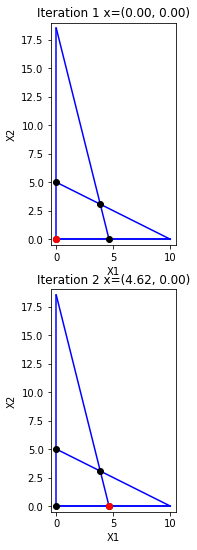

In [580]:
# Пример ненулевой начальной точки
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True, method='largest_coef', start_point=-np.array([0, 2.5]))
corr_ans = (np.array([ 4.,  0.]), 20.0)

INITIAL PROBLEM:
[[-1.  1. -1.]
 [-1. -2. -2.]
 [ 0.  1.  1.]
 [ 2.  1.  0.]]
n=3, m=2, basis=[0 1 2], nonbasis=[3 4] with c_old=None
>             AUXILARY PROBLEM:
[[-1.  1. -1. -1.]
 [-1. -2. -1. -2.]
 [ 0.  1. -1.  1.]
 [-0. -0.  1.  0.]]
n=3, m=3, basis=[0 1 2], nonbasis=[3 4 5] with c_old=[-2 -1  0  0]
>First step
>j=2
>i=1
>basis [0 5 2], nonbasis [3 4 1]
>[[-0.  3. -1.  1.]
 [ 1.  2. -1.  2.]
 [ 1.  3. -1.  3.]
 [-1. -2.  1. -2.]]
n=3, m=3, basis=[0 5 2], nonbasis=[3 4 1] with c_old=[-2. -1.  0.  0.]
>          AUXILARY ITERATION #1
>j=1
>ratios [0.3333333333333333 1.0 1.0]
>i=0
>basis [4 5 2], nonbasis [3 0 1]
>[[-0.          0.33333333 -0.33333333  0.33333333]
 [ 1.         -0.66666667 -0.33333333  1.33333333]
 [ 1.         -1.         -0.          2.        ]
 [-1.          0.66666667  0.33333333 -1.33333333]]
n=3, m=3, basis=[4 5 2], nonbasis=[3 0 1] with c_old=[-2.          0.33333333 -0.33333333  0.33333333]
>x=[ 0.          0.33333333  1.33333333], w=[ 0.  0.  2.]
>     

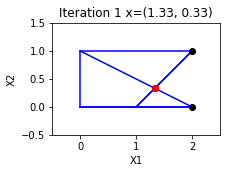

(array([ 1.33333333,  0.33333333]), -3.0000000000000004, 0)


In [581]:
# Пример инициализации
A=np.array([[-1,1],[-1, -2], [0, 1]])
b=np.array([-1, -2, 1])
c=np.array([-2, -1])
ans = solve_lin_prog(A, b, c, method='largest_coef', draw=True)
corr_ans = (np.array([ 1.33333333,  0.33333333]), -3)
print(ans)
assert((float_equal(ans[0], corr_ans[0])).all() and float_equal(ans[1], corr_ans[1]).all())

(5, 2)
INITIAL PROBLEM:
[[ -4.  -2.  -8.]
 [ -2.   0.  -2.]
 [  3.   2.  10.]
 [ -1.   3.   1.]
 [  0.  -3.  -2.]
 [  3.  -4.   0.]]
n=5, m=2, basis=[0 1 2 3 4], nonbasis=[5 6] with c_old=None
>             AUXILARY PROBLEM:
[[ -4.  -2.  -1.  -8.]
 [ -2.   0.  -1.  -2.]
 [  3.   2.  -1.  10.]
 [ -1.   3.  -1.   1.]
 [  0.  -3.  -1.  -2.]
 [ -0.  -0.   1.   0.]]
n=5, m=3, basis=[0 1 2 3 4], nonbasis=[5 6 7] with c_old=[-3  4  0  0]
>First step
>j=2
>i=0
>basis [7 1 2 3 4], nonbasis [5 6 0]
>[[  4.   2.  -1.   8.]
 [  2.   2.  -1.   6.]
 [  7.   4.  -1.  18.]
 [  3.   5.  -1.   9.]
 [  4.  -1.  -1.   6.]
 [ -4.  -2.   1.  -8.]]
n=5, m=3, basis=[7 1 2 3 4], nonbasis=[5 6 0] with c_old=[-3.  4.  0.  0.]
>          AUXILARY ITERATION #1
>j=0
>ratios [2.0 3.0 2.5714285714285716 3.0 1.5]
>i=4
>basis [7 1 2 3 5], nonbasis [4 6 0]
>[[-1.    3.   -0.    2.  ]
 [-0.5   2.5  -0.5   3.  ]
 [-1.75  5.75  0.75  7.5 ]
 [-0.75  5.75 -0.25  4.5 ]
 [ 0.25 -0.25 -0.25  1.5 ]
 [ 1.   -3.   -0.   -2.  ]]
n=

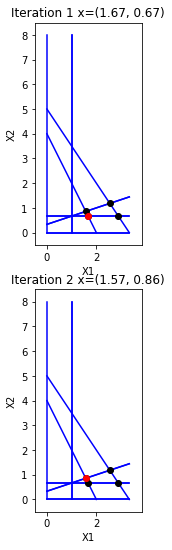

(array([ 1.57142857,  0.85714286]), -1.2857142857142856, 1)


In [582]:
# Пример инициализации
A = np.array([[-4,-2],[-2,0], [3,2],[-1,3], [0,-3]])
print(A.shape)
b = np.array([-8,-2,10,1,-2])
c = np.array([-3,4])
ans = solve_lin_prog(A, b, c, method=method, draw=True)
print(ans)
corr_ans = (np.array([ 1.57142857,  0.85714286]), -1.2857142857142856)
assert((float_equal(ans[0], corr_ans[0])).all() and float_equal(ans[1], corr_ans[1]).all())

In [355]:
# Пример неограниченной задачи
A=np.array([[-1,-1],[-2, -1]])
b=np.array([1, 2])
c=np.array([2, 1])
try:
    ans = solve_lin_prog(A, b, c, method=method, draw=True)
except Exception as e:
    print(e)


SOLVING PROBLEM:
[[-1. -1.  1.]
 [-2. -1.  2.]
 [-2. -1.  0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 1.  2.]
>          ITERATION #1
Problem is unbounded


In [356]:
# Пример недопустимой задачи
A=np.array([[1,1],[-1, -1]])
b=np.array([1, -2])
c=np.array([-2, -1])
try:
    ans = solve_lin_prog(A, b, c, method=method, draw=True)
except Exception as e:
    print(e)

INITIAL PROBLEM:
[[ 1.  1.  1.]
 [-1. -1. -2.]
 [ 2.  1.  0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>             AUXILARY PROBLEM:
[[ 1.  1. -1.  1.]
 [-1. -1. -1. -2.]
 [-0. -0.  1.  0.]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=[-2 -1  0  0]
>First step
>j=2
>i=1
>basis [0 4], nonbasis [2 3 1]
>[[ 2.  2. -1.  3.]
 [ 1.  1. -1.  2.]
 [-1. -1.  1. -2.]]
n=2, m=3, basis=[0 4], nonbasis=[2 3 1] with c_old=[-2. -1.  0.  0.]
>          AUXILARY ITERATION #1
>j=0
>ratios [1.5 2.0]
>i=0
>basis [2 4], nonbasis [0 3 1]
>[[ 0.5  1.  -0.5  1.5]
 [-0.5 -0.  -0.5  0.5]
 [ 0.5 -0.   0.5 -0.5]]
n=2, m=3, basis=[2 4], nonbasis=[0 3 1] with c_old=[ 1.  1. -1.  3.]
>x=[ 1.5  0.   0.5], w=[ 0.  0.]
Problem is infeasible


SOLVING PROBLEM:
[[ 1.   2.   5. ]
 [ 2.   0.5  8. ]
 [-5.  -1.   0. ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 5.  8.]
>          ITERATION #1
>j=0
>ratios [5.0 4.0]
>i=1
>basis [0 2], nonbasis [1 3]
>[[ -0.5    1.75   1.  ]
 [  0.5    0.25   4.  ]
 [  2.5    0.25  20.  ]]
n=2, m=2, basis=[0 2], nonbasis=[1 3] with c_old=None
>x=[ 4.  0.], w=[ 1.  0.]
>FINISHED in 1 iterations
>path [array([ 0.,  0.]), array([ 4.,  0.])]
>x=[ 4.  0.], w=[ 1.  0.]
>SOLUTIONS [array([ 0.,  0.]), array([ 4.,  0.])]


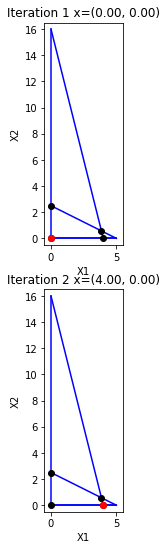

(array([ 4.,  0.]), 20.0, 1)
INITIAL PROBLEM:
[[-1.  -2.  -5. ]
 [-2.  -0.5 -1. ]
 [ 5.   8.   0. ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>             AUXILARY PROBLEM:
[[-1.  -2.  -1.  -5. ]
 [-2.  -0.5 -1.  -1. ]
 [-0.  -0.   1.   0. ]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=[-5 -8  0  0]
>First step
>j=2
>i=0
>basis [4 1], nonbasis [2 3 0]
>[[ 1.   2.  -1.   5. ]
 [-1.   1.5 -1.   4. ]
 [-1.  -2.   1.  -5. ]]
n=2, m=3, basis=[4 1], nonbasis=[2 3 0] with c_old=[-5. -8.  0.  0.]
>          AUXILARY ITERATION #1
>j=1
>ratios [2.5 2.6666666666666665]
>i=0
>basis [3 1], nonbasis [2 4 0]
>[[ 0.5   0.5  -0.5   2.5 ]
 [-1.75 -0.75 -0.25  0.25]
 [-0.    1.   -0.   -0.  ]]
n=2, m=3, basis=[3 1], nonbasis=[2 4 0] with c_old=[ -1.   4.  -4.  20.]
>x=[ 0.   2.5  0. ], w=[ 0.    0.25]
[ -1.   4.  -4.  20.]
SOLVING PROBLEM:
[[  0.5   -0.5    2.5 ]
 [ -1.75  -0.25   0.25]
 [  1.     4.    20.  ]]
n=2, m=2, basis=[3 1], nonbasis=[2 0] with c_old=None
>x=[ 0.   2.5], w=[

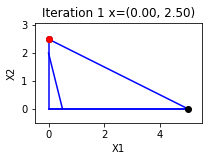

(array([ 0. ,  2.5]), -20.0, 0)
SOLVING PROBLEM:
[[ 1. -1.  1.]
 [ 2. -1.  3.]
 [ 0.  1.  5.]
 [-4. -3.  0.]]
n=3, m=2, basis=[0 1 2], nonbasis=[3 4] with c_old=None
>x=[ 0.  0.], w=[ 1.  3.  5.]
>          ITERATION #1
>j=0
>ratios [1.0 1.5 --]
>i=0
>basis [3 1 2], nonbasis [0 4]
>[[ 1. -1.  1.]
 [-2.  1.  1.]
 [-0.  1.  5.]
 [ 4. -7.  4.]]
n=3, m=2, basis=[3 1 2], nonbasis=[0 4] with c_old=None
>x=[ 1.  0.], w=[ 0.  1.  5.]
>          ITERATION #2
>j=1
>ratios [-- 1.0 5.0]
>i=1
>basis [3 4 2], nonbasis [0 1]
>[[ -1.   1.   2.]
 [ -2.   1.   1.]
 [  2.  -1.   4.]
 [-10.   7.  11.]]
n=3, m=2, basis=[3 4 2], nonbasis=[0 1] with c_old=None
>x=[ 2.  1.], w=[ 0.  0.  4.]
>          ITERATION #3
>j=0
>ratios [-- -- 2.0]
>i=2
>basis [3 4 0], nonbasis [2 1]
>[[  0.5   0.5   4. ]
 [  1.   -0.    5. ]
 [  0.5  -0.5   2. ]
 [  5.    2.   31. ]]
n=3, m=2, basis=[3 4 0], nonbasis=[2 1] with c_old=None
>x=[ 4.  5.], w=[ 2.  0.  0.]
>FINISHED in 3 iterations
>path [array([ 0.,  0.]), array([ 1.,  0.

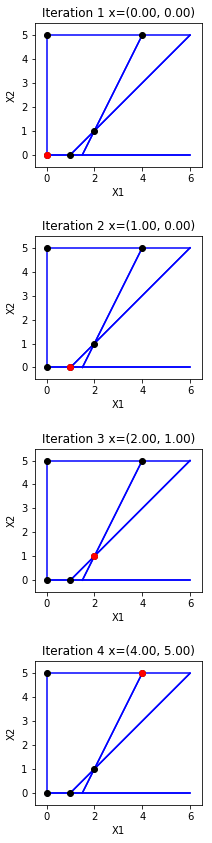

(array([ 4.,  5.]), 31.0, 3)
INITIAL PROBLEM:
[[-1. -2.  0. -4.]
 [ 1.  1. -1. -3.]
 [ 1.  3.  5.  0.]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=None
>             AUXILARY PROBLEM:
[[-1. -2.  0. -1. -4.]
 [ 1.  1. -1. -1. -3.]
 [-0. -0. -0.  1.  0.]]
n=2, m=4, basis=[0 1], nonbasis=[2 3 4 5] with c_old=[-1 -3 -5  0  0]
>First step
>j=3
>i=0
>basis [5 1], nonbasis [2 3 4 0]
>[[ 1.  2. -0. -1.  4.]
 [ 2.  3. -1. -1.  1.]
 [-1. -2. -0.  1. -4.]]
n=2, m=4, basis=[5 1], nonbasis=[2 3 4 0] with c_old=[-1. -3. -5.  0.  0.]
>          AUXILARY ITERATION #1
>j=1
>ratios [2.0 0.3333333333333333]
>i=1
>basis [5 3], nonbasis [2 1 4 0]
>[[-0.33333333 -0.66666667  0.66666667 -0.33333333  3.33333333]
 [ 0.66666667  0.33333333 -0.33333333 -0.33333333  0.33333333]
 [ 0.33333333  0.66666667 -0.66666667  0.33333333 -3.33333333]]
n=2, m=4, basis=[5 3], nonbasis=[2 1 4 0] with c_old=[ 1.  1. -6. -1.  1.]
>x=[ 0.          0.33333333  0.          3.33333333], w=[ 0.  0.]
>          AUXILARY ITERAT

In [357]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True, method=method)
print(ans)
corr_ans = (np.array([ 4.,  0.]), 20.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=True)
    print(ans)
    corr_ans = (np.array([ 0. ,  2.5]), -20.0, 0)
    assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

A=np.array([[1,-1],[2,-1], [0, 1]])
b=np.array([1,3,5])
c=np.array([4,3])
ans = solve_lin_prog(A, b, c, draw=True, method=method)
print(ans)
corr_ans = (np.array([ 4.,  5.]), 31.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=True)
    print(ans)
    #corr_ans = (array([ 0. ,  2.5]), -20.0, 0)
    #assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)
#print(is_optimal(A,b,c,x))

A=np.array([[2,3,1],[4,1,2],[3,4,2]])
b=np.array([5, 11, 8])
c=np.array([5, 4, 3])
ans = solve_lin_prog(A, b, c, method=method)
print(ans)
corr_ans = (np.array([ 2.,  0.,  1.]), 13.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=False)
    print(ans)
    #corr_ans = (array([ 0. ,  2.5]), -20.0, 0)
    #assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

A=np.array([[1,1,1,1],[2,1,-1,-1],[0,-1,0,1]])
b=np.array([40, 10, 10])
c=np.array([0.5, 3,1,4])
ans = solve_lin_prog(A, b, c, method=method)
print(ans)
corr_ans = (np.array([  0.,  15.,   0.,  25.]), 145.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    ans = solve_dual(A, b, c, draw=False)
    print(ans)
    corr_ans = (np.array([ 3.5,  0. ,  0.5]), -145.0, 1)
    assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
except Exception as e:
    print(e)

In [92]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

NameError: name 'x' is not defined

In [ ]:

# c = np.array([1, -1])
# A = np.array([[-2, 1],
#               [1, -2],
#                [1, 1]])
# b = np.array([2, 2, 5])
# x = np.array([1,4])
# x = np.array([4,1])


def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    # Если точка недопустима, она не оптимальна
    if (A@x>b).any() or (x < 0).any():
        return False
    A_ = -A.T
    c_ = -b
    b_ = -c
    print(A_, b_, c_)
    not_zeros_in_dual = (A@x == b)
    print(A_[:,not_zeros_in_dual])
    x_nonzero = np.linalg.solve(A_[:,not_zeros_in_dual], b_)
    print(x_nonzero)
    
    
    x_ = np.zeros(A_.shape[1])
    x_[not_zeros_in_dual] = x_nonzero
    print(x_)
    # Если для двойственной задачи её точка недопустима, то у прямой точка была не оптимальной.
    if (A_@x_ > b_).any() or (x_ < 0).any():
        return False
    
    return True

In [ ]:
is_optimal(A,b,c,x)

# ==========================================================
# Задача на МНК (0.4 балла)

* Для `method=0` решается обычным образом: $x = (A^TA)^{-1}A^Tb$ (было на лекции, нет смысла объяснять).
Здесь $A = 
\begin{pmatrix}
\dots\\
\sin t_i & t_i & 1\\
\dots 
\end{pmatrix}$
 
Для всех $i$ записывается $(a_2\sin t_i, a_1 t_i, a_0)$ как $A \cdot \begin{pmatrix}a_2\\a_1\\a_0\end{pmatrix}$

* Для `method=1` сведём к задаче линейного программирования:
$\sum_i |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \rightarrow \min $

$\Leftrightarrow
\begin{cases}
    |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \le y_i^{err} \forall i\\
    \sum y_i^{err} \rightarrow \min
 \end{cases}$, где $y_i^{err}$ -- число, обозначающее ошибку по данной координате
 
$\Leftrightarrow 
 \begin{cases}
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \le y_i^{err} \forall i\\
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \ge -y_i^{err} \forall i\\
    \sum y_i^{err} \rightarrow \min
 \end{cases}$

Тогда задача сводится к
$c^Tx \rightarrow \min\\
\begin{pmatrix}
-E & A\\
-E & -A
\end{pmatrix} x \le \begin{pmatrix}y^{corr}\\-y^{corr} \end{pmatrix}$

где $x = (y^{err}_1,\dots,y^{err}_n,a_2,a_1,a_0), c = (1, \dots, 1, 0, 0, 0)$.

Наша реализация симплекс-метода максимизирует, поэтому домножим $c$ на $-1$.

* Для `method=2`:
$\max_i |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \rightarrow \min $
$\Leftrightarrow 
 \begin{cases}
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \le y^{err} \forall i\\
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \ge -y^{err} \forall i\\
    y^{err} \rightarrow \min
 \end{cases}$
 
$\Leftrightarrow$ (для такой же A)

$c^Tx \rightarrow \min\\
\begin{pmatrix}
\begin{pmatrix}-1\\ \vdots \\ -1 \end{pmatrix} & A\\
\begin{pmatrix}-1\\ \vdots \\ -1 \end{pmatrix} & -A
\end{pmatrix} x \le \begin{pmatrix}y^{corr}\\-y^{corr} \end{pmatrix}$

где $x = (y^{err},a_2,a_1,a_0), c = (1, 0, 0, 0)$

In [538]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t,a): 
    return a[2]*sin(t)+a[1]*t +a[0]

def y_vector(t, a):
    return [y(t_, a) for t_ in t]

"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m = 200
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, σ):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,σ,m)
    return y_real, y_corr

#todo -выбрать параметр
#σ=0.5
σ=200

# генерация значений. изначальные и с помехами
y_real, y_corr= get_y(a,σ)

def solve_overdefined_system(A, b, method=0):
    A = np.matrix(A)
    b = b
    if method == 0:
        return ((A.T@A).I @ A.T @ b).A1
    elif method == 1:
        E = np.eye(A.shape[0])
        A_ = np.bmat([[-E, A],
                      [-E, -A]]).A
        b_ = np.hstack([b, -b])
        c_ = -np.hstack([np.ones(A.shape[0]), np.zeros(A.shape[1])]) # Точно с минусом?
        #print(A.shape, A_.shape, b_.shape, c_.shape)
        x, _, _ = solve_lin_prog(A_, b_, c_, method='largest_coef')
        #x = linprog(-c_, A_ub=A_, b_ub=b_, options=dict(bland=True, tol=1e-8, maxiter=10 ** 6))
        #return x.x[-A.shape[1]:]
        return x[-A.shape[1]:]
    elif method == 2:
        ones = np.ones(A.shape[0]).reshape(-1,1)
        A_ = np.bmat([[-ones, A],
                      [-ones, -A]]).A
        b_ = np.hstack([b, -b])
        c_ = -np.hstack([[1], np.zeros(A.shape[1])])
        #print(A.shape, A_.shape, b_.shape, c_.shape)
        
        x, _, _ = solve_lin_prog(A_, b_, c_)
        #x = linprog(-c_, A_ub=A_, b_ub=b_, options=dict(bland=True, tol=1e-8, maxiter=10 ** 6))
        #return x.x[-A.shape[1]:]
        return x[-A.shape[1]:]

# Я решил вынести функцию наружу для большей универсальности.
def get_params (y_corr, t, func, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    A = np.matrix([func(t_) for t_ in t])
    return solve_overdefined_system(A, y_corr, method=method)


## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [539]:
def analyze_approximation(t, y_corr):
    plt.figure(figsize=(10, 5))
    plt.plot(t, y_vector(t, a), color='black')
    plt.scatter(t, y_corr, color='gray', alpha=0.5)
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=0)
    print('For method=0', a_est)
    plt.plot(t, y_vector(t, a_est), color='r', label='For method=0')
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=1)
    print('For method=1', a_est)
    plt.plot(t, y_vector(t, a_est), color='g', label='For method=1')
    
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=2)
    print('For method=2', a_est)
    plt.plot(t, y_vector(t, a_est), color='b', label='For method=2')
    
    plt.legend()
    plt.ylim(-2000, 2000)
    plt.show()

For method=0 [  10.21399816  102.59382534  993.63037694]
INITIAL PROBLEM:
[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   2.98551993e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   5.00000000e-02
    4.99791693e-02  -2.01894903e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.00000000e-01
    9.98334166e-02  -1.96135110e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.90000000e+00
    4.57535894e-01  -5.40624330e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.95000000e+00
    5.01405128e-01  -6.52812777e+02]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
n=400, m=203, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  5

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.84917193e-01
   -1.00000000e+00   2.39603923e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   6.34896362e-01
   -1.00000000e+00   1.89559233e+03]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   6.84750610e-01
   -1.00000000e+00   1.90135213e+03]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.04245309e+00
   -1.00000000e+00   1.55686291e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.08632232e+00
   -1.00000000e+00   1.44467446e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -5.84917193e-01
    1.00000000e+00  -2.09748724e+03]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>i=356
>basis [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 

>          AUXILARY ITERATION #2
Ohlol (401, 205)
>j=156
>ratios [239.18399413196985 181.09803314034193 180.54187941814115
 191.95011451877298 265.37813952559395 232.37380710353057 209.8073912117322
 220.44303185470866 274.41315909586837 212.70723979693088
 213.63541415198603 266.8426844725867 226.7703362416802 282.15965322058037
 235.2508092493861 296.13794921617074 292.1985918090537 304.0177896692849
 301.4255679876151 307.94071080342593 236.9094744389548 282.6822727778027
 276.27847358196595 320.8577172240256 295.05133048837996 260.74037859696324
 257.8014413227201 282.4863394836805 287.0095240881598 295.75640049999174
 288.4504980362441 284.3576365678653 294.2539904637049 318.01426053845677
 261.1307770599296 276.65766322380745 287.0414775000212 268.75441902570225
 298.86520892258676 252.752732835928 259.814622786769 260.87318989688765
 256.345320887458 268.6386443903496 259.6742062729426 239.40344626121126
 244.15288219274348 254.8572304429041 216.76074092157566 203.6204487706669


>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.42982135e+00
    8.26315789e+00   1.89227127e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   4.50164656e+00
    8.31578947e+00   1.38896206e+03]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   4.57334686e+00
    8.36842105e+00   1.39185954e+03]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.61840067e-01
   -2.15789474e+00   1.61983390e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.83863255e-01
   -2.21052632e+00   1.51050777e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -4.42982135e+00
   -8.26315789e+00  -1.59371928e+03]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #3
Ohlol (401, 205)
>j=157
>ratios [204.27928536249803 149.09762242045153 148.56927638436076 159.407099729961
 229.16372348644092 197.80960768548073 176.37151258827228 186.4753711990999
 237.74699207820163 179.12636874421102 180.00813438151343
 230.55504118608403 192.48631036672288 245.10616149667803
 200.54275972404346 258.38554269248885 254.64315315572773 265.8713911229474
 263.408780525361 269.59816620038134 202.11849165413375 245.6026500760393
 239.51904083999435 281.869322299951 257.35325490108767 224.75785060424172
 221.96586019371077 245.41651344662318 249.71353882087854
 258.02307141211884 251.0824640715586 247.19424567659877 256.59578187764635
 279.16803844866064 225.1287291440598 239.87927099974377 249.7438945621468
 232.37118901154383 260.9764394135841 217.16958713125828 223.87838258455724
 224.88402133917 220.58254578021177 232.26120310795878 223.7449868964222
 204.48776488527736 208.999729020233 219.16885985788556 182.97719481262357
 170.49391

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.09192991e+00
    2.30769231e-01   1.74877572e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   1.14478984e+00
    2.37762238e-01   1.24465119e+03]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.19752484e+00
    2.44755245e-01   1.24673335e+03]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.79076497e-01
   -1.15384615e+00   1.63777085e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.02006498e+00
   -1.16083916e+00   1.52926003e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.09192991e+00
   -2.30769231e-01  -1.45022372e+03]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #4
Ohlol (401, 205)
>j=33
>ratios [1420.8802696528558 1005.5656485627164 1001.5891494489808
 1083.1580304184984 1608.1684092172675 1372.187432399515 1210.8375587731566
 1286.8823893704382 1672.7687991447297 1231.5714761573272
 1238.2079227959719 1618.639905588266 1332.1226157372848 1728.1562321364208
 1392.7579977423818 1828.1010485048912 1799.9346430440053
 1884.4419077446582 1865.9075227207188 1912.4907938537663 1404.617453847798
 1731.892961970561 1686.1057977203277 2004.847389761054 1820.3317246011877
 1575.0084185775581 1553.9950170667198 1730.492038917587 1762.8328088396138
 1825.3729751842116 1773.1357725684165 1743.871813069508 1814.630743424761
 6284.302802454249 1577.7997675877677 1688.8170036594945 1763.0612757344222
 1632.3088076430424 1847.6009554057662 1517.8967513861564
 1568.3892645346698 1575.9580193720183 1543.583755954596 1631.4810190002704
 1567.3852864608111 1422.4493523769313 1456.4078192873872
 1532.9439092760356 1260.5540091985374 1

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.62048092e-01
    1.50326797e-01   1.62168187e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   1.01417005e+00
    1.56862745e-01   1.11683521e+03]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.06616709e+00
    1.63398693e-01   1.11819525e+03]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.95311724e-01
   -1.14379085e+00   1.65365758e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.03703817e+00
   -1.15032680e+00   1.54586889e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.62048092e-01
   -1.50326797e-01  -1.32312987e+03]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #5
Ohlol (401, 205)
>j=23
>ratios [1409.7575304710217 965.3999288850684 961.1453529102324 1048.4183514300657
 1610.1427427322453 1357.659599703461 1185.0265181312036 1266.3891690499736
 1679.2606424448445 1207.2103598079736 1214.3108936241458 1621.34651157674
 1314.7930476103058 1738.5213224988918 1379.668666119256 1845.4552868651572
 1815.3192027007128 1905.7360663314817 1885.9055704667073
 1935.7464130076598 1392.3574548194563 1742.519362111643 1693.5302982634914
 8801.690019846179 1837.1426535975586 1574.6638716282205 1552.1810014802606
 1741.0204724116081 1775.6228346358744 1842.5364391863884
 1786.6462853387195 1755.3358951056214 1831.0430024087943 6613.279541090694
 1577.6504198699133 1696.4310990235792 1775.8672782366136
 1635.9712809080743 1866.3188236192404 1513.5583815563011 1567.581839680235
 1575.679878072643 1541.0416801505057 1635.0856049476258 1566.5076533494635
 1411.436339259718 1447.76952413594 1529.6577882496686 1238.2196434115062
 1137.

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.54031971e-01
   -3.50553506e-01   1.58504267e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   9.05540202e-01
   -3.46863469e-01   1.07998784e+03]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   9.56923510e-01
   -3.43173432e-01   1.08113970e+03]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.00881374e+00
   -1.08118081e+00   1.65823748e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.05115391e+00
   -1.08487085e+00   1.55065697e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -8.54031971e-01
    3.50553506e-01  -1.28649068e+03]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

  1308.14223785  1606.34016587  1510.36261178  1658.23747711  1550.65696557]
>          AUXILARY ITERATION #6
Ohlol (401, 205)
>j=202
>ratios [1855.952384192102 1192.6448329525444 1129.8078571929348 1179.8111459224763
 1753.667271681439 1414.17963811503 1183.8437099395505 1222.7258485796576
 1577.7857111681058 1090.9047278869261 1065.803242576939 1394.0885549879413
 1097.0076215778588 1425.356718190438 1101.4070213958612 1452.6062804855394
 1402.4333948333533 1449.0162531915398 1412.0475807390487
 1430.3175582106528 1009.7252990607639 1256.083761440764 1208.856106783136
 1390.7551501110702 1294.656005131136 1100.7956636484812 1080.6996608990064
 1212.0112104181553 1235.2093825448324 1282.9027408124614
 1245.2128661041156 1226.463877632011 1285.631815150544 1355.3816307748643
 1118.0388060039484 1213.6160087759447 1283.3990920975095 1193.016638617251
 1380.6535500846524 1129.984438922521 1188.3256351799196 1213.6968657838427
 1207.0704079869163 1306.342259823049 1275.6888983246265 1171.

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.21238786e+00
   -2.40782930e+00   1.51166502e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -2.34582102e+00
   -2.52821733e+00   1.00218464e+03]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -2.47893056e+00
   -2.64830443e+00   9.98921695e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.61335330e+00
   -3.51131008e+00   1.57156111e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.72303641e+00
   -3.61699327e+00   1.46034277e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   2.21238786e+00
    2.40782930e+00  -1.21311302e+03]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #7
Ohlol (401, 205)
>j=176
>ratios [627.8123687796664 396.39972128733694 377.19292465981107 398.4065527992906
 611.7846768672822 490.4338339432065 407.7981128256694 424.53167992628124
 559.8918484198072 378.8837078950286 370.9646030742477 497.15206446957893
 385.6131552534017 512.5129483924738 389.7354802768678 525.9928957841529
 507.99935033078845 527.2420025802813 514.0908985076317 522.2578120588905
 359.564907970107 456.2727744890195 438.5913767809167 562.5832509440411
 473.5258662273898 398.11806291977206 390.7256925348654 442.819212841318
 452.4330041365911 471.68382687815125 457.25935230450295 450.2539722909299
 473.99079125145715 553.7147753858177 408.35402797149135 446.4452289624341
 474.33924684445066 438.7614976873545 513.3608483365116 414.1401785110251
 437.43940214261534 447.64663330954164 445.13455156311926
 484.65499095501605 472.56378736684627 431.26290512517784 454.5782602396452
 495.56104147007625 403.6225445839606 378.22085065857505 482.1

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.50918868e+00
    8.88178420e-16   1.13619882e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -1.00074515e+01
    2.22044605e-15   6.07945678e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -1.05044787e+01
    2.22044605e-15   5.85956880e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.32541949e+01
   -4.44089210e-16   1.02402303e+03]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.36841454e+01
   -8.88178420e-16   8.96324925e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.50918868e+00
   -8.88178420e-16  -8.37646831e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #8
Ohlol (401, 205)
>j=38
>ratios [60.65648476707205 30.909997455697663 28.441097253552122 31.167961697295016
 58.59623637845208 42.99742901687408 32.37518145898912 34.52616519659525
 51.92577398285069 28.658435685991726 27.64048980610368 43.86101085336056
 29.523459368264948 45.83554570984042 30.05335559620538 47.568299249414636
 45.25535405253258 47.72886324565351 46.03838022898691 47.08818019868678
 26.175138238488532 38.606262273791195 36.333441499858 52.27173506969914
 40.82402729242278 31.130878328544213 30.180640499114897 36.87690043820089
 38.11268648480632 40.58724593789031 38.73307999437811 37.832587087256364
 40.88379017262411 51.131754180484045 32.446640486879716 37.34299960653263
 40.92858171702707 36.35530935988894 47.240085669419905 33.190409919843184
 36.1853631673529 37.49743178452431 37.1745211372246 42.254598918841815
 40.700358742203846 35.39141740791018 38.3884442454156 43.65649590579972
 31.838441185431304 28.573229995693104 41.930737

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.62484855e+00
    1.29698509e-15   1.07241868e+03]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -1.72890558e+00
    2.64969247e-15   5.40976621e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -1.83271243e+00
    2.67008113e-15   5.15806877e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.75655140e+00
    1.52068912e-16   9.31013178e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.84044655e+00
   -2.74077168e-16   8.00515665e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.62484855e+00
   -1.29698509e-15  -7.73866689e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #9
Ohlol (401, 205)
>j=179
>ratios [582.4875125255184 279.84144588176065 254.72241494227848 282.46602007894074
 561.5261780123656 402.8211301558376 294.748489219814 316.6329813545295
 493.65970404547414 256.93365491222323 246.5768919983536 411.60736576415724
 265.73456011670385 431.69663551588764 271.125818836997 449.3259790321778
 425.79366212794747 450.9595857635419 433.7603100854826 444.44116218968765
 231.66814383098895 358.1446166280454 335.0205327583482 497.1795738388546
 380.70855342512453 282.0887272721347 272.4208381381152 340.54978091293555
 353.12288853076706 378.29949769852016 359.4348827329002 350.2731073095281
 381.3165916259013 485.5812049773965 295.4755261129738 345.2919569717398
 381.7723087864036 335.243020266033 445.9866755384678 303.042768961516
 333.51395739639963 346.8631774907603 343.57782697996976 395.2634442683984
 379.45032754119023 325.4362116542343 355.9284971635208 409.5265942162012
 289.2875979589002 256.06675702426037 391.968

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.47829118e+00
    1.26567797e-15   8.62091476e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -1.57502055e+00
    2.61682004e-15   3.20133354e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -1.67151806e+00
    2.63564730e-15   2.84473836e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.54282847e+00
    1.06414088e-16   6.24295405e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.62029099e+00
   -3.21106108e-16   4.84566321e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.47829118e+00
   -1.26567797e-15  -5.63539483e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #10
Ohlol (401, 205)
>j=180
>ratios [507.08076767387007 179.3353910745862 152.1331665541525 182.17762876895577
 484.3810493189526 312.5141347584163 195.47871845033262 219.17815454714838
 410.8862132042435 154.5277910233811 143.31211193262587 322.02903819090784
 164.05858064389307 343.7843689421106 169.89695197718558 362.87576469035207
 337.39184496999735 364.6448511328872 346.0191899873363 357.5858359183884
 127.16693834116333 264.1324692912591 239.09063854674037 414.6979959371407
 288.567698353152 181.76904598304296 171.29937095872123 245.07844317553545
 258.6942748198305 285.95885269683635 265.5297408802756 255.60815303427978
 289.2261629131257 402.13774094162324 196.2660506069758 250.2139015528035
 289.71967401025614 239.3315775842221 359.2595231404048 204.46086669930938
 237.4591185509485 251.91542791472725 248.3576138239625 304.32966821349504
 287.2051241728558 228.71146208972795 261.73256065691174 319.7757022656646
 189.56493974927764 153.58899879682

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.31666291e-01
    1.80329965e-15   8.52217523e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   1.15432495e-01
    3.18132204e-15   3.09765718e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   9.92293585e-02
    3.22696243e-15   2.73613751e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.04954203e-01
    8.90421675e-16   6.09896333e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.98155094e-01
    4.86498490e-16   4.69733866e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.31666291e-01
   -1.80329965e-15  -5.53665531e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #11
Ohlol (401, 205)
>j=80
>ratios [206.78167696849388 71.5823970070393 60.361121495320916 72.75485745101345
 197.41774448908953 126.52038099648085 78.24173194573305 88.01806114686022
 167.10015762731507 61.34893559472047 56.72232040617791 130.44540384904866
 65.28051170885973 139.41976401670428 67.68891669873037 147.29521594650296
 136.78276377238737 148.0249873797481 140.34165710118444 145.11305072898628
 50.06222387921077 106.56230743838108 96.23222278331976 168.67256815589226
 116.64216091835951 72.58631167614017 68.26743298010486 98.70227097366464
 104.31898066911762 115.56597776079906 107.13870035261765
 103.04591482877181 116.91378621270324 163.49129771618 78.56651681920147
 100.82071512101733 117.11736603334737 96.33161330629261 145.80346872860906
 81.94698627569254 95.5591993193047 101.5226171321288 100.05497200987217
 123.14418086446537 116.08008114173047 91.95067593698045 105.57231355134677
 129.5158731329628 75.80222042453296 60.96167144966669 

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -8.80701189e-02
    8.88178420e-16   8.11604018e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -1.15290422e-01
    2.22044605e-15   2.67121595e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -1.42452603e-01
    2.22044605e-15   2.28944087e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.84515096e-01
   -4.44089210e-16   5.50670120e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.68071431e-01
   -8.88178420e-16   4.08725066e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.80701189e-02
   -8.88178420e-16  -5.13052025e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #12
Ohlol (401, 205)
>j=109
>ratios [1412.7658914455067 442.8394511295427 362.33745573438455 451.250741375758
 1345.5885684620034 836.9673138238285 490.6138552077334 560.7497330327461
 1128.0886741416004 369.42408380960575 336.23251354522085 865.1256253520799
 397.62940876625896 929.5081369601982 414.90742740164234 986.0070255513718
 910.5901644620322 991.2424425498464 936.1218443559525 970.3520624316665
 288.4526457944189 693.7870894373464 619.6785421100029 1139.36922642807
 766.1004657181172 450.04158550229664 419.0577323264789 637.3987921686803
 677.693350266564 758.3798735711902 697.9221612194461 668.5603118423469
 768.0491192532374 1102.1985314706915 492.94387823952394 652.5966171233383
 769.5096111346572 620.3915747250857 975.3051559162999 517.1955362917414
 614.8502378994527 657.6320974844916 647.1031374968104 812.7462841203146
 762.0680771057309 588.9625095031734 686.6848234559038 858.457125202711
 473.11267675070326 366.6458313382825 802.186323389

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -5.24310705e-01
    1.23718997e-15   7.79966562e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -5.73342415e-01
    2.58690768e-15   2.33902312e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -6.22261483e-01
    2.60431414e-15   1.94146929e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.51649588e-01
    6.48703640e-17   5.04533578e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.87240498e-01
   -3.63900213e-16   3.61199909e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.24310705e-01
   -1.23718997e-15  -4.81414569e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #13
Ohlol (401, 205)
>j=194
>ratios [992.444902485176 283.4498466103366 224.60464521069926 289.59831617484525
 943.3397457614399 571.5487110373516 318.3718931500411 369.63968888223803
 784.3520706999873 229.78481564354053 205.52250230098926 592.1318221120536
 250.4022925081736 639.194032726799 263.03214697817816 680.4934870034722
 625.3654077807604 684.3204625482902 644.0285084660779 669.0500506866332
 170.5964619358695 466.88709241398817 412.71536199282684 792.5979081843631
 519.7465919859162 288.71444962535014 266.0659292834874 425.66847798003033
 455.1229203816155 514.1030076551145 469.90973962447276 448.4468686536354
 521.1710151839922 765.4269415493796 320.0750891254759 436.77775627683974
 522.238602869028 413.2365732700516 672.6706539055195 337.8025217854086
 409.1859770093382 440.45858250408384 432.7621425840233 553.8436670317517
 516.7990039310773 390.262612640785 461.69549101305057 587.2572940659236
 305.578913721647 227.7539737319636 546.12456624

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   6.85225811e-01
    4.09074599e-16   7.66396408e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   6.96669202e-01
    1.71738772e-15   2.19653670e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   7.08074069e-01
    1.69349309e-15   1.79221495e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.61220375e+00
   -1.14276086e-15   4.84744378e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.62970119e+00
   -1.60787865e-15   3.40815095e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -6.85225811e-01
   -4.09074599e-16  -4.67844416e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #14
Ohlol (401, 205)
>j=104
>ratios [88.79817912108311 24.23819943645514 18.879847533407315 24.798069448082288
 84.3267404358259 50.47203094268777 27.418146315445746 32.086511522678734
 69.84957167840996 19.351545742211442 17.142257477761667 52.34629680930869
 21.228940903855534 56.63170802060777 22.37899567680059 60.39237166275159
 55.372495085080324 60.74085006380639 57.071927811884805 59.35035026920907
 13.961946927282046 40.94170782393607 36.0089148707385 70.60042472888317
 45.75501109061741 24.71758594399224 22.65524714340168 37.18840533129556
 39.87048073832643 45.24111513785161 41.21694534623712 39.26256992095114
 45.884716836754976 68.12627904982514 27.573236674203375 38.19999881873943
 45.98192969978748 36.0563755535602 59.68003672939035 29.187468935631028
 35.68753460024832 38.535169091768076 37.83434332328657 48.85983735706881
 45.48660833750619 33.96440266995418 40.46896872907504 51.90242991768137
 26.25323763920134 19.166620457517716 48.156948

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.05156451e+00
    2.92169547e-16   7.30811106e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -2.17695673e+00
    1.59463758e-15   1.82289154e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -2.30204544e+00
    1.56491248e-15   1.40082212e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.37882644e+00
   -1.31324217e-15   4.32850736e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.48145078e+00
   -1.78349109e-15   2.87359562e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   2.05156451e+00
   -2.92169547e-16  -4.32259114e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #15
Ohlol (401, 205)
>j=200
>ratios [110.16789497429123 26.343697053126814 19.4424903211782 27.38992493965438
 106.78891964769085 61.998378604680845 31.293378819343665
 37.712233902439614 88.96200208582212 20.681113718658555 17.73564282134794
 65.88198139514579 23.432188386692253 72.10637145929344 25.127333254462467
 77.61480757296367 70.83186444944194 78.39714558942833 73.44416434068486
 76.72858696697708 13.690045839545803 51.30264105087115 44.48788866221066
 84.68770848894333 58.22412649892827 28.833214604374742 25.97178801670578
 46.382364824046675 50.188157458131236 57.774943806910684
 52.159658530578184 49.445851581006366 58.80186097502123 83.44613828196681
 33.05626549085589 48.06017204063331 59.06226569998886 45.07605095380917
 72.45987375029604 35.40498342522958 44.599735097744784 48.635681442856786
 47.65544153542247 63.252716237240634 58.4915781697547 42.20256579881887
 51.4049568420962 67.57759295073134 31.299943132903657 21.27595961738973
 62.

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.65532083e-02
    1.41578828e-15   7.07228499e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -5.41969863e-02
    2.76670607e-15   1.57689679e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -9.17626743e-02
    2.78530625e-15   1.14468482e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.51332635e-01
    1.94198046e-16   4.01212451e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.30310695e-01
   -2.30994623e-16   2.54775632e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.23325929e-01
   -1.24640564e-15  -4.12231524e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #16
Ohlol (401, 205)
>j=121
>ratios [741.5099375949113 158.49898072483836 110.49996325573497 165.7756661731412
 718.0086135469986 406.4831013461801 192.92482402892128 237.56900717429002
 594.0194967580286 119.11479083626057 98.62856073968324 433.49419164139147
 138.2489634786257 476.7858388891733 150.03897228159187 515.09790973665
 467.9214349368687 520.5391981341108 486.0904063913584 508.93410099993946
 70.4907744444967 332.09250363903124 284.6947902164441 564.2910882356639
 380.2325628833704 175.81398099555892 155.91229276873796 297.87118065346715
 324.3410886307972 377.10842405977036 338.0531998734084 319.1782302862429
 384.2508003145303 555.6557651148686 205.1859881163899 309.54060326703825
 386.06195761328144 288.785554803804 479.2445049312513 221.52170410647832
 285.4727004025289 313.54336494682894 306.72563664678614 415.20722399253805
 382.092732838968 268.7999972761505 332.8041266407942 445.2874463341667
 192.97047989947797 123.25204100041557 408.3

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.54579319e-01
    1.51768864e-15   6.88122670e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   3.32938549e-01
    2.87300031e-15   1.37760018e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   3.11334757e-01
    2.89598309e-15   9.37171057e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.49241830e-01
    3.30906969e-16   3.75580184e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.43102020e-01
   -9.01995732e-17   2.28377236e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.14067580e-03
   -1.33294479e-15  -3.96005849e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #17
Ohlol (401, 205)
>j=97
>ratios [1165.0930241890308 223.60623524344058 146.0940713689624 235.35713483831128
 1127.1414456584575 624.0683032064511 279.1994900308084 351.29403326252174
 926.915165081261 160.0058962850016 126.92330192901696 667.6876972646407
 190.90509388654095 737.5980711181505 209.9444230770875 799.4670774121184
 723.2832128558354 808.2540497334533 752.6237362054569 789.5133288130271
 81.48444052354226 503.93717335762545 427.39603723016234 878.9076558734686
 581.6771013358639 251.56770631593992 219.4290709738916 448.6741922566909
 491.41964733192975 576.6320238899061 513.5629217101294 483.082303295223
 588.1660316238873 864.962733328356 298.9996736627232 467.51879045134973
 591.0908148537445 434.0020894326153 741.5684966646492 325.37972812208216
 428.65226089895395 473.98272941581155 462.97298586044076 638.1566254238969
 584.681033625217 401.7280160892714 505.08635185414374 686.7322681446232
 279.2732183174905 166.68701664168637 627.1355

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.30648945e-01
    1.95511593e-15   6.71910496e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   4.12288250e-01
    3.32928920e-15   1.20848785e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   3.93956108e-01
    3.37108512e-15   7.61086090e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.51296387e-01
    9.17756826e-16   3.53830027e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.48206911e-01
    5.14190784e-16   2.05976983e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -5.64616491e-02
   -1.70443104e-15  -3.82237618e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #18
Ohlol (401, 205)
>j=64
>ratios [585.5767334197036 100.96728000581406 61.06961196715023 107.01579507437853
 566.0419996944507 307.0962519119359 129.58267549763798 166.69174341007547
 462.97996045088263 68.23041544066675 51.20188338200431 329.548368033988
 84.13509242225223 365.5331831783967 93.93516505283175 397.3788826352725
 358.1649272244635 401.9017818451212 373.26731118808937 392.2554112019376
 27.813236777501455 245.2614159295514 205.86356289759385 438.26915933278536
 285.27632049147456 115.35982738108613 98.81717729884646 216.81602149620085
 238.81829690055238 282.6794787171418 250.21605650717527 234.5268338827049
 288.6163535084451 431.09131958842266 139.7743810850346 226.51586066350936
 290.1218208384356 209.26388182361902 367.57687171072774 153.35292931606813
 206.51017618271547 229.84302995069268 224.17600852326436
 314.34790345869993 286.82252804523756 192.6515180326476 245.85293008525875
 339.3511387080051 129.62062549877413 71.669374034946

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.94607111e-01
   -2.59295678e-15   6.64939756e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   8.96252009e-01
   -1.41489363e-15   1.13577472e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   8.97874065e-01
   -1.56870403e-15   6.85374941e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.57373991e+00
   -5.18391052e-15   3.44478125e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.58925480e+00
   -5.76985080e-15   1.96345560e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -4.50479315e-01
    2.15803141e-15  -3.76317700e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #19
Ohlol (401, 205)
>j=4
>ratios [350.51212359443616 57.395642563962646 33.26350074454359 61.054092558835556
 615.8276142275975 182.0729439618558 74.70369128395963 97.14914570955582
 276.3593508303819 37.59471942119476 27.294995883018565 195.65312739208446
 47.21467816514256 217.41857647970818 53.14226125928653 236.6804775734559
 212.96187997629895 239.4161573896606 222.09657103815144 233.58154108631177
 13.148351114778642 144.6720855993731 120.84225735411134 261.41299966831656
 168.8751380395073 66.10098830161807 56.09515093120414 127.46686217855289
 140.77495903005772 167.30443586413054 147.6689045855755 138.1792636109889
 170.89536013291303 257.0714765873143 80.86815393823001 133.33381896871427
 171.80594345514191 122.89894343597894 218.6547033994354 89.08115153236452
 121.23336200423157 135.34626042313 131.91855721381313 186.45911218055807
 169.8103631241791 112.85093966365295 145.02986348954678 201.58234240032445
 74.7266453776319 39.67477674253619 1

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -4.94407185e+00
    1.19651752e-15   6.64058776e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,  -5.19418721e+00
    2.53798048e-15   1.12658503e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -5.44367866e+00
    2.54715013e-15   6.75806362e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -6.25939710e+00
   -9.99743058e-17   3.43296206e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -6.47800877e+00
   -5.33959564e-16   1.95128314e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.50803380e+00
   -1.06018939e-15  -3.75569525e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #20
Ohlol (401, 205)
>j=156
>ratios [134.31414357752863 21.689342101317237 12.41451607688497 22.797138837963583
 262.91121045801464 67.6194655873736 27.5148854338708 35.681873191675415
 101.42185385597632 13.60014896074915 9.794667106570868 71.03381478632294
 16.964583983438512 78.51718266172652 19.01710063920538 85.07855677723019
 76.37093168431026 85.70613992238492 79.34523440289294 83.31115991211763
 4.525590920942645 51.37450734493504 42.8241223741953 92.21444381265397
 59.758151433882226 23.26329817757311 19.695721431239267 44.91925837664569
 49.579746757168685 58.90282670098772 51.928503848505734 48.54449320392326
 60.03527174738923 89.19428499811785 28.287916309041616 46.72137298228265
 60.21987557283309 43.011814912055065 75.44063987294732 31.107888455136603
 42.381210074031216 47.32089507749447 46.10763970796 65.2252687042521
 59.377821307390846 39.401720133913024 50.67972274374081 70.5028539472342
 26.033211227094217 13.746187476982763 64.0080699

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.95272024e-14
    1.57104309e-15   6.53154351e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   6.25380322e-15
    2.93145291e-15   1.01202435e+02]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   2.86330050e-15
    2.95952215e-15   5.55743004e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.81685892e-14
    3.74190384e-16   3.29490758e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.08317974e-14
   -4.32345038e-17   1.80840706e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.26246535e-14
   -1.40168401e-15  -3.65626806e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #21
Ohlol (401, 205)
>j=174
>ratios [1101.9437483763043 162.5181002416887 85.15494989528382 171.75845097869072
 2174.5972076405706 545.6303051844455 211.11010439342422 279.2325575930745
 827.582682382973 95.04454726437743 63.30227371123749 574.110064235194
 123.10796234142302 636.53030937157 140.22840796598794 691.260022989868
 618.6280073111778 696.494817592546 643.4372520115405 676.5178176873341
 19.35187161618899 410.12790939069083 338.80746453615046 750.7818620111275
 480.0575357141849 175.64677783038493 145.88891763204686 356.2834065243623
 395.15745788880736 472.9231036793839 414.748903324617 386.52220413036525
 482.3690508220058 725.5901225840502 217.5581071549546 371.3151993375194
 483.90886768376834 340.3730449564293 610.8682601117251 241.08005015812532
 335.11304581847287 376.31593119660596 366.19592923488466 525.6598374969765
 476.88512723131845 310.2605334817713 404.33257420931244 569.6812153150885
 198.7511680509753 96.2626832874128 515.506942

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.82851489e-14
    1.42785389e-15   6.41683929e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   4.94891555e-15
    2.78101992e-15   8.91517369e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.49573540e-15
    2.80186344e-15   4.29447735e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.65960987e-14
    1.92907002e-16   3.14968735e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.20438707e-15
   -2.30849273e-16   1.65811497e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.14921419e-14
   -1.27112325e-15  -3.55168008e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #22
Ohlol (401, 205)
>j=19
>ratios [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 31803.24683977366 13455.252476488095 -- 10381.39703787922
 2912.8061533741857 2030.974172507046 4789.109563111186 4827.751348627096
 5348.57158460592 4332.609927755039 3775.777549474131 4505.18593189226 --
 1760.8956948637624 3012.0866399979095 3846.9558574007324 2582.612462177911
 -- 1701.3610670365947 2377.2878717637786 2644.3128863044776
 2534.7314633654646 3659.383909285031 3278.338016460322 2071.2702060598235
 2729.9830543456987 3895.5459261566057 1270.5095340542946 546.207202251923
 3541.8320328527275 1305.6757498195857 3934.6668687155593 3610.382355815948
 1574.5828440345692 4507.314843332698 4320.106691791618 5357.3109547283175
 6655.220175351902 1196.4183469366953 6790.15741947872 3039.414416716523
 6054.795365355096 5998.920365847538 -- 7420.3566429175235
 18909.043485501137 10196.445720679905 22806.81400590182 15947.245794897042
 38892.10548152208

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.82983755e-14
    1.39777475e-15   6.42973393e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   4.96140235e-15
    2.75262322e-15   9.03690763e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.50748363e-15
    2.77514635e-15   4.40901094e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.65904520e-14
    2.05748418e-16   3.14418236e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.19854850e-15
   -2.17571557e-16   1.65242294e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.14740813e-14
   -1.31219540e-15  -3.53407284e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #23
Ohlol (401, 205)
>j=17
>ratios [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 32757.867641393514 13857.008417061457 -- 10690.531047886478
 2996.8953230670527 2088.4918322072986 4929.735823636227 4969.5419699512995
 5506.055649131241 4459.480864266358 3885.8699188380515 4637.2569576699125
 -- 1810.2753043195328 3099.1673460600964 3959.1929835452697
 2656.752179871439 -- 1748.9467690445306 2445.2407142653296
 2720.3117715852536 2607.4284227263333 3765.969085849798 3373.441453908664
 2130.0020726401185 2808.5633675805148 4009.2471764489414
 1305.1127449954915 558.9856131578174 3644.875116448491 1341.3385951059684
 4049.5469178479007 3715.49100930613 1618.348443242387 4639.4500178289745
 4446.600878687874 5515.058355428299 6852.076395615665 1228.789029730156
 6991.0795915433755 3127.3185679563744 6233.559483965942 6176.000849548372
 -- 7640.268084283204 19475.133976689365 10500.006746400206
 23490.352775876552 16424.090898483657 40060.328

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.82261342e-14
    1.39475130e-15   6.44793497e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   4.89320179e-15
    2.74976888e-15   9.20873757e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.44331701e-15
    2.77246084e-15   4.57067744e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.66212933e-14
    2.07039193e-16   3.13641195e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.23043769e-15
   -2.16236926e-16   1.64438852e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.15727246e-14
   -1.31632384e-15  -3.50921987e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #24
Ohlol (401, 205)
>j=134
>ratios [-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 11001.53219970423 4652.785953374094 -- 3589.1749781778376
 1004.9040543619438 699.7738386242061 1654.1398233340847 1667.5105975935612
 1847.7240559538807 1496.182485380149 1303.5081580694796 1555.8969826041732
 -- 606.3216777393412 1039.2569435282628 1328.1371723541897
 890.650914970372 -- 585.7215926586136 819.60479969145 912.0004057274843
 874.0832016027829 1263.233800468526 1131.3848564449138 713.7170133764342
 941.6438723105417 1344.9502370693206 436.63897367653857 186.01693732798182
 1222.558671652157 448.80713636053616 1358.4868085499093 1246.2783544131412
 541.8539768601759 1556.633625435463 1491.8561339098983 1850.748040055973
 2299.8486953842594 411.002049183023 2346.539483771163 1048.7128609668478
 2092.0905784372417 2072.756792609558 -- 2564.600099827011
 6539.8987631548125 3525.178393179285 7888.599633151092 5515.06184647043
 13454.408726776921 

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.86380047e-14
    1.36159617e-15   6.46772167e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   5.28203482e-15
    2.71846823e-15   9.39553708e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.80915124e-15
    2.74301157e-15   4.74642809e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.64454571e-14
    2.21193816e-16   3.12796460e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.04862732e-15
   -2.01601385e-16   1.63565416e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.10103280e-14
   -1.36159617e-15  -3.48220174e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #25
Ohlol (401, 205)
>j=20
>ratios [1244.2470332667265 171.37286303683513 82.3143489425215 178.94683166308533
 3364.9967241024806 596.0078783346142 219.55586267610204 294.5849088224885
 904.5914179948909 87.56586398587122 51.73215525841993 617.5907117014145
 117.0153756910256 684.1522985611748 134.95655156213132 742.2531020067843
 661.1583557837912 838.2267462065264 686.6720004913125 780.7904269882933 --
 428.46829122832 349.8116967600352 854.1595244148685 503.69187501100816
 170.18585148778462 137.41978601438348 367.2017102869446 409.39100607005304
 494.0378920581025 430.2374033486336 399.18577524966463 503.525922124273
 811.7520954065162 214.36501681710524 381.8335836595461 504.3772151837946
 347.83558964092543 681.0827431700991 239.47819824353596 341.79704254691615
 386.5791098304976 375.49045151098676 549.0160834208169 495.8678916204227
 314.4721885545731 416.8377020947337 596.7851271922112 193.08421070629987
 81.54809991373992 537.8813743914087 195.44

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.78867440e-14
    8.83711060e-16   6.31551548e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   4.48966944e-15
    2.21443596e-15   7.79019665e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   9.75782340e-16
    2.21289651e-15   3.05801410e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.54450741e-14
   -4.15160744e-16   2.92528597e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.01331738e-15
   -8.60173354e-16   1.42589930e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.02590673e-14
   -8.83711060e-16  -3.32999555e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #26
Ohlol (401, 205)
>j=108
>ratios [1102.1145556937447 128.89364475414246 48.10727612041606 135.76410994978394
 3025.879712187163 514.0866970916818 172.6011960233485 240.6612152349857
 794.0076439300141 52.871007409805486 20.365690740095893 533.6648222183162
 79.58511928210034 594.0438769059324 95.85984003603899 646.7480228576825
 573.1857124008599 733.8072139781584 596.3295378676642 681.7058320438642 --
 362.1089217789495 290.75829684645794 748.2600858544558 430.3454091178536
 127.81688804481163 98.09427846693622 306.533049632504 344.8036185521929
 421.5881304505808 363.71371100499357 335.546294337519 430.1948706632212
 709.791644880365 167.89249869833282 319.8058504208619 430.9670918890213
 288.96573922512744 591.2594352847475 190.67305767029998 283.48807887440415
 324.11059130393437 314.05189621157336 471.45970622760575 423.248151625924
 258.70127718635393 351.5586327838032 514.7917516658405 148.58834721125842
 47.41219966271963 461.35923781729235 150.

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.82888997e-14
    6.05232770e-16   6.19881270e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   4.91382883e-15
    1.92072091e-15   6.55931567e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.42189124e-15
    1.90398222e-15   1.76343718e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.59805870e-14
   -7.85984037e-16   2.76988387e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.56752690e-15
   -1.24394341e-15   1.26507156e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.06612230e-14
   -6.05232770e-16  -3.21329277e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #27
Ohlol (401, 205)
>j=10
>ratios [945.4309339015117 94.85166866555241 24.245694933221483 100.85634362911848
 2626.7704272308274 431.50413857080986 133.0513584029338 192.53470949234801
 676.1504985180414 28.409118688675388 -- 448.6151018657033
 51.75681846819447 501.3854147459017 65.98066000838585 547.4479820773494
 483.15571782974456 623.5363007549646 503.38304529365803 578.0005393822823
 -- 298.6780319750359 236.3187449447024 636.1678759738137
 358.31561334078395 93.9106007945628 67.93352289635305 250.10562260342402
 283.55347809642154 350.6618940561419 300.0805916872284 275.46272712707963
 358.1840451770796 602.5470835198939 128.93603343826197 261.70583486282277
 358.85895398294014 234.75207870551066 498.9518580049627 148.84587188730748
 229.96469254892662 265.4681084599036 256.67697236251655 394.2488410727519
 352.1127255947247 208.30143055939905 289.4572507930382 432.12034481432363
 112.06451865337418 23.638209401391453 385.42119577412285
 113.938856

 598 599 321 356 557 376]
>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.64133955e-14
    1.67359436e-15   6.18039466e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   2.93570760e-15
    3.04753720e-15   6.36505794e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -6.58594309e-16
    3.08910929e-15   1.55912695e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.34831547e-14
    6.36652409e-16   2.74535830e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.98290037e-15
    2.28362350e-16   1.23968971e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.87857188e-14
   -1.67359436e-15  -3.19487473e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  

>          AUXILARY ITERATION #28
Ohlol (401, 205)
>j=66
>ratios [689.8428384836131 67.35990449921752 15.68804335464322 71.75433055885858
 1920.3044587079557 313.73367090132217 95.31574108832403 138.84768740151176
 492.77422614729215 18.73497894388113 -- 326.25605778568837
 35.82162242855402 364.87517364178416 46.23111508414003 398.58533239033903
 351.5340593143996 454.2693606616401 366.3371078496905 420.94473649199574
 -- 216.52699314328322 170.89033876157941 463.51357848405837
 260.1718104361026 66.67119891544155 47.66028679082846 180.98004633645687
 205.45832845986519 254.57055746542824 217.55343420576517 199.5372407877646
 260.07552436388227 438.9087351908344 92.30400583564597 189.46947754786677
 260.56944566059695 169.74379894218254 363.0942137688711 106.87470507492155
 166.24022637385755 192.2228377611718 185.78918435035237 286.46897278218887
 255.63232549783325 150.38631194864186 209.77891079706507
 314.18463165957155 79.95685554255174 15.243464710815447 280.00860069195255
 81.3

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.68486945e-14
    4.36620207e-16   6.13097212e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   3.39482376e-15
    1.74288282e-15   5.84379132e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -1.75719684e-16
    1.71694132e-15   1.01088569e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.40628015e-14
   -1.01050950e-15   2.67954696e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   6.58278465e-15
   -1.47630786e-15   1.17158067e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.92210178e-14
   -4.36620207e-16  -3.14545219e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #29
Ohlol (401, 205)
>j=141
>ratios [1142.4802871780548 103.24742355581637 16.98145015434679 110.58390095722166
 3196.7312286103834 514.5674787749914 149.91958519644507 222.5960021008123
 813.4749969969275 22.0682973991511 -- 535.4735555053643 50.594382965239895
 599.9480208610611 67.97299090887628 656.2270012102624 577.6750818141777
 749.1912721951702 602.3887143971635 693.5559403423254 --
 352.28130420779695 276.0910852797623 764.6244582875947 425.1461587784495
 102.09763223312275 70.35898757523137 292.93581326135507 333.80221109950105
 415.7948884916846 353.99494361293654 323.91697800909526 424.98540955128595
 723.5467670633168 144.89150477811327 307.1088860103321 425.81000925605747
 274.176941461968 596.9747152045078 169.2172311052391 268.32774053724035
 311.70561029438824 300.9646506750093 469.04917015120344 417.56750613720953
 241.85969139366037 341.01540669036433 515.3203560260623 124.27798486274135
 16.239227818750983 458.26360379932356 126.5680396

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.90530593e-14
    2.72400649e-15   6.12759910e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   5.71979891e-15
    4.15542193e-15   5.80821558e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   2.26956887e-15
    4.25432512e-15   9.73468965e+00]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.69981463e-14
    2.03538724e-15   2.67505543e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.62061284e-15
    1.67593200e-15   1.16693231e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -2.14253826e-14
   -2.72400649e-15  -3.14207917e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #30
Ohlol (401, 205)
>j=187
>ratios [755.7620250185904 67.92076979508994 10.823561359317186 72.77659374114232
 2115.417397322613 340.16283698148663 98.81186203305984 146.91449579158743
 538.0019640207312 14.190413502349749 -- 354.00002647325937
 33.07108903641743 396.67400141430505 44.57353850700417 433.92359757427107
 381.9321212373002 495.4542353009476 398.2894331084464 458.63065337239607
 -- 232.74983078512406 182.32150268111354 505.6690605489778
 280.97718654335563 67.15975276576883 46.152767762923226 193.47059086369134
 220.51899875129172 274.78782348803117 233.88404422341284 213.9762195772555
 280.8707908027485 478.48080305401334 95.48390612695482 202.85137980068757
 281.4165719417417 181.05458057693673 394.7060475835935 111.58447291691708
 177.18314632292763 205.8938322789906 198.7846699290362 310.0354501027573
 275.96107309262834 159.66463167282208 225.29322566719065 340.6611468902023
 81.84035239661586 10.332303662566062 302.89676371449644 83.3560

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.66628928e-14
    1.46314668e-15   6.09011651e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   3.19885598e-15
    2.82557502e-15   5.41288131e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,  -3.81828463e-16
    2.85566094e-15   5.57676844e+00]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.38153868e-14
    3.56419063e-16   2.62514340e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   6.32673181e-15
   -6.16549427e-17   1.11527767e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.90352161e-14
   -1.46314668e-15  -3.10459658e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #31
Ohlol (401, 205)
>j=129
>ratios [435.7647278780194 36.72147586687089 3.597182198899716 39.538526696421286
 1224.5532706680729 194.65960330442635 54.64259038450836 82.54878423306874
 309.4337143791318 5.550423034621134 -- 202.68709082652524
 16.503831409106617 227.44391023420084 23.176846160664994
 249.05383821525083 218.89157673876483 284.75013527552926
 228.38108449023264 263.387354587573 -- 132.34517395697048
 103.08975508336579 290.67614953353575 160.32372384986706 36.27998052487155
 24.093017985439182 109.55777131756116 125.24959637636039 156.7330355293885
 133.00317493532478 121.45387772911248 160.26199957553837 274.9031923215089
 52.71191475661172 114.99992893085063 160.5786282728378 102.35476468746224
 226.30222428493374 62.05247478016194 100.10879630022848 116.76497300433665
 112.64067362325454 177.18154373270175 157.41368289400043 89.94563001251927
 128.01930962035655 194.94869210939873 44.79676281101598 3.3121846541924302
 173.04011631783445 

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.73285532e-14
    1.15952723e-15   6.04382641e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   3.90093761e-15
    2.50534323e-15   4.92465305e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   3.56584665e-16
    2.51885772e-15   4.41836200e-01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.47017841e-14
   -4.78823395e-17   2.56350324e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.24407640e-15
   -4.80071950e-16   1.05148544e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.97008765e-14
   -1.15952723e-15  -3.05830648e+02]]
n=400, m=204, basis=[  0   1   2   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #32
Ohlol (401, 205)
>j=49
>ratios [1044.2533779028038 80.67420517890417 0.6881903076253904 87.47660440299508
 2948.9597165893565 462.0511346491706 123.94874400186097 191.33448990019613
 739.198893550243 5.404727121941448 -- 481.4352985126391 31.854181226978877
 541.2161755075383 47.96766767606525 593.3981793922236 520.5646536665904
 679.5948716487529 543.4791923353483 628.0096601744642 -- 311.5790091921891
 240.93525773456113 693.9045583493826 379.1394749410459 79.6081159410556
 50.1799694366879 256.55372941826874 294.44515029177217 370.46895498132125
 313.16789970763733 285.2795387557434 378.99042787686204 655.8172257477785
 119.28669592824798 269.6950360420932 379.75499867630987 239.16045905277574
 538.4593194600776 141.84156699776048 233.7370661006897 273.95712968627623
 263.9980864856717 419.8464510764963 372.11253026095324 209.19582824135946
 301.13324232911776 462.74920421966226 100.1737914366115 --
 409.84604840785926 102.29713563226231 454.2418273

>[[ -1.00000000e+00  -0.00000000e+00   9.01474301e-01 ...,   3.70071013e-14
   -1.11115827e-15   6.03984337e+02]
 [ -0.00000000e+00  -1.00000000e+00   9.50797872e-01 ...,   3.56189767e-15
    1.10418668e-16   4.88264336e+01]
 [ -0.00000000e+00  -0.00000000e+00  -1.55756886e+00 ...,   5.55405171e-16
    3.92329437e-15   6.88190308e-01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00   1.20040837e+00 ...,   1.42737368e-14
   -3.07154022e-15   2.55819940e+02]
 [ -0.00000000e+00  -0.00000000e+00   1.24231891e+00 ...,   6.80108453e-15
   -3.60929652e-15   1.04599642e+02]
 [ -0.00000000e+00  -0.00000000e+00  -9.01474301e-01 ...,  -1.93794246e-14
    1.11115827e-15  -3.05432344e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #33
Ohlol (401, 205)
>j=2
>ratios [669.9961790176854 51.35311619785212 -- 55.72043463897067
 1892.8675283500093 296.2070923058573 79.1365033832254 122.39991692826901
 474.1432113852392 3.0281401500850573 -- 308.65223313304887
 20.009382336129583 347.03312168799187 30.354662611739073
 380.53533470909895 333.7743038500565 435.8758684316947 348.48603775467234
 402.7568117666883 -- 199.60004724222304 154.24490880841154
 445.06306203141185 242.97563550681411 50.66865898871848 31.77501827717381
 164.27237664134518 188.59966113164236 237.4089346316163 200.62015656254346
 182.7150984991431 242.87994338840696 420.60999708119465 76.14334643160701
 172.7094396345558 243.37081786401018 153.10544157679368 345.2631479097779
 90.62416431863684 149.6234812753174 175.4458153685899 169.05184882927531
 269.1105802082235 238.46415300261137 133.86736389082884 192.89359136542706
 296.6552712509558 63.872361224793096 -- 262.69005980732237
 65.2356038039211 291.19331252382005 259

>[[ -1.00000000e+00  -0.00000000e+00  -5.45556271e+00 ...,   3.68375569e-14
    1.20520916e-15   6.03161971e+02]
 [ -0.00000000e+00  -1.00000000e+00  -5.75406022e+00 ...,   3.38307671e-15
    2.55352462e-15   4.79590727e+01]
 [ -0.00000000e+00  -0.00000000e+00   9.42613073e+00 ...,   8.48344362e-16
   -7.89293140e-17   2.10907517e+00]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -7.26465869e+00 ...,   1.40479705e-14
    1.29479781e-17   2.54724873e+02]
 [ -0.00000000e+00  -0.00000000e+00  -7.51829385e+00 ...,   6.56743586e-15
   -4.17117828e-16   1.03466343e+02]
 [ -0.00000000e+00  -0.00000000e+00   5.45556271e+00 ...,  -1.92098802e-14
   -1.20520916e-15  -3.04609979e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #34
Ohlol (401, 205)
>j=175
>ratios [110.55907585099412 8.334822869554277 -- 9.056476262288479
 312.6256917896066 48.79436456890995 12.925735095051941 20.074558700881607
 78.19643491363732 0.3496293488962629 -- 50.850793066644464
 3.15560083955348 57.19283082167796 4.865049488726792 62.72871880803548
 55.00195076440871 71.873159373813 57.43290990521954 66.40058394138433 --
 32.8310674628849 25.336608341120815 73.39124639227272 39.99842676013068
 8.22172352179383 5.099748308762387 26.993541830110065 31.013369471516643
 39.07858804740927 32.99962978823264 30.041007449888482 39.982614645022174
 69.35063485409636 12.431147421118059 28.387677663310996 40.063726484129326
 25.148323377545807 56.90036128932767 14.823950121134756 24.572966096229127
 28.839834944463018 27.783299290300018 44.31695122015662 39.252951773748634
 21.96943358076586 31.722896235628916 48.86842142110493 10.403496306119349
 -- 43.256027819928725 10.628757789936286 47.96589024561268
 42.68288

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.50072559e-14
    4.83294830e-16   6.01986269e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   1.45263202e-15
    1.79211122e-15   4.67190428e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.01074157e-15
    1.16839552e-15   4.14045528e+00]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.16107312e-14
   -9.48357299e-16   2.53159302e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.04510383e-15
   -1.41198570e-15   1.01846112e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.73795792e-14
   -4.83294830e-16  -3.03434277e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8   9 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #35
Ohlol (401, 205)
>j=134
>ratios [211.31123602235212 15.794623554282317 -- 17.676982630851832
 258.6112511890007 99.39809200102249 26.272527177969902 41.43622880029491
 164.12380252073712 0.28455670714094855 -- 108.97417237783601
 6.368022706689409 124.14292436273165 10.186551006563924 137.66389667556948
 121.22729916627523 122.56361105067862 127.7032977462892 116.80083546029894
 -- 73.59249117167222 56.86192361368146 135.06687537559358
 90.56519063473662 18.273035495016682 11.1743996600944 61.401456737722725
 70.76635981041504 89.4719052879421 75.61297420751876 68.90438080907909
 92.01425896403136 134.06796072952966 28.3424852716605 65.44319892706227
 92.66795272814068 58.03952520125992 110.04923541592365 34.06367681226051
 56.836178997035205 66.83334070739441 64.39989345473782 103.0675698359525
 91.26364093211598 50.870093082610516 73.6897356887947 113.79790124846512
 23.82898363710813 -- 100.6370099334621 24.34090019637621
 111.57186680633305 99.1784

 598 599 321 356 557 376]
>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.68699938e-14
    1.60684403e-15   6.01175620e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   3.38670306e-15
    2.95868646e-15   4.58773503e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.37530587e-15
   -4.21222431e-16   5.28737623e+00]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.36050708e-14
    2.54570173e-16   2.52291381e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   6.10918356e-15
   -1.66993006e-16   1.00947840e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.85884526e-14
   -1.21245203e-15  -3.02908184e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 600 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  

>          AUXILARY ITERATION #36
Ohlol (401, 205)
>j=8
>ratios [-- -- -- -- -- -- -- -- -- 0.41965526306125633 -- 11132.771596652008
 429.3589243796609 6772.60207190679 447.2045966663283 5335.321946420622
 4152.33169215002 -- 3614.3208896917067 -- -- 1701.9431192370396
 1247.3359450514279 -- 1823.6864675024335 350.100176506746
 204.94279013775184 1115.7587410698425 1251.740538765003 1544.791782620741
 1275.4014174071349 1138.042280559022 1493.0005217117882 --
 442.0672890210735 1012.3681274498737 1417.411536932531 876.1774255448021
 -- 502.8355822355788 835.3096669187563 976.4105653719453 935.3927227572791
 1492.5567927741658 1316.3074041986865 729.9130975473214 1057.3535886372897
 1633.8370150912717 338.95377788048654 -- 1449.6212090315098
 348.62705748680185 1619.7478350628003 1447.1940292025774
 457.77188418220027 1829.2092509850495 1710.140043232667 2148.181140317821
 2678.849013981749 216.86388110559284 2581.4139395407487 937.5573734867106
 2081.0222228559883 1944.5635367470438 -

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.66886344e-14
    1.49745332e-15   6.01254547e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   3.22600607e-15
    2.86175872e-15   4.59472844e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.10565283e-15
   -5.83869281e-16   5.40472712e+00]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.38496645e-14
    4.02101983e-16   2.52184935e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   6.36220630e-15
   -1.43770686e-17   1.00837727e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.90609577e-14
   -1.49745332e-15  -3.02702554e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 408 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #37
Ohlol (401, 205)
>j=9
>ratios [887.7031336851069 64.31827339986866 -- 70.13096912148673
 2515.2874640214063 390.2074153374213 101.29665681793591 158.8782282573339
 1049.3616063101902 -- -- 406.77131325703874 22.601235777371116
 457.8544732562618 36.37031792874583 502.44434526079795 440.20760945199544
 576.0999964202779 459.7882363006852 532.0200875296861 -- 261.627975781892
 201.26241675934233 588.3277195988691 319.3588465044035 63.40729300198797
 38.26074460840282 214.6085054764793 246.98697853307618 311.94982909542733
 262.9856933749078 239.1549020544118 319.2314847892556 555.781838657755
 97.31290549744654 225.83784004982374 319.88481566097 199.74583939237283
 455.498721289303 116.58619397235573 195.11151377125978 229.4798276301674
 220.96975847713256 354.14323040009646 313.35427518589495
 174.14086156329483 252.7019979976185 390.80392046335066 80.98080052883849
 -- 345.5978193044674 82.79521237309945 383.53430993393266
 340.9813701568787 107.146137

>[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.66956927e-14
    8.75354350e-16   5.98225456e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   3.23345052e-15
    2.20562202e-15   4.27524592e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.09345755e-15
    4.90994403e-16   1.06383949e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.38590633e-14
   -4.26288587e-16   2.48151381e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   6.37193327e-15
   -8.71689709e-16   9.66633466e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.90680160e-14
   -8.75354350e-16  -2.99673463e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 408 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #38
Ohlol (401, 205)
>j=117
>ratios [811.8295091043 55.00804303371606 -- 60.35083364117663 2307.838020375577
 354.55192594191266 88.9970507277449 141.9236606490356 960.4193219075902 --
 -- 369.77677899911566 16.66345947816835 416.73031665432256
 29.319432939521228 457.7154913036137 400.5100459400102 525.4167335581654
 418.5077520346702 484.9002960088053 -- 236.36699852262677
 180.88146182744174 536.6559533071426 289.43083819853075 54.17070735566293
 31.057035317467935 193.14863713804027 222.90959659912576 282.620774414189
 237.61495663895656 215.71067433462565 289.31377255325515 506.741119410537
 85.33535051893983 203.47017918321646 289.91428739389573 179.48748634690918
 414.56500642902296 103.05056383307462 175.2278050241263 206.81774423197348
 198.99563901312027 321.40321185521987 283.91168344163526 155.9524448444525
 228.16260721226536 355.1002088964572 70.32355199974107 --
 313.5486217777081 71.99128467040704 348.4182821766359 309.30537177344155
 94.37

>[[  1.63576232e-14  -0.00000000e+00  -0.00000000e+00 ...,   3.52553534e-14
   -1.97215226e-29   5.97103986e+02]
 [  1.05471434e+00  -1.00000000e+00  -0.00000000e+00 ...,   1.71430403e-15
    1.28237323e-15   4.15696282e+01]
 [ -1.72780174e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.58207826e-15
    2.00343317e-15   1.25760735e+01]
 ..., 
 [  1.33160575e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.19410993e-14
   -1.59191548e-15   2.46658024e+02]
 [  1.37809686e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.38700623e-15
   -2.07801279e-15   9.51178517e+01]
 [ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.76276767e-14
    1.03537994e-29  -2.98551993e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 408 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #39
Ohlol (401, 205)
>j=8
>ratios [298.5519928525299 20.153482507254893 -- 23.061882166345498
 295.99242530538015 143.13332141208727 36.0006360269107 58.58894493874204
 202.68382071474468 5.751893154093117 -- 160.93703725687118
 6.681183317556994 184.8593560743043 12.479945644815102 206.41710483580854
 181.85412089056135 164.92116038705345 192.58001180245918 158.8327791666489
 -- 110.29251691758589 84.64640367936971 187.16515835579878
 137.0806165647736 25.167656195894523 14.171393961762666 92.26596294777033
 106.9420948748542 136.19694751469987 114.71297742641171 104.3420657497153
 140.53705878454485 189.51112999577532 41.10433786588324 99.2275223278676
 141.94566242154607 87.73062920437665 155.18777729277755 50.18302986248363
 85.95320123435495 101.68191743505004 97.88739969809819 158.67140693662003
 140.14902573630673 76.67340665359849 112.55351773367617 175.6124194134811
 34.17080581876015 -- 154.89349186304344 34.96532619914127
 172.0148669968044 152.

>[[ -2.18059812e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.85448166e-14
    1.93561903e-15   5.89035143e+02]
 [ -1.19419359e+00  -1.00000000e+00  -0.00000000e+00 ...,   5.10681358e-15
    3.27862781e-15   3.32480192e+01]
 [  1.06769457e+00  -0.00000000e+00  -0.00000000e+00 ...,  -6.34967629e-16
   -4.78003368e-16   2.29202174e+01]
 ..., 
 [ -7.61546087e-01  -0.00000000e+00  -0.00000000e+00 ...,   1.50986485e-14
    2.66081419e-16   2.38912758e+02]
 [ -7.88318866e-01  -0.00000000e+00  -0.00000000e+00 ...,   7.65507513e-15
   -1.54982834e-16   8.71014877e+01]
 [  9.02990599e-02  -0.00000000e+00  -0.00000000e+00 ...,  -1.92724083e-14
   -9.67809515e-16  -2.94517571e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 408 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #40
Ohlol (401, 205)
>j=82
>ratios [490.390430664161 26.83925865211392 -- 31.681928496068313
 486.12858840482636 231.6084881551241 53.22577407556456 90.83674066034786
 330.7638453853534 2.859699224102558 -- 261.25280390876657
 4.407026269346777 301.08498157133346 14.062333223705348 336.98000016156556
 296.0810744388271 267.8866215399953 313.9403628988021 257.74908076481506
 -- 176.92646634989146 134.22406167687544 304.92428857297375
 221.5303508032557 35.18817577511934 16.87870192031377 146.9111109886761
 171.34780121006335 220.05898580448314 184.28681338320655 167.0185878578481
 227.28554626022762 308.8304801034867 61.72376124554481 158.50254876495342
 229.63096063052197 139.35949273609089 251.67992152785064 76.84035906836046
 136.3999624654414 162.5892722431215 156.271159613844 257.4803857697617
 226.6394466310769 120.94851608878622 180.69117607092767 285.6882457147743
 50.17899075578582 -- 251.18991762772148 51.501917566911196
 279.698092832645 247.2057

 598 599 321 356 557 376]
>[[  2.35623062e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.58399284e-14
   -1.13875408e-15   5.85600199e+02]
 [  3.48475667e+00  -1.00000000e+00  -0.00000000e+00 ...,   2.31719149e-15
    1.07946336e-16   2.97054723e+01]
 [ -4.74845646e+00  -0.00000000e+00  -0.00000000e+00 ...,   2.83266133e-15
    3.46329998e-15   2.73237667e+01]
 ..., 
 [  3.59334689e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.25022316e-14
   -2.68500327e-15   2.35615563e+02]
 [  3.71900280e+00  -0.00000000e+00  -0.00000000e+00 ...,   4.96777918e-15
   -3.20936053e-15   8.36888849e+01]
 [ -2.17811531e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.79199642e-14
    5.69377040e-16  -2.92800100e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11  12  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  

>          AUXILARY ITERATION #41
Ohlol (401, 205)
>j=0
>ratios [248.53263238940983 8.524403595855453 -- 10.122175102367075
 214.63039780873328 79.48814340111335 17.41818803172029 30.289340346372818
 134.42819033179262 -- -- 87.61644822912827 0.522978987224998
 100.49188735893382 3.7641967709576876 111.96866911151832 98.01706577969762
 99.15134514184975 103.51397980431247 94.25982430964513 --
 57.58400501074298 43.382875978208936 109.76428277176245 71.99065883584163
 10.628112728504188 4.60269589208888 47.236092279360804 55.18514699322548
 71.06266364228989 59.29901797731736 53.604674366568446 73.22064737328635
 108.91639068848008 19.17519608769616 50.666776991526085 73.77551136458263
 44.38243992223853 88.52897608385122 24.03141982345927 43.36102360400709
 51.84674788776651 49.781205382465394 82.60284516094552 72.58351276990668
 38.29693025533506 57.66654745472021 91.71089367291394 15.344075662243656
 -- 80.53975347700057 15.7785972698854 89.82140592935654 79.30167358133124
 21.737026

>[[ -4.90528125e-01  -0.00000000e+00  -0.00000000e+00 ...,   3.67519909e-14
   -9.78269547e-16   5.84367940e+02]
 [ -7.25468524e-01  -1.00000000e+00  -0.00000000e+00 ...,   3.66609004e-15
    3.45295574e-16   2.78830177e+01]
 [  9.88549856e-01  -0.00000000e+00  -0.00000000e+00 ...,   9.94602993e-16
    3.13987926e-15   2.98071097e+01]
 ..., 
 [ -7.48075207e-01  -0.00000000e+00  -0.00000000e+00 ...,   1.38931639e-14
   -2.44025788e-15   2.33736318e+02]
 [ -7.74234683e-01  -0.00000000e+00  -0.00000000e+00 ...,   6.40735099e-15
   -2.95605662e-15   8.17439246e+01]
 [  4.53447472e-01  -0.00000000e+00  -0.00000000e+00 ...,  -1.87630809e-14
    4.21024067e-16  -2.91660991e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11 400  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #42
Ohlol (401, 205)
>j=82
>ratios [-- -- -- -- -- -- -- -- -- -- -- -- -- 28590.085270572286
 478.91688955589495 11337.858558170281 7678.91630502815 --
 5754.541081808398 -- -- 2325.7551185923858 1618.92120966841 --
 2382.7756119360756 319.922060737706 123.34387017520044 1355.257291394664
 1528.2606796635503 1907.5617394154167 1542.4168870757196 1355.723739241275
 1811.8091533296367 -- 445.71956590918177 1176.9398625073836
 1691.8628948405228 998.5167258064308 -- 522.4752473584911
 942.7543799873007 1119.9803230253121 1067.2519414379933 1767.9777948101569
 1545.0124168161256 807.1504995137585 1218.387277703791 1942.3993691040296
 315.78778435266 -- 1712.177456582406 327.76665239293555 1929.006218954417
 1713.4380350556896 465.2662920133343 2202.1248223784887 2055.324332354202
 2617.69974166598 3302.9020174760003 156.86307983175288 3201.4124156532844
 1087.3471016134833 2580.613922333951 2416.5491148338137 --
 2703.8111196529644 -- 3140.6192763019535 6684.

 598 599 321 356 557 376]
>[[ -9.65147809e-15  -0.00000000e+00  -0.00000000e+00 ...,   3.52553534e-14
   -3.13572210e-29   5.97103986e+02]
 [ -6.51576145e-01  -1.00000000e+00  -0.00000000e+00 ...,   3.44063893e-15
    4.92660548e-16   2.98015554e+01]
 [  1.06739271e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.54047627e-16
    3.29711706e-15   3.18541812e+01]
 ..., 
 [ -8.22632737e-01  -0.00000000e+00  -0.00000000e+00 ...,   1.41206444e-14
   -2.58894938e-15   2.31800510e+02]
 [ -8.51353782e-01  -0.00000000e+00  -0.00000000e+00 ...,   6.64264706e-15
   -3.10985670e-15   7.97416085e+01]
 [  6.17774995e-01  -0.00000000e+00  -0.00000000e+00 ...,  -1.92644563e-14
    7.48745564e-16  -2.87394400e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11 400  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  

>          AUXILARY ITERATION #43
Ohlol (401, 205)
>j=12
>ratios [-- 45.73764043458366 -- 52.11055188809577 2732.926231611904
 403.0353117207264 86.27992485881677 149.41109045081419 1125.7174362396254
 -- -- 421.1956042635039 -- 477.202054804152 15.096118143686091
 526.0894075261425 457.85442233845816 606.8438397845504 479.3221899779839
 558.5155993790081 -- 262.06364861060257 195.88018040295006
 620.2500459283538 325.3585026454366 44.73886160809405 17.16874028249937
 210.51253786984924 246.01158197466927 317.2354192833866 263.5522202499171
 237.42466597457135 325.2188660685236 584.5674595093061 81.91222772926126
 222.824132755443 325.9351636341773 194.21743840939413 474.61926027802014
 103.04303635077302 189.13646595796249 226.81712765417828
 217.48687543164172 363.49533435809263 318.7752230172195 166.14470515639132
 252.2774033331091 403.6893067913741 64.00606786830252 --
 354.12633400877723 65.99534901726663 395.719066058972 349.0649609288468
 92.69316705007856 441.61475208411235 40

>[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   3.52553534e-14
   -5.38460423e-30   5.97103986e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   2.56449210e-15
    2.24608498e-15   2.80255931e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   2.18932538e-15
    4.24709172e-16   3.47635101e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.30144850e-14
   -3.75202983e-16   2.29558309e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.49786769e-15
   -8.18820525e-16   7.74211241e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.84337604e-14
   -9.13718261e-16  -2.85710568e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11 400  13  14  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #44
Ohlol (401, 205)
>j=170
>ratios [-- 60.67853687197865 -- 76.28115053169395 52382.13742441539
 670.5064997758549 145.26488403746072 264.1817106245223 22517.856694188547
 -- -- 852.7722297410812 -- 1019.0650472071419 27.22100699735302
 1178.4362894540402 1047.3774798864356 15715.6795134362 1141.821584031926
 16135.803413311887 1363.246251067675 654.9778799513591 495.5641892498637
 25312.618944098158 852.05811723468 112.43651849386329 39.139264078548386
 569.7490350582959 674.5115884969333 881.0850329597074 737.837644942321
 669.9902706190286 928.4471483430661 -- 231.45657110594453
 647.6639506102852 956.9482461563274 570.1482528489611 --
 301.56545787363075 562.6228639041232 678.7145892632783 652.3936092037716
 1098.6347843237895 964.3307403311529 499.3428753467354 763.2365901733593
 1226.8219815204657 187.47774230694515 -- 1073.102493763351
 192.87925526029323 1195.3169024399242 1050.4088428666428 271.9221327096474
 1321.1460576576442 1213.1315751225277

>x=[   15.82903551     0.            24.88795242     0.            84.09848575
     0.             0.             0.            13.06713116    28.1686491
    57.41400481     0.             5.82737372     0.             0.             0.
     0.            24.69933548     0.            23.66761569   123.36165496
     0.             0.            99.85750997     0.             0.             0.
     0.             0.             0.             0.             0.             0.
   113.46188156     0.             0.             0.             0.
    24.06235814     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.
    37.03055643     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.            91.98503494     0.
    42.38261264     0.             0.             0.             0. 

   119.40454028   221.50010649    69.30774667]
>          AUXILARY ITERATION #45
Ohlol (401, 205)
>j=72
>ratios [-- 41.954716100002244 -- 54.035625497778405 40553.808573757866
 514.1369112596409 107.44887103337997 199.52468853430273 17430.26801829644
 -- -- 655.2629955204245 -- 784.0214526047915 16.048967492488693
 907.4206202177737 805.9434165455062 12163.426960732939 879.0703099122054
 12488.723662999115 1050.5166713508856 502.1132943667474 378.6812594441432
 19594.217614552683 654.7100671022887 82.03027652999508 25.27712548688158
 436.1216614463818 517.2380015657047 677.1852463651288 566.2705782301165
 513.7372014540838 713.8571423251432 -- 174.1860206562226 496.4502099862511
 735.9251873289215 436.43077080870984 -- 228.47045834669734
 430.6039558911332 520.492332703064 500.11232571868453 845.6313088683622
 741.6413606060919 381.6070490185405 585.9366651324344 944.8850588529767
 140.13376135348764 -- 825.8619743385486 144.3160855475934
 920.4910685739953 808.2905631399393 205.518000

   3.22606548e+03]
>x=[   16.81885569     0.            25.88542396     0.            85.07323836
     0.             0.             0.            14.02868301    29.18953339
    58.43742861     0.             6.85500373     0.             0.             0.
     0.            25.64705393     0.            24.61656839   124.39101556
     0.             0.           100.8148053      0.             0.             0.
     0.             0.             0.             0.             0.             0.
   114.47875234     0.             0.             0.             0.
    25.13084639     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.
    37.78164774     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.            92.4529469      0.
    43.93364288     0.             0.           

>          AUXILARY ITERATION #46
Ohlol (401, 205)
>j=140
>ratios [-- 47.079201621641396 -- 61.19622196868415 47386.78239542671
 598.8427681795173 123.61171149850992 231.20594520498554 20366.010881756087
 -- -- 763.7541781909534 -- 914.2135267933129 16.80730998201325
 1058.4103337258207 939.8302085188719 14211.498839172087 1025.2818750766507
 14591.62089898558 1225.6237279260104 584.7926963899507 440.55748270646154
 22894.671554089357 763.1080594698976 93.9090786931051 27.590777507773467
 507.67886381350877 602.4665148286541 789.3711951751701 659.7630195575748
 598.3756914659878 832.2237557222567 -- 201.5967098217909 578.1751583558361
 858.0111389464937 508.0400703265093 -- 265.03022183415993
 501.2312066854148 606.2693294487657 582.4544854003298 986.207080077566
 864.6907134556673 443.97638351872416 682.7436197595596 1102.1890117283997
 161.80529829709545 -- 963.1058309401302 166.69250949967156
 1073.6836694751703 942.5729421277505 238.2093677374897 1187.5320786712323
 1089.8021289987

>x=[   19.59712147     0.            28.68516584     0.            87.80921184
     0.             0.             0.            16.72760413    32.05499108
    61.31001431     0.             9.73939557     0.             0.             0.
     0.            28.30714691     0.            27.2801257    127.2802649
     0.             0.           103.50177902     0.             0.             0.
     0.             0.             0.             0.             0.             0.
   117.33294479     0.             0.             0.             0.
    28.12992073     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.
    39.88984005     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.            93.76630038     0.
    48.28713482     0.             0.             0.             0. 

>          AUXILARY ITERATION #47
Ohlol (401, 205)
>j=82
>ratios [298.55199285252434 10.136458846389472 -- 13.574994002485687
 355.46744907413466 144.5315631121263 28.777766950122825 54.98489466531785
 279.0452702042712 -- -- 184.69964865891424 -- 221.3475918518962
 2.7630215993288547 256.4701444759801 227.58714230450403 282.2028337518428
 248.40092257701744 281.9336465698199 297.19893287415977 141.1093348651988
 105.97742736592019 357.9045715465769 184.54227111870034 21.542986194749375
 5.389590895144593 122.32643182922189 145.41421256247367 190.93928077171975
 159.3701353413971 144.41779549965747 201.37703834007146 420.26543768122514
 47.772863067476045 139.49747651140157 207.6581671916598 122.41441224315024
 368.1727510191191 63.22359953785876 120.75595199959879 146.34047826457717
 140.5398081171651 238.88332941510362 209.28513600043976 106.8101817538272
 164.96760561204792 267.13347991778375 38.08072095286767 --
 233.25647223447646 39.27111716412237 260.19032767568905 228.255200131

>x=[  1.96429101e+01   0.00000000e+00   2.97839521e+01   0.00000000e+00
   8.78384025e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.67422532e+01   3.31795682e+01   6.24373889e+01   0.00000000e+00
   1.08714036e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.83065575e+01   0.00000000e+00   2.72808959e+01
   1.28414179e+02   0.00000000e+00   0.00000000e+00   1.03511739e+02
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.17408532e+02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.82623679e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   4.07172209e+01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #48
Ohlol (401, 205)
>j=195
>ratios [1046.6881306942446 33.76523155391229 -- 45.84145695942338
 1246.5767016082575 505.7643529334901 99.23399319072523 191.27411119231544
 978.1800105415533 -- -- 646.8357199982887 -- 775.5442550447258
 7.869527084807354 898.8955785155316 797.4577194341073 989.2694563089161
 870.5562601502106 988.3240638848721 1041.9361486599946 493.74539781949824
 370.3612197823252 1255.1359394761241 646.2830059607373 73.82525394708352
 17.094107151476262 427.77935107713097 508.8642408894262 668.7494711804203
 557.8778067159639 505.36479810282776 705.4071487673491 1474.1489324332458
 165.94526758494501 488.08450912167547 727.4666375814622 428.08834059203696
 1291.1980543551358 220.20865819378938 422.26378483849214 512.1173102623435
 491.745204984032 837.1302240262379 733.180594592409 373.2858749739303
 577.5362687122545 936.3454914941711 131.90621097365863 --
 817.3685544334751 136.08691360323382 911.960959216913 799.8039559963439
 197.2650

>x=[   19.72908126     0.            31.85179263     0.            87.89333727
     0.             0.             0.            16.76982176    35.29594525
    64.55903056     0.            13.00176506     0.             0.             0.
     0.            28.30544826     0.            27.28234537   130.54812843
     0.             0.           103.53048363     0.             0.             0.
     0.             0.             0.             0.             0.             0.
   117.55078087     0.             0.             0.             0.
    28.51162438     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.
    42.27429494     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
     0.             0.             0.            95.25175885     0.
    50.2007422      0.             0.             0.             0.

>          AUXILARY ITERATION #49
Ohlol (401, 205)
>j=154
>ratios [1953.2552073543452 26.63367784822554 -- 34.89709507490589
 1435.9589448338406 389.62588909965586 72.25685435361036 137.97533119511246
 834.7220343321821 -- -- 429.87798219470005 -- 495.0849036143056
 2.7789385914803932 553.1154822286809 482.0113422014564 569.6653847094419
 509.67025733388425 536.6724509949292 -- 276.1427155609491
 204.0187569748841 617.969654590503 349.08619860983003 37.80198973433739
 7.253048599844961 223.4208321601571 263.69202109350124 344.13834640095035
 284.4836197047036 255.60137935073715 354.96385047455584 607.9222839580323
 81.13825051950218 240.64084620862806 357.660780454863 208.78800084590685
 496.283247259122 105.7231256926746 203.59009955793604 246.54617937637218
 236.08167397812366 402.2368572745073 351.50602654479417 177.9314014103718
 275.98363375167463 448.3220760912127 61.73725390092902 --
 391.7799682647925 63.93659639900626 438.78725891305425 385.5422746736956
 94.10378013213408 490

 598 599 321 356 557 376]
>[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.98291099e-01
   -2.74596959e-16   5.93248379e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   2.68164790e-01
    1.60726741e-15   1.62017475e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   2.19937691e-01
    1.29094159e-15   4.48809696e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   8.04465051e-01
   -1.19811938e-15   2.03550686e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.97095627e-01
   -1.66464835e-15   5.11616333e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.01860872e-03
   -4.35529336e-16  -2.75924436e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11 400  13 554  15  16  17
  18  19 574  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  

>          AUXILARY ITERATION #50
Ohlol (401, 205)
>j=14
>ratios [1918.8501180992205 23.467944713353564 -- 31.59737411234704
 1409.9415964593818 380.5743902435708 68.35136063973785 133.00424007651785
 818.4534890683319 -- -- 420.17381261345156 -- 484.32343128390255 --
 541.4130685232174 471.4618521594687 557.6946213102617 498.6722896399619
 525.2366541109533 -- 268.9312985359487 197.97679954148379
 605.2156578131891 340.69203374945573 34.45516712915305 4.401564200206985
 217.0642782546942 256.6824868319055 335.8244088788549 277.1369584343128
 248.72303143517354 346.47438196635005 595.3312010610276 77.08874870989267
 234.0050770327992 349.1275823636563 202.66871213315102 485.50234429156404
 101.2749904935066 197.5550926238925 239.81465771204992 229.51982985853473
 392.9808768843997 343.07262519429855 172.31243945285055 268.77479617116603
 438.31884330075434 58.002331074877354 -- 382.69354192288824
 60.166012161268235 428.9386291646607 376.55698990447513 89.84404772421979
 479.3883425659

>[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   6.45165100e-01
   -2.36674522e-16   5.91887553e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   3.72835055e-01
    1.69194871e-15   1.31630054e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.53790626e-02
    1.17398943e-15   4.90777335e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.33178827e-01
   -1.09398618e-15   1.99813923e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.29639894e-01
   -1.55741616e-15   4.73136652e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -6.82490854e-02
   -4.98041159e-16  -2.73681233e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11 400  13 554  15  16  17
  18  19 574  21  22  23  24  25 414  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #51
Ohlol (401, 205)
>j=26
>ratios [2221.2012813255906 22.121392993189005 -- 31.553403563916905
 1630.750178295559 436.4471228572192 74.19649355565264 149.20872533064127
 944.4877350713199 -- -- 482.3915738212288 -- 556.8199071902069 --
 623.0570359592823 541.8975129723626 641.9473873551971 573.4678878847666
 604.288669294847 -- 306.9154214975379 224.59185957087232 697.0827353149261
 390.1744031403094 34.86910170465036 -- 246.7377313357264 292.7039786273046
 384.526837120543 316.4358770058606 283.46917704965534 396.8832589318523
 685.6144887755279 84.33387621727654 266.3929599267323 399.9615825097347
 230.03555887491154 558.1877178205087 112.39548755219657 224.10258241386023
 273.13341164711676 261.1890401085434 450.8415049717106 392.9364375427635
 194.8152905441548 306.73384270688416 503.44398880007236 62.189235547529044
 -- 438.9058269137145 64.69960397277787 492.5607798385332 431.7860131279327
 99.13296102768453 551.0940675684727 506.62411429200364 642.

>[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.93423271e-01
   -2.72098698e-16   5.89526738e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   2.57294866e-01
    1.61284606e-15   7.89127365e+00]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   2.34949989e-01
    1.28323699e-15   5.63584478e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.91098228e-01
   -1.19125928e-15   1.93331236e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.83331011e-01
   -1.65758409e-15   4.06380557e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.70427972e-02
   -4.39647501e-16  -2.69789636e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11 400  13 554  15  16  17
  18  19 574  21  22  23  24  25 414  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58  59  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #52
Ohlol (401, 205)
>j=99
>ratios [1924.3198524084296 11.53531773369686 -- 19.73938710211713
 1410.7388113786158 371.92051911113094 56.830828608950526
 122.07731538367145 813.8199840581391 -- -- 411.8835216943257 --
 476.62212703792443 -- 534.2359300666188 463.64245993640003
 550.6669711562981 491.1027287546112 517.910992674708 -- 259.2523816662519
 187.64641731355456 598.6243197959847 331.6719846574955 22.623418809602814
 -- 206.9091468048534 246.89110808004787 326.75966792062815
 267.5333814407476 238.8585733221077 337.50742322956006 588.6491093742147
 65.64843859215955 224.0054867213094 340.18498386013954 192.3814084775554
 477.8118641793018 90.056745204518 187.220838513954 229.86840778928845
 219.47905846341317 384.4409153190545 334.0744333894786 161.74642112325213
 259.09444238244953 430.1951501179857 46.38677992129478 --
 374.05912768081447 48.57032674268516 420.7288119918835 367.86623320187186
 78.52084977780055 471.6417270376379 432.96125920368326

>[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   6.62045160e-01
    1.97244532e-16   5.87857066e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   4.10528452e-01
    2.66089570e-15   4.16287345e+00]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   2.33212436e-02
   -1.64209592e-16   6.15076888e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.79530668e-01
    9.75348838e-17   1.88746396e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.77371154e-01
   -3.30435726e-16   3.59167715e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.60743884e-02
   -1.21331879e-15  -2.67037327e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11 400  13 554  15  16  17
  18  19 574  21  22  23  24  25 414  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58 499  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #53
Ohlol (401, 205)
>j=59
>ratios [1323.539753676384 4.197272454756781 -- 9.856026506993281 969.2974055721401
 252.77284234335025 35.439835651515665 80.44357767883848 557.5728477620664
 -- -- 280.33730976212524 -- 324.9907407453361 -- 364.7298417588319
 316.03801978344904 376.063146753374 334.9787308467536 353.46972175368256
 -- 175.0600329199807 125.6698433995389 409.14171164142294
 225.01142941420218 11.845286394815954 -- 138.9563045045127
 166.5338486746365 221.6231606182778 180.77184969360212 160.99341056154714
 229.03642118150188 402.2613136509594 41.52177913380644 150.74849913819685
 230.88326771436076 128.9358019419827 325.8113615333295 58.35740030524346
 125.37630056748343 154.79244694769196 147.62639678919388 261.408781362822
 226.66851760871822 107.80532984984366 174.9510943527784 292.96774922967785
 28.236056626862293 -- 254.2479468757945 29.742157303113657
 286.43834573180914 249.97640001848933 50.40052036424857 321.5555115416602
 294.87567202

>[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   5.96384753e-01
   -2.54618925e-29   5.86902019e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   2.63907893e-01
    2.22044605e-15   2.03024066e+00]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   2.25816830e-01
    4.44089210e-16   6.44530379e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.99230315e-01
   -4.44089210e-16   1.86123882e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   7.91705106e-01
   -8.88178420e-16   3.32162123e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.21610539e-02
   -8.88178420e-16  -2.65463015e+02]]
n=400, m=204, basis=[  0   1 449   3   4   5   6   7   8 482 508  11 400  13 554  15  16  17
  18  19 574  21  22  23  24  25 414  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58 499  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #54
Ohlol (401, 205)
>j=98
>ratios [1924.393192485791 2.9811541530799226 -- 11.222227500361866
 1408.4956739700126 364.99185207069485 48.48096780195559 114.02174506947745
 808.8844789139919 -- -- 405.1351054582667 -- 470.16571052493754 --
 528.0393772692648 457.12749938807144 544.5445296164002 484.7116261554589
 511.6408071944705 -- 251.81553152921603 179.88659262909928
 592.7181870944945 324.5617789377478 14.119267465524029 --
 199.23620554408723 239.39850313573976 319.6273054812663 260.133882272706
 231.3297380958457 330.4235379169019 582.6979840649092 57.338349103369794
 216.40965750975536 333.1131755293455 184.64294069600692 471.3608139066589
 81.85674796646029 179.45909428101646 222.2990229430272 211.86281305983883
 377.568720799243 326.9750637753392 153.86977600877606 251.6568798694382
 423.5293274194354 37.9898118386891 -- 367.14010671024334 40.18320742132145
 414.02029192448117 360.9192795400839 70.26882055276783 465.1628467194276
 426.307912879666

>[[ -0.00000000e+00   4.47825382e-01  -0.00000000e+00 ...,   4.78200100e-01
   -9.94372099e-16   5.85992825e+02]
 [ -0.00000000e+00  -1.46837477e+00  -0.00000000e+00 ...,   3.87515692e-01
    3.26044695e-15   2.98115415e+00]
 [ -0.00000000e+00  -1.38108590e+00  -0.00000000e+00 ...,   5.90296301e-01
    3.51071594e-15   6.72569746e+01]
 ..., 
 [ -0.00000000e+00   1.22970717e+00  -0.00000000e+00 ...,   4.74700885e-01
   -3.17458764e-15   1.83627280e+02]
 [ -0.00000000e+00   1.26630296e+00  -0.00000000e+00 ...,   4.57517761e-01
   -3.69993582e-15   3.06453125e+01]
 [ -0.00000000e+00  -7.38200995e-01  -0.00000000e+00 ...,   2.06978123e-01
    7.50957062e-16  -2.63964290e+02]]
n=400, m=204, basis=[  0 498 449   3   4   5   6   7   8 482 508  11 400  13 554  15  16  17
  18  19 574  21  22  23  24  25 414  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58 499  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #55
Ohlol (401, 205)
>j=1
>ratios [1308.5297297053658 -- -- 5.612377389369533 957.1905963017339
 246.53835369306736 30.98651287064448 75.6214239941166 548.8403521366126 --
 -- 273.87691484329036 -- 318.1643859181084 -- 357.57780271325174
 309.2850375251581 368.81822491768634 328.07051883941534 346.40996570618 --
 169.4624443239885 120.47703510450825 401.62569241613556 219.00446111137504
 7.585334176841718 -- 133.654606209727 161.00613693998855
 215.64396107836237 175.1274495559837 155.51110582429382 222.99646581394074
 394.80168314570665 37.018611415365854 145.35015719536761
 224.82817640375788 123.7162272851589 318.978281258543 53.716255229947116
 120.18589802057924 149.36096258473245 142.25364222597852
 255.10351634927076 220.64796853884786 102.75893126170793
 169.35439856943682 286.4038407763008 23.841772854951493 --
 248.0013689166349 25.335530191545146 279.9279494017634 243.76482978129357
 45.82458638225836 314.75731034422097 288.2961270786152 369.257

>[[ -0.00000000e+00  -4.16435977e-01  -0.00000000e+00 ...,   5.04844297e-01
   -1.84934724e-16   5.83479460e+02]
 [ -0.00000000e+00   1.36545204e+00  -0.00000000e+00 ...,   3.00152026e-01
    6.06382518e-16   1.12222275e+01]
 [ -0.00000000e+00   1.28428151e+00  -0.00000000e+00 ...,   5.08126048e-01
    1.01442477e-15   7.50081499e+01]
 ..., 
 [ -0.00000000e+00  -1.14351336e+00  -0.00000000e+00 ...,   5.47864582e-01
   -9.51911155e-16   1.76725700e+02]
 [ -0.00000000e+00  -1.17754404e+00  -0.00000000e+00 ...,   5.32858791e-01
   -1.41111302e-15   2.35383425e+01]
 [ -0.00000000e+00   6.86458305e-01  -0.00000000e+00 ...,   1.63057493e-01
   -5.83329693e-16  -2.59821227e+02]]
n=400, m=204, basis=[  0 498 449 401   4   5   6   7   8 482 508  11 400  13 554  15  16  17
  18  19 574  21  22  23  24  25 414  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58 499  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #56
Ohlol (401, 205)
>j=3
>ratios [1401.126446271532 -- -- -- 1023.3046676706739 259.0860858463946
 27.286744021710323 75.28606975861136 584.1744915131725 -- --
 288.48532668273816 -- 336.1110236243838 -- 378.4952780910514
 326.5623827709124 390.5829617725189 346.76384422858587 366.4856508108222
 -- 176.20047933000177 123.52273103165756 425.8633349025274
 229.4767902172946 2.1216709773374482 -- 137.6935787376352
 167.10676675302014 225.86298811343832 182.2924917164405 161.19754050348166
 233.76969747842116 418.52495703734314 33.773519857876586
 150.27069712551264 235.73947564182222 127.00608154563923
 336.98626738712363 51.72977034256425 123.2096491104918 154.583822199715
 146.94077830358995 268.2968588036293 231.24417915964204 104.46910201381951
 176.08428948584887 301.95648598845037 19.603459913222963 --
 260.65937774967205 21.209811156372183 294.99246585937817
 256.10350395411643 43.24325666764913 332.447135287542 303.9914058376466
 391.0551979116947 49

>[[ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   9.09458989e-01
    2.69881845e-16   5.83396714e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -1.02653920e+00
   -8.84915657e-16   1.14935463e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -7.39698820e-01
   -3.88221835e-16   7.52633399e+01]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.65891726e+00
    2.96993485e-16   1.76498481e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   1.67697613e+00
   -1.25041285e-16   2.33043615e+01]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -5.03914458e-01
   -1.33305505e-15  -2.59684826e+02]]
n=400, m=204, basis=[  0 498 449 401   4   5   6   7   8 482 508  11 400  13 554  15  16  17
  18  19 574  21  22  23  24  25 414  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48 529  50  51  52  53
  54  55  56  57  58 499  60  61  62  63 497  65  66  67  68  69  70  71
  72  7

>          AUXILARY ITERATION #57
Ohlol (401, 205)
>j=202
>ratios [641.4766585283404 -- -- -- 754.9890153402283 282.4357288450501
 30.366487261259266 86.38905412524383 578.2618946919982 -- --
 363.82309555159367 -- 441.25569856501835 -- 515.3351366551036
 452.161065979711 567.3856858841368 495.44135451153755 563.5454254888443
 868.3889343816539 262.2506750047383 186.05625436785084 720.4940155008754
 353.9297158339204 2.9999007562426683 -- 218.68974087270917
 267.8317646963404 365.14027048888653 296.9478002535033 264.4709070019295
 386.30652452602556 840.1177068956846 56.2116619730264 252.61730442284886
 398.46119159516303 215.49149804523248 723.3128257421923 88.25208071189229
 211.3530956467429 266.00975838895306 253.4506710094839 463.98008359295454
 400.488448833816 180.95084083567238 305.46126602275405 524.2382761942833
 33.70847055187148 -- 451.7861302201933 36.3942297468763 509.6803392388168
 441.4203249392756 74.04214803405088 569.6351119664965 518.8751742001866
 664.6989795357604

>x=[   32.16108074     8.68607712    59.54262137     3.11344571    96.67766753
     0.             0.             0.            22.06230648    69.12349977
    99.19605386     0.            49.18487196     0.            34.8843165
     0.             0.            27.06579156     0.            24.95071509
   171.65566751     0.             0.            99.50521482     0.             0.
    34.83931318     0.             0.             0.             0.             0.
     0.           112.52324949     0.             0.             0.             0.
    24.80507073     0.             0.             0.             0.             0.
     0.             0.             0.             0.             0.
    77.48236293     0.             0.             0.             0.             0.
     0.             0.             0.             0.            11.71340387
     0.             0.             0.             0.           115.78554909
     0.            70.04162745     0.             0.       

>          AUXILARY ITERATION #58
Ohlol (401, 205)
>j=25
>ratios [635.8735775094625 -- -- -- 748.9231247934844 278.296519846966
 27.255008194642155 83.04916135593945 572.9165512078429 -- --
 359.35205617118265 -- 436.46895305843236 -- 510.2463564561725
 447.3298574024413 562.0846865859778 490.4336847060466 558.2600835970712
 861.8606927352972 258.19376396522154 182.31000117062888 714.5687670396079
 349.4990134751759 -- -- 214.81043530210587 263.7520985880567
 360.66386075825136 292.74942302822757 260.404943692235 381.7438163137736
 833.7047319375761 52.99480765527439 248.59967030274404 393.84892670128073
 211.625232264257 717.3760845036312 84.90459206070167 207.50370284870917
 261.9375209157764 249.42963910954848 459.1006868349876 395.8679184612507
 177.2254032931752 301.2281779238445 519.1131963543054 30.583365640876675
 -- 446.95645032091704 33.25817453073488 504.614614627805 436.6329082224648
 70.7525957381466 564.3249413688211 513.7719606553989 659.0012170943197
 830.001955972478 -

>x=[  3.21847487e+01   9.14947809e+00   6.00081074e+01   3.58098810e+00
   9.66930812e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.20703765e+01   6.96019891e+01   9.96760081e+01   0.00000000e+00
   4.96673303e+01   0.00000000e+00   3.53686303e+01   0.00000000e+00
   0.00000000e+00   2.70650781e+01   0.00000000e+00   2.49501512e+01
   1.72140780e+02   0.00000000e+00   0.00000000e+00   9.95078152e+01
   0.00000000e+00   4.79240233e-01   3.53165824e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.12552646e+02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.48585130e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   7.78383076e+01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #59
Ohlol (401, 205)
>j=86
>ratios [586.8077682991297 -- -- -- 691.2127789470981 256.57348245162996
 24.728310782840907 76.2560638331438 528.6648640655447 -- --
 331.4309616394542 -- 402.6509765274709 -- 470.78685829237907
 412.68138231789806 518.6612774227613 452.48919806522525 515.1291295692379
 795.5143729543406 238.00791989688557 167.9267452887931 659.4853888489644
 322.33134954629844 -- -- 197.94197536340334 243.14122648168868
 332.6424567331663 269.92121843806973 240.05001779545933 352.1104956338763
 769.5114082586533 48.49987025677878 229.1474558344157 363.28996701846575
 195.0003345955101 662.0780397420033 77.96961569727098 191.19396532774917
 241.46540374955492 229.9139595860335 423.55213414101576 365.1545729480078
 163.23095031844719 277.7516301153001 478.975679355524 27.80215940022033 --
 412.3365284793893 30.27243422516335 465.585757715832 402.8023945654714
 64.89977718624843 520.7302271008107 474.04287083558694 608.1669113928472
 766.091771706

>x=[   32.69703728    19.17972722    70.08348719    13.70087762    97.02670765
     0.             0.             0.            22.24504987    79.95882485
   110.06455134     0.            60.11007369     0.            45.85153489
     0.             0.            27.04963586     0.            24.93794615
   182.64096719     0.             0.            99.56410047     0.
    10.85232796    45.64700748     0.             0.             0.             0.
     0.             0.           113.18893044     0.             0.             0.
     0.            26.01526354     0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
    85.54268043     0.             0.             0.             0.             0.
     0.             0.             0.             0.            17.78337243
     0.             0.             0.             0.           120.79493102
     0.            76.43816274     0.             0.      

>          AUXILARY ITERATION #60
Ohlol (401, 205)
>j=199
>ratios [1052.436679855195 -- -- -- 1242.7941921603467 450.3336127547279
 27.619512684945384 121.56801979637925 946.4270301323417 -- --
 586.8182836262813 -- 716.6709102030942 -- 840.9003592591229
 734.9589509956467 928.1878876272937 807.5389615615526 921.7478626292815
 1432.963149008845 416.48375937572615 288.7075350831887 1184.9469009859802
 570.2273220407733 -- -- 343.4331128385971 425.8431135419507
 589.0271545490241 474.67001003600245 420.2070354277424 624.5224572322886
 1385.5529754806837 70.9612536319436 400.32882690329893 644.9055437187465
 338.06973597386343 1189.673978462546 124.69227090307126 331.1297339545269
 422.7876524642346 401.7263627727459 754.7791613580853 648.3052057078999
 280.1458784797132 488.94688887497597 855.8307117069403 33.22393887460327
 -- 734.3301926783972 37.72789292305157 831.4173989983485 716.9469847023257
 100.8625530595746 931.9601214631391 846.8369177050511 1091.3799577597304
 1379.3180878736

   5.09322603e+03]
>x=[   33.15337154    28.11442939    79.05839065    22.71542926    97.323894
     0.             0.             0.            22.4006447     89.1844424
   119.31841316     0.            69.41221572     0.            55.18945153
     0.             0.            27.03588027     0.            24.92707418
   191.99427894     0.             0.            99.614238       0.
    20.09242242    54.84909912     0.             0.             0.             0.
     0.             0.           113.75571712     0.             0.             0.
     0.            27.04566881     0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
    92.40554849     0.             0.             0.             0.             0.
     0.             0.             0.             0.            22.95157994
     0.             0.             0.             0.           125.06011379
     0.            81.88442188     0.     

>          AUXILARY ITERATION #61
Ohlol (401, 205)
>j=91
>ratios [602.5620655667612 -- -- -- 713.184757020272 252.66118165368204
 7.008825207109095 61.60523482001641 540.9565495544122 -- --
 331.97668358015477 -- 407.4380975810246 -- 479.63170762534304
 418.0658488548523 530.3572146015676 460.24435821493427 526.6147150822109
 823.6978730131106 232.98997540210428 158.73522357308792 679.5678907064012
 322.33515799933826 -- -- 190.53796479060816 238.42898821329644
 333.2603274121644 266.80382165215417 235.15368731927924 353.88775560887905
 796.1463415056187 32.196063566012675 223.6018399473563 365.7330033217566
 187.42113910365956 682.314942959998 63.42083464591058 183.38808733294132
 236.6533644201752 224.41399165814994 429.5839916847131 367.70865300701547
 153.75977771172936 275.1005615264973 488.3082014086797 10.265732179914295
 -- 417.70045777316795 12.883120445755814 474.1208634548651
 407.59853308880594 49.572641882183184 532.5493774148969 483.0816270181059
 625.1932197757731 792.52

>x=[   33.22222625    29.46255591    80.41258301    24.075604      97.36873543
     0.             0.             0.            22.42412187    90.57646415
   120.71469659     0.            70.81578399     0.            56.5984177
     0.             0.            27.03380473     0.            24.92543374
   193.40556803     0.             0.            99.62180308     0.
    21.48662854    56.23757112     0.             0.             0.             0.
     0.             0.           113.84123761     0.             0.             0.
     0.            27.20114312     0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
    93.44106309     0.             0.             0.             0.             0.
     0.             0.             0.             0.            23.73139302
     0.             0.             0.             0.           125.70367257
     0.            82.70618922     0.             0.       

>          AUXILARY ITERATION #62
Ohlol (401, 205)
>j=115
>ratios [642.8591820360442 -- -- -- 761.1477290472347 268.7111061559406
 6.035700846788669 64.4154950850498 576.98456914039 -- -- 353.5229594481613
 -- 434.21364686760506 -- 511.4100802885342 445.5778727751416
 565.6507287285989 490.6792396081727 561.6488840390683 879.3191073124774
 247.676738117314 168.2763313190202 725.2013041402947 343.2133020266973 --
 -- 202.2829171303436 253.49265991561475 354.8955563518635
 283.8337931412293 249.99038946199298 376.95240994950404 849.8583286319671
 32.96834721031806 237.6380300774443 389.6185015310196 198.95010379022304
 728.1387197407671 66.35691110500848 194.63757235828214 251.59399016018685
 238.50646172162288 457.8941919833411 391.7310584359526 162.95610041575856
 292.70547481675874 520.6878317995236 9.518302729835836 --
 445.1871610723672 12.31706897627675 505.5173494105761 434.385200125396
 51.54907575740619 567.9948025401608 515.0990698341117 667.0586144797503
 845.9839567362619 -- 

>x=[   33.50710529    35.04028615    86.01541       29.70318244    97.55426207
     0.             0.             0.            22.52125617    96.3358062
   126.4916709      0.            76.62289853     0.            62.42786551
     0.             0.            27.02521743     0.            24.91864662
   199.24462665     0.             0.            99.65310279     0.
    27.25500819    61.98222648     0.             0.             0.             0.
     0.             0.           114.19506957     0.             0.             0.
     0.            27.84440156     0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
    97.72539468     0.             0.             0.             0.             0.
     0.             0.             0.             0.            26.95778677
     0.             0.             0.             0.           128.36632864
     0.            86.10616425     0.             0.       

>          AUXILARY ITERATION #63
Ohlol (401, 205)
>j=6
>ratios [601.1983554644104 -- -- -- 712.8696145087482 247.9808398363343 --
 55.11391668983174 539.008894633345 -- -- 328.04815555143864 --
 404.2248513090586 -- 477.1027683320144 414.953340644876 528.3090909704208
 457.53165060068807 524.5311171405666 824.430259451288 228.12317464873843
 153.164578742076 678.9341014863338 318.31524011997453 -- --
 185.26877098471587 233.6137426380317 329.3439667543802 262.2575347358062
 230.307395904119 350.16691769968287 796.6175731785593 25.4259825215936
 218.64605117130904 362.1244438492341 182.12240160868643 681.7071924298738
 56.94672617777923 178.05112144808422 231.82128810667305 219.4659010853518
 426.5806613578567 364.1188202731356 148.1419717493837 270.63291753980013
 485.86150464682163 3.287778460862038 -- 414.5844861033789
 5.929976360894446 471.53968811015017 404.38680754890373 42.96726951210931
 530.5220328015959 480.5853887341153 624.0440252898366 792.9599410701993 --
 725.5974522746

>x=[   33.67148062    38.2586388     89.24824349    32.95029752    97.66131102
     0.             3.28777846     0.            22.5773027     99.65894895
   129.82498746     0.            79.97360601     0.            65.79145931
     0.             0.            27.02026255     0.            24.91473044
   202.61376589     0.             0.            99.67116274     0.
    30.58336564    65.296895       0.             0.             0.             0.
     0.             0.           114.39923076     0.             0.             0.
     0.            28.21556195     0.             0.             0.             0.
     0.             0.             0.             0.             0.             0.
   100.19745577     0.             0.             0.             0.             0.
     0.             0.             0.             0.            28.8194173
     0.             0.             0.             0.           129.90268229
     0.            88.06795124     0.             0.       

>          AUXILARY ITERATION #64
Ohlol (401, 205)
>j=48
>ratios [459.64499352651023 -- -- -- 545.4925050352878 188.10829735705352 --
 39.841451024569224 411.8367168033128 -- -- 249.66021202294138 --
 308.22120454436043 -- 364.2462540862476 316.46875292529796
 403.6112205927809 349.2009168252733 400.70689539206376 631.2549817243774
 172.84267614602425 115.21810040604754 519.4045091652733 242.1780131414474
 -- -- 139.89826463644962 177.0635616512502 250.65636956705538
 199.08353610853118 174.52180075663287 266.6640562021083 609.8739215901838
 17.018790189629197 165.55711785858972 275.856429177258 137.47948666679935
 521.5363285673983 41.25042711167055 134.34968161728355 175.6856085205465
 166.18737917679792 325.4072797876802 277.3896101807581 111.35696088546577
 205.52212897306416 370.97955075561896 -- -- 316.1851952331288
 2.0311951040279848 359.9696246521589 308.34570873893125 30.503690867601986
 405.31242420547255 366.9235257281062 477.2076494869424 607.0621093369285
 -- 555.27705665

>x=[  3.36840314e+01   3.85043733e+01   8.94950837e+01   3.31982282e+01
   9.76694847e+01   0.00000000e+00   3.53881394e+00   0.00000000e+00
   2.25815821e+01   9.99126846e+01   1.30079500e+02   0.00000000e+00
   8.02294464e+01   0.00000000e+00   6.60482836e+01   0.00000000e+00
   0.00000000e+00   2.70198842e+01   0.00000000e+00   2.49144314e+01
   2.02871014e+02   0.00000000e+00   0.00000000e+00   9.96725417e+01
   0.00000000e+00   3.08374995e+01   6.55499836e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.14414819e+02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.82439016e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.92984044e-01   1.00386208e+02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #65
Ohlol (401, 205)
>j=74
>ratios [447.45371675438076 -- -- -- 531.0593759004016 183.0080261735994 --
 38.61307285149041 400.8939223255159 -- -- 242.9525523095145 --
 299.98426230262066 -- 354.54625383057584 308.01643128001115
 392.8832296403319 339.8938158429082 390.0547490179724 614.5822208561751
 168.14105680907582 112.02130967746601 505.6526512070689 235.66574622329534
 -- -- 136.05696734593366 172.25171661321264 243.92269584221808
 193.69665364777404 169.77633216407415 259.51235207109676 593.7595133094666
 16.386411076021904 161.04575617470113 268.46467215814874
 133.70135420204178 507.7287995212423 39.98525443733687 130.6532819916253
 170.9097478392776 161.65955862531322 316.72153428171526 269.9578151291559
 108.26100132374063 199.96710681469088 361.1037148026501 -- --
 307.7402785139837 1.7902073640804719 350.3813058143051 300.105515150497
 29.519162275050736 394.54000741852207 357.15361025124093
 464.55773528818054 591.0211297186478 -- 540.5884102

>x=[   33.78506225    40.48248684    91.48209764    35.19402011    97.73528073
     0.             5.55959901     0.            22.61603027   101.95520585
   132.12827437     0.            82.28890987     0.            68.11566747
     0.             0.            27.01683878     0.            24.91202441
   204.94180589     0.             0.            99.68364198     0.
    32.88322585    67.5872963      0.             0.             0.             0.
     0.             0.           114.540304       0.             0.             0.
     0.            28.4720299      0.             0.             0.             0.
     0.             0.             0.             0.             0.
     1.74646675   101.90562415     0.             0.             0.             0.
     0.             0.             0.             0.             0.
    30.10578454     0.             0.             0.             0.
   130.9642866      0.            89.42352555     0.             0.             0.
     0

>          AUXILARY ITERATION #66
Ohlol (401, 205)
>j=158
>ratios [1935.4640099765181 -- -- -- 1390.2223323888527 318.06076154399636 --
 61.56311724132595 773.2631450115206 -- -- 364.403314049532 --
 432.38874798486836 -- 492.7678714439425 420.5029089642303
 511.3169077252041 449.60911769862594 478.9902627778511 --
 212.23569509079445 138.98285904600073 563.9244992876665 287.6824710288428
 1692.0056412226936 -- 160.34103080444262 201.6499173792163
 283.88158109905936 223.28198004877297 194.043466706893 295.4723264881972
 556.820113664678 16.823522146961487 179.4575361312608 298.77892165323243
 147.26873354231213 444.6186574051327 42.524267674322545 142.27114946572738
 186.08512765426315 175.49290286206158 344.7134271723008 293.1004537579554
 116.41413447029785 216.25889855583998 391.7197462803056 -- --
 334.1196495400014 0.30298020943192583 381.904667172136 327.6388282726297
 30.81805632655306 433.93477311156914 394.1760736808953 515.4807109629811
 659.5279308038673 -- 610.204656185668

>x=[  3.38904720e+01   4.06818550e+01   9.16892061e+01   3.54088286e+01
   9.78098500e+01   0.00000000e+00   5.79706586e+00   0.00000000e+00
   2.26610392e+01   1.02214258e+02   1.32394196e+02   0.00000000e+00
   8.25679696e+01   0.00000000e+00   6.84069539e+01   0.00000000e+00
   0.00000000e+00   2.70062174e+01   0.00000000e+00   2.48919949e+01
   2.05263070e+02   0.00000000e+00   0.00000000e+00   9.96488239e+01
   0.00000000e+00   3.32202814e+01   6.79263902e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.14495063e+02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.84365455e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.03202803e+00   1.02184776e+02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #67
Ohlol (401, 205)
>j=51
>ratios [1696.2542835037657 -- -- -- 1218.325823325869 278.52875776972473 --
 53.69722118726456 677.5337919455345 -- -- 319.15005593914594 --
 378.74229749154864 -- 431.66727129281634 368.32383357993297
 447.9263224844082 393.83671363633607 419.5905875663416 --
 185.7684037154063 121.55905110419977 494.0392046476997 251.90084173627037
 1482.8522489954446 -- 140.28043386035554 176.48950107563772
 248.5691935037212 195.45096133647903 169.8221104364507 258.7289947879032
 487.81189624323724 14.480986127914603 157.03689678382642 261.6273717840434
 128.82198679314055 389.4623543353366 37.0088269739415 124.44138318099702
 162.84627405903905 153.56172026778728 301.8909987116304 256.64994337217547
 101.77656523047361 189.29491960013968 343.0941176832309 -- --
 292.6050837873116 -- 334.49076647676054 286.92435713650445
 26.74781466705131 380.0974569347327 345.2471973550757 451.57608029220995
 577.8398433193728 -- 534.6058103057882 130.6338

>x=[   35.28554945    43.32045463    94.43024722    38.25177743    98.79676076
     0.             8.93989423     0.            23.25672435   105.6427707
   135.9136112      0.            86.26127152     0.            72.26207479
     0.             0.            26.86564594     0.            24.62690802
   209.51494038     0.             0.            99.18801265     0.
    37.6811467     72.41423343     0.             0.             0.             0.
     0.             0.           113.89630621     0.             0.             0.
     0.            27.96691585     0.             0.             0.             0.
     0.             0.             0.             0.             0.
     5.81137696   105.87929539     0.             3.51484181     0.             0.
     0.             0.             0.             0.             0.
    33.00520451     0.             0.             0.             0.
   133.26877747     0.            91.58465355     0.             0.             0.
     0.

>          AUXILARY ITERATION #68
Ohlol (401, 205)
>j=84
>ratios [1739.3626887672795 -- -- -- 1248.2706098229546 282.58864449711643 --
 51.56455634921878 692.5835037061979 -- -- 324.3287780727836 --
 385.56237312177603 -- 439.94506337308275 374.8569526915776
 456.6519388087262 401.0725358817742 427.5357506575771 --
 187.27338518154727 121.29550964392106 504.03491148052785
 255.22731381185747 1520.082906310652 -- 140.53253682370183
 177.7389130432072 251.8039017467448 197.22263020006096 170.88788197275474
 262.2435351857181 497.6360838621922 11.268185640312055 157.7505242391778
 265.22174239285755 128.75848890528002 396.57769328048266 34.41651246538587
 124.25723000532285 163.71990962040022 154.17963068049553 306.594353361343
 260.1072203037756 100.96815330527835 190.8970321529356 348.9323328723808
 -- -- 297.05267579858304 -- 340.09201893020406 291.215484475386
 23.872880341054266 386.95485782127815 351.1447149761489 460.40222216454373
 590.1436773130034 -- 545.7188461449958 130.620215

>x=[   39.63812682    51.55276374   102.98216906    47.12164677   101.87587666
     0.            18.74537379     0.            25.11523443   116.33957064
   146.89402579     0.            97.78420323     0.            84.28987402
     0.             0.            26.42706935     0.            23.79984921
   222.78057957     0.             0.            97.75030293     0.
    51.59884078    86.41609726     0.             0.             0.             0.
     0.             0.           112.02821279     0.             0.             0.
     0.            26.50169311     0.             0.             0.             0.
     0.             0.             0.             0.             0.
    17.60277132   117.4060259      0.            14.48098613     0.             0.
     0.             0.             0.             0.             0.
    41.41577262     0.             0.             0.             0.
   139.95358948     0.            97.85360198     0.             0.             0.
     0

>          AUXILARY ITERATION #69
Ohlol (401, 205)
>j=34
>ratios [2160.0433394613847 -- -- -- 1546.1994945405986 339.138831211355 --
 50.368719417103335 851.6146612342441 -- -- 391.31219172792635 --
 467.85153543714813 -- 535.8275446465796 454.4702232146156
 556.7104158915679 487.2385676295851 520.3164408094233 --
 219.99888217437635 137.52939318000577 615.9370810643383 304.93835201386304
 1885.953101504544 -- 161.57484460383344 208.0812046397071
 300.65923509282794 232.43500785848823 199.51771230442333 313.7083250792081
 607.9388234734848 -- 183.09658370342027 317.4309551956033
 146.85779426968415 481.6202089083007 28.93440670501472 141.2314154527559
 190.55805708352528 178.63312129821034 369.14492835904787 311.0380239334188
 112.12107749548018 224.52828406237694 422.06557042091924 -- --
 357.2182443556942 -- 411.0155605892848 349.922007826952 15.755322862850413
 469.59208104678845 424.8309523019105 561.3981077794643 723.5693116912609
 -- 668.0401953741189 149.1848722345588 487.495450

>x=[   41.12880494    54.37217899   105.91104583    50.15941474   102.93041752
     0.            22.10357114     0.            25.75174013   120.00302891
   150.6546169      0.           101.73059652     0.            88.4091752
     0.             0.            26.27686489     0.            23.5165967
   227.32381829     0.             0.            97.25791366     0.
    56.36539637    91.21147944     0.             0.             0.             0.
     0.             0.           111.38842498     4.82376726     0.             0.
     0.            25.99988112     0.             0.             0.             0.
     0.             0.             0.             0.             0.
    21.64110815   121.35372021     0.            18.23668993     0.             0.
     0.             0.             0.             0.             0.
    44.29623832     0.             0.             0.             0.
   142.24301529     0.           100.00060212     0.             0.             0.
     0. 

>          AUXILARY ITERATION #70
Ohlol (401, 205)
>j=197
>ratios [1481.7398367533572 -- -- -- 1059.7146796430127 229.84569863371715 --
 31.312712097919317 582.1791047112412 -- -- 265.71552261447573 --
 318.33725829087626 -- 365.07159667956944 309.13744234454936
 379.42882627632235 331.66608022925107 354.4075229285726 --
 147.9355253437369 91.23674219612646 420.14788354386843 206.3324505560514
 1293.2994431690986 -- 107.76828437724836 139.741976160869
 203.39050529450628 156.48551397538736 133.854470359328 212.36191438692745
 414.6489835478531 -- 122.56474344407026 214.9212681586316
 97.65013212914413 327.803389837107 16.57635974264112 93.78192782307524
 127.69459772471362 119.49605840568248 250.47525771100575
 210.52604966349918 73.76821415369753 151.04954458367246 286.85884690122344
 -- -- 242.27551647067403 -- 279.26182988483845 237.25926454791667
 7.515578283184545 319.53390470257233 288.76008079393443 382.6516718287278
 494.1463595672381 -- 455.9694123976129 99.25002671448608
 331

>x=[   44.50695937    60.7614994    112.54842643    57.04356309   105.32020364
     0.            29.71387219     0.            27.19418067   128.3051081
   159.17681719     0.           110.6738592      0.            97.74427937
     0.             0.            25.9364736      0.            22.87469373
   237.61964394     0.             0.            96.1420678      0.
    67.16729966   102.07870917     0.             0.             0.             0.
     0.             0.           109.93854655    15.75532286     0.             0.
     0.            24.86268165     0.             0.             0.             0.
     0.             0.             0.             0.             0.
    30.79273203   130.29993124     0.            26.74781467     0.             0.
     0.             0.             0.             0.             0.
    50.82391043     0.             0.             0.             0.
   147.43128085     0.           104.86610458     0.             0.             0.
     0.

>          AUXILARY ITERATION #71
Ohlol (401, 205)
>j=54
>ratios [1531.1444003528286 -- -- -- 1092.8247536607573 230.9143380653277 --
 24.715946692322934 596.8514189899496 -- -- 268.1691043020287 --
 322.8225774455094 -- 371.36133952116376 313.26755446337995
 386.2729050956309 336.6660283024506 360.28552339958367 --
 145.84159391239285 86.95365754552596 428.5641346454334 206.4932380044829
 1335.4282792952138 -- 104.12348641951847 137.33168988776205
 203.4377035513775 154.7216995959182 131.21686611635775 212.75550083778887
 422.8529208401903 -- 119.49124021616552 215.4136718545466 93.6146699571718
 332.6541985348646 9.410620341347721 89.59711338216044 124.81915936503631
 116.30407253392308 252.34040922204335 210.8487529499203 68.81066556795054
 149.07584616026057 290.1287772625674 -- -- 243.8240740631683 --
 282.2384376502659 238.614143485673 -- 324.06542665379203 292.1034182385654
 389.62018546523245 505.4197090581087 -- 465.768741069021 95.2763368449784
 336.8494575459048 298.11955219

>x=[  4.48403143e+01   6.13919951e+01   1.13203401e+02   5.77228882e+01
   1.05556027e+02   0.00000000e+00   3.04648537e+01   0.00000000e+00
   2.73365201e+01   1.29124354e+02   1.60017785e+02   0.00000000e+00
   1.11556377e+02   0.00000000e+00   9.86654638e+01   0.00000000e+00
   0.00000000e+00   2.59028839e+01   0.00000000e+00   2.28113510e+01
   2.38635632e+02   0.00000000e+00   0.00000000e+00   9.60319566e+01
   0.00000000e+00   6.82332273e+01   1.03151083e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.09795473e+02   1.68340445e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.47504632e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.16958107e+01   1.31182740e+02   0.00000000e+00   2.75876892e+01
   0.00000000e+00   0.00000000e+00   7.70269028e-01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #72
Ohlol (401, 205)
>j=144
>ratios [1723.1170153914254 -- -- -- 1229.5932254005913 259.12955089397076 --
 26.961514693873628 671.1545569347705 -- -- 301.076366573159 --
 362.6131683238727 -- 417.2651420645552 351.854738508604 434.05474392827875
 378.2001318219273 404.7943829032533 -- 163.3423247540195 97.03775054694023
 481.672340009829 231.63273675677428 1502.7514384531964 --
 116.37003255468655 153.76064134468666 228.19237318848656
 173.34083484939615 146.8756864366317 238.68369993110602 475.2418277024679
 -- 133.67327724062562 241.67665414736018 104.53768379287317
 373.68303237945565 9.728559874747326 100.01413628053652 139.6722208676328
 130.08470190354606 283.25412737982526 236.53680678752997 76.60974046315614
 166.98391471969907 325.8017493120668 -- -- 273.66520286740683 --
 316.91766132019654 267.799107875774 -- 364.0125481059285
 328.02508633494585 437.82359733613936 568.2074854278321 --
 523.5626785010569 106.40862922359148 378.40666305115195 334

>x=[   46.07446234    63.72621842   115.62824826    60.23788804   106.42909221
     0.            33.24514043     0.            27.86348986   132.15736946
   163.13121729     0.           114.82363715     0.           102.07587633
     0.             0.            25.77852808     0.            22.57684328
   242.39702684     0.             0.            95.62430234     0.
    72.17950848   107.12123022     0.             0.             0.             0.
     0.             0.           109.26578609    20.82769187     0.             0.
     0.            24.33500786     0.             0.             0.             0.
     0.             0.             0.             0.             0.
    35.039192     134.45107726     0.            30.69707559     0.             0.
     3.62196185     0.             0.             0.             0.
    53.85282624     0.             0.             0.             0.
   149.83869644     0.           107.12375433     0.             0.             0.
     0

>          AUXILARY ITERATION #73
Ohlol (401, 205)
>j=128
>ratios [797.3466053242764 -- -- -- 568.5495195807555 118.64362841553417 --
 11.010782415617788 309.6579676378489 -- -- 138.0901259872057 --
 166.61851953597787 -- 191.95511439847039 161.63092331704908
 199.73875533964014 173.84461865474938 186.1736841797403 --
 74.2367758245304 43.498048213594934 221.81422046316166 105.89613565142922
 695.1853664454114 -- 52.46047287042132 69.79471794397085 104.3011868884992
 78.8720740978757 66.60286042790706 109.16495441698852 218.8330420365059 --
 60.48223805852595 110.55248469684689 46.975009010099335 171.75049632587357
 3.0216035323888923 44.877897363132526 63.263341720062506
 58.818578482743135 129.82775551680862 108.16965711903643 34.02764522695094
 75.92501292377095 149.55278620599748 -- -- 125.38234066882998 --
 145.43413279302482 122.6628254884064 -- 167.2672704624301
 150.5835228022411 201.48599163057773 261.9318186166339 --
 241.23453527266776 47.84237725214792 173.94036630525775 15

>x=[   47.65860568    66.72241045   118.74076502    63.46612346   107.54975257
     0.            36.81389609     0.            28.53990434   136.05052584
   167.12759671     0.           119.01746852     0.           106.45345688
     0.             0.            25.61890583     0.            22.27583089
   247.22512573     0.             0.            95.10104036     0.
    77.24492617   112.21728193     0.             0.             0.             0.
     0.             0.           108.58588371    25.95390838     0.             0.
     0.            23.80173237     0.             0.             0.             0.
     0.             0.             0.             0.             0.
    39.33073176   138.64629123     0.            34.68826127     0.             0.
     7.28237391     0.             0.             0.             0.
    56.91389658     0.             0.             0.             0.
   152.2716688      0.           109.40537096     0.             0.             0.
     0

>          AUXILARY ITERATION #74
Ohlol (401, 205)
>j=122
>ratios [772.7013044878142 -- -- -- 550.4435430207875 113.39655915621469 --
 8.840002701281485 298.95145512742437 -- -- 132.28725002584736 --
 160.00026423577603 -- 184.61270560072916 155.15522013428267
 192.1738797565345 167.01983185420883 178.9965163284007 --
 70.25891333088002 40.398739338936295 213.61839879729445 101.01340664856822
 673.459969362733 -- 49.10500600780503 65.94381535822987 99.46404363744662
 74.76172862950048 62.843185364903434 104.18879823676808 210.72242640547353
 -- 56.897498503626714 105.53667106026522 43.77632398267584
 164.98556231995522 1.0791651505069626 41.73915056900849 59.599114532572884
 55.281388525848534 124.2610290659341 103.2219478561431 31.19901303489728
 71.89889837388627 143.42229220703013 -- -- 119.94267007244765 --
 139.42135537319305 117.30088224410919 -- 160.6304729999933
 144.42356898378094 193.8711777160595 252.58938276786697 --
 232.48365524284338 44.61890168955019 167.11284290982854 

   7.14937992e+03]
>x=[   48.57966248    68.46446433   120.55045272    65.34309261   108.20132988
     0.            38.88885142     0.            28.93318703   138.31409509
   169.45118218     0.           121.45585701     0.           108.99868131
     0.             0.            25.52609784     0.            22.10081548
   250.03229172     0.             0.            94.79680399     0.
    80.19007467   115.18024174     0.             0.             0.             0.
     0.             0.           108.19057307    28.93440671     0.             0.
     0.            23.49167392     0.             0.             0.             0.
     0.             0.             0.             0.             0.
    41.82593012   141.08548359     0.            37.00882697     0.             0.
     9.41062034     0.             0.             0.             0.
    58.69367216     0.             0.             0.             0.
   153.686254       0.           110.73195452     0.             0.   

>          AUXILARY ITERATION #75
Ohlol (401, 205)
>j=39
>ratios [2057.8938245254376 -- -- -- 1465.1388328547337 299.54722619760474 --
 20.69792824063036 794.4167420691596 -- -- 349.9281498385792 --
 423.83795347715835 -- 489.4786194317839 410.91636164131484
 509.6440511996661 442.55893634737316 474.500405832551 --
 184.50037823550778 104.86416184848888 566.835960366244 266.5217182779776
 1793.2200674103979 -- 128.08352207566585 172.99213732660132
 262.3896121472829 196.5092557982596 164.72284722965665 274.990395376096
 559.1124861457622 -- 148.8658731349365 278.5851330311129
 113.87208195059162 437.13359860945377 -- 108.43899965065371
 156.0710045830601 144.55575478364065 328.5224517570435 272.41183350481896
 80.32875911280931 188.8741706920272 379.6249837839703 -- --
 317.0055138003225 -- 368.9546015036728 309.9599424247869 --
 425.5187019392986 382.2953598533842 514.1706955391948 670.7704422327183 --
 617.1490511372363 116.11921221197682 442.80699413008125 390.4311882655345
 -- 411.

>x=[   51.04561793    73.12848423   125.39554942    70.36832266   109.94580493
     0.            44.44415203     0.            29.98612709   144.37437383
   175.67214297     0.           127.98418122     0.           115.81303853
     0.             0.            25.277622       0.            21.63224479
   257.54794795     0.             0.            93.98226865     0.
    88.07515301   123.1130065      0.             0.             0.             0.
     0.             0.           107.13220357    36.9141275      0.             0.
     0.            22.66155105     7.70557426     0.             0.             0.
     0.             0.             0.             0.             0.
    48.50635201   147.61596002     0.            43.22170294     0.             0.
    15.10859781     0.             0.             0.             0.
    63.45868482     0.             0.             0.             0.
   157.47353845     0.           114.28363119     0.             0.             0.
     0

>          AUXILARY ITERATION #76
Ohlol (401, 205)
>j=103
>ratios [1770.4350779265067 -- -- -- 1258.5629463141238 252.0191488381206 --
 11.219515685225295 679.3625158592848 -- -- 295.52547293337636 --
 359.35010413369764 -- 416.0339415956963 348.1916949262172
 433.44775116112334 375.5165633661141 403.09954166567576 --
 152.67072304812848 83.90106204422092 482.83568524425175 223.50005178462428
 1541.8766985959842 -- 103.95208410421496 142.7328095966576
 219.93178158380192 163.0409600645934 135.59188424246724 230.81315729881456
 476.1660978628812 -- 121.89863282351357 233.91738425922287
 91.67982954318596 370.8315261557169 -- 86.98810453509074
 128.12060656430546 118.17664060247617 277.04063440883846
 228.58644646534725 62.71357467632448 156.44770088789082 321.17010167099653
 -- -- 267.0952106428766 -- 311.95571900078 261.01102461475443 --
 360.80151038098217 323.47609843199376 437.35672387275747 572.5880543151071
 -- 526.2834324295884 93.62033341589724 375.73077306115175
 330.5017732728

>x=[   52.27435389    75.45247145   127.80976356    72.87229363   110.81504173
     0.            47.21224649     0.            30.51078592   147.39408871
   178.77192249     0.           131.23711375     0.           119.20849554
     0.             0.            25.15381149     0.            21.39876545
   261.29284814     0.             0.            93.57640209     0.
    92.0041288    127.06574348     0.             0.             0.             0.
     0.             0.           106.60483936    40.89026172     0.             0.
     0.            22.24791754    11.54510678     0.             0.             0.
     0.             0.             0.             0.             0.
    51.83507175   150.86996495     0.            46.31745395     0.             0.
    17.94778527     0.             0.             0.             0.
    65.83299469     0.             0.             0.             0.
   159.36066604     0.           116.05336018     0.             0.             0.
     0

>          AUXILARY ITERATION #77
Ohlol (401, 205)
>j=142
>ratios [1642.7519317445542 -- -- -- 1166.9046828490712 231.20010480717852 --
 7.34763092876875 628.4676116163625 -- -- 271.64451143090093 --
 330.97724961450666 -- 383.67175366606943 320.60415446923247
 399.8600023765368 346.0059348564525 371.647659673246 -- 138.84368965062185
 74.91394631197751 445.7720790665888 204.68814403458856 1430.2791884563974
 -- 93.55380399427841 129.60519338643215 201.3710039648048
 148.48408311985594 122.96683690147191 211.48656286791743 439.5718884121452
 -- 110.23729838250937 214.37231844598443 82.14525445629958
 341.6506243602197 -- 77.78372684071361 116.02137785159398
 106.77725504470912 254.46061136103071 209.41656499392977 55.21760624504852
 142.35484879212228 295.48430516083835 -- -- 245.2151333483375 --
 286.91841853973773 239.55914427518627 -- 332.3265078123002 297.62800892378
 403.49386676563614 529.2077952672115 -- 486.16203134573493
 83.94918823638653 346.2050687568454 304.1592260738806 -

>x=[   54.01648835    78.74748223   131.23270047    76.42249014   112.04746873
     0.            51.13692429     0.            31.25466114   151.67552064
   183.16687219     0.           135.84920784     0.           124.02266464
     0.             0.            24.97826966     0.            21.06773224
   266.60246705     0.             0.            93.0009537      0.
    97.57473498   132.6700389      0.             0.             0.             0.
     0.             0.           105.85712838    46.52773037     0.             0.
     0.            21.66145697    16.98889792     0.             0.             0.
     0.             0.             0.             0.             0.
    56.55461896   155.48357952     0.            50.70669192     0.             0.
    21.97326062     0.             0.             0.             0.
    69.19935427     0.             0.             0.             0.
   162.03628565     0.           118.56252892     0.             0.             0.
     0

>          AUXILARY ITERATION #78
Ohlol (401, 205)
>j=100
>ratios [1809.759379722367 -- -- -- 1284.1376851148589 250.55678892599084 --
 3.2889588919370083 689.3791644388056 -- -- 295.23175047363367 --
 360.7707957495309 -- 418.9772361153755 349.31265690089845
 436.85880365553584 377.37150747567966 405.6954010826035 --
 148.53973291663812 77.92282779113603 487.5733630205239 221.27163117630684
 1575.0616197915197 -- 98.51244684421667 138.3348739555319
 217.60751251474602 159.18852822593976 131.00213389423504 228.7811763846075
 480.7246216938839 -- 116.94106361708252 231.96878699008545
 85.91054328149657 372.56062396445714 -- 81.09279232947743
 123.33016780827377 113.11909375836942 276.25038471885205 226.4946531507654
 56.16621646769929 152.4181653805769 321.56522788368414 -- --
 266.0378137062666 -- 312.103334698319 259.7901983880903 --
 362.2611886897728 323.93316677001667 440.8727765483199 579.7365995254324
 -- 532.1881742049114 87.90317165677874 377.5914711266649 331.1475605366174
 --

>x=[  5.40442757e+01   7.88000383e+01   1.31287297e+02   7.64791164e+01
   1.12067126e+02   0.00000000e+00   5.11995236e+01   0.00000000e+00
   3.12665261e+01   1.51743810e+02   1.83236972e+02   0.00000000e+00
   1.35922772e+02   0.00000000e+00   1.24099452e+02   0.00000000e+00
   0.00000000e+00   2.49754697e+01   0.00000000e+00   2.10624522e+01
   2.66687156e+02   0.00000000e+00   0.00000000e+00   9.29917752e+01
   0.00000000e+00   9.76635872e+01   1.32759428e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.05845202e+02   4.66176490e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   2.16521028e+01   1.70757274e+01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   5.66298966e+01   1.55557168e+02   0.00000000e+00   5.07767011e+01
   0.00000000e+00   0.00000000e+00   2.20374677e+01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #79
Ohlol (401, 205)
>j=78
>ratios [1494.959693019404 -- -- -- 1060.7491077510897 206.91873799925008 --
 2.653369391728868 569.4253134603946 -- -- 243.82425654891063 --
 297.9653764819907 -- 346.04910817900736 288.4999278017086
 360.8208841288675 311.67905083834347 335.0771231521649 --
 122.64351486515017 64.30762801162591 402.7156512768246 182.7265754294375
 1301.078327873636 -- 81.3164969970768 114.21338759387898 179.6996853203508
 131.44037331123667 108.15588771078599 188.93013219554464 397.0579776870534
 -- 96.54018459735124 191.5633839825463 70.90619624731511
 307.70483027915304 -- 66.92630256709842 101.81815675614683
 93.38289526501327 228.14394879500398 187.04125926320202 46.334718915362444
 125.84744736521188 265.57806685711364 -- -- 219.707450678654 --
 257.7616958436768 214.5463609982474 -- 299.1965745042593
 267.53419640858095 364.136785159795 478.85073716383465 --
 439.57148024041754 72.5522857103834 311.86076051017 273.4939316552224 --
 289.24

>x=[   55.20346069    80.99247925   133.56485767    78.84135342   112.88716096
     0.            53.81093374     0.            31.76148729   154.59259818
   186.16129304     0.           138.99157616     0.           127.30271317
     0.             0.            24.85866736     0.            20.84218865
   270.2200815      0.             0.            92.60888217     0.
   101.37016847   136.48842595     0.             0.             0.             0.
     0.             0.           105.34768879    50.36871942     0.             0.
     0.            21.26188248    20.69792824     0.             0.             0.
     0.             0.             0.             0.             0.
    59.77019855   158.62698379     0.            53.69722119     0.             0.
    24.71594669     0.             0.             0.             0.
    71.49296352     0.             0.             0.             0.
   163.8592715      0.           120.27210643     0.             0.             0.
     0

>          AUXILARY ITERATION #80
Ohlol (401, 205)
>j=7
>ratios [1514.1050162192155 -- -- -- 1073.551749881744 207.24915143204802 -- --
 575.0509999050229 -- -- 244.69376308950953 -- 299.6257431907044 --
 348.41185245546416 290.0220290599879 363.39940541964353 313.5397384643256
 337.27959542217627 -- 121.742887691139 62.55486609527605 405.906145549148
 182.70360463633338 1317.3915513824356 -- 79.81219017367482
 113.18961830756524 179.63249957891355 130.66824523288795
 107.04363419322952 188.99777914276464 400.1658281446224 --
 95.25825603560625 191.6694958516876 69.24982215579497 309.5074649364591 --
 65.21179263744072 100.61332556427467 92.05484696331376 228.7844070476902
 187.08131471680932 44.319419801279125 124.99362126585078
 266.76533967404276 -- -- 220.22467375765257 -- 258.83479192208677
 214.98819405470218 -- 300.8749257961525 268.75004316243337
 366.76374309262826 483.15336592651323 -- 443.3003417856416
 70.91995668093628 313.7241024392361 274.79683455466073 --
 290.779459811

>x=[   59.5434852     89.2010463    142.09211569    87.68564197   115.95739666
     0.            63.5881342     10.07941137    33.61463741   165.25854844
   197.11004001     0.           150.48127562     0.           139.29582411
     0.             0.            24.42135563     0.            20.01751509
   283.44746247     0.             0.            91.17531883     0.
   115.24772379   150.44990826     0.             0.             0.             0.
     0.             0.           103.48498298    64.41284326     0.             0.
     0.            19.80088545    34.25956054     0.             0.             0.
     0.             0.             0.             0.             0.
    71.52758641   170.12047111     0.            64.63173904     0.             0.
    34.74425512     0.             0.             0.             0.
    79.87927547     0.             0.             0.             0.
   170.52480445     0.           126.52297515     0.             0.             0.
     0

>          AUXILARY ITERATION #81
Ohlol (401, 205)
>j=102
>ratios [1765.4635516858584 -- -- -- 1248.3309099347966 231.44286137603316 -- --
 663.1780363822148 -- -- 275.39629998459554 -- 339.876856949953 --
 397.1432342363613 328.6037727657693 414.7360055309294 356.20945889154825
 384.0759074721418 -- 131.0734317672024 61.597024924627334
 464.63149943599154 202.6306735486277 1534.5562777828568 --
 81.8541113478168 121.0333863744899 199.02573223326357 141.55024371439103
 113.81907372705655 210.01893585164655 457.8933687019476 --
 99.98509675679297 213.15506495399538 69.45573482085892 351.47627355152366
 -- 64.71579295263608 106.2710137246622 96.22485361993932
 256.72149276579705 207.76934110989058 40.191793739028576
 134.88922561001064 301.3044785838827 -- -- 246.67385987508806 --
 291.99539969860575 240.52714666427687 -- 341.34317929992744
 303.6341740746836 418.68515075696996 555.3062536462422 --
 508.5257591397033 71.41618125278795 356.4258700197231 310.73205177918067
 -- 329.49286426

>x=[   60.80520141    91.58741119   144.57112926    90.25682152   116.84996447
     0.            66.43052651    13.00966135    34.1533785    168.35931488
   200.29302009     0.           153.82151945     0.           142.7824179
     0.             0.            24.29422195     0.            19.77776898
   287.29287877     0.             0.            90.75855848     0.
   119.28215643   154.50873985     0.             0.             0.             0.
     0.             0.           102.94346389    68.4957001      0.             0.
     0.            19.37614969    38.20214918     0.             0.             0.
     0.             0.             0.             0.             0.
    74.94565164   173.46181612     0.            67.81058248     0.             0.
    37.65964863     0.             0.             0.             0.
    82.31731372     0.             0.             0.             0.
   172.46258405     0.           128.34020507     0.             0.             0.
     0.

>          AUXILARY ITERATION #82
Ohlol (401, 205)
>j=58
>ratios [521.9601099846473 -- -- -- 368.7711532629491 67.54085626601703 -- --
 195.43272713170086 -- -- 80.56107750360448 -- 99.66199756332117 --
 116.62587855530658 96.32259899168297 121.8373428158737 104.50016489213613
 112.75497582641651 -- 37.80866191745341 17.22783328333737
 136.6177647798574 59.00589127288761 453.55900447934084 --
 23.228541196266747 34.8345234566898 57.938008191143545 40.91218268250276
 32.69744500002478 61.194498416991536 134.6217445442996 --
 28.599439327416654 62.12350638621704 19.55579998469621 103.09806480084495
 -- 18.15169842333299 30.46150136837876 27.48555156120633 75.02908434776788
 60.528106385791716 10.887013213257358 38.93900533547006 88.23579483868765
 -- -- 72.05269826075066 -- 85.4781888255634 70.23187221340761 --
 100.09636270076382 88.92591492181872 123.00718859290907 273.2519556920495
 -- 149.6204555930197 20.136538308618437 104.5642718393128
 91.02850213582313 -- 96.58597242569806 -- 10

>x=[  6.09983704e+01   9.19527640e+01   1.44950667e+02   9.06504695e+01
   1.16986617e+02   0.00000000e+00   6.68656972e+01   1.34582831e+01
   3.42358598e+01   1.68834043e+02   2.00780335e+02   0.00000000e+00
   1.54332911e+02   0.00000000e+00   1.43316216e+02   0.00000000e+00
   0.00000000e+00   2.42747578e+01   0.00000000e+00   1.97410638e+01
   2.87881613e+02   0.00000000e+00   0.00000000e+00   9.06947524e+01
   0.00000000e+00   1.19899829e+02   1.55130148e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.02860557e+02   6.91207861e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.93111226e+01   3.88057601e+01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   7.54689580e+01   1.73973377e+02   0.00000000e+00   6.82972639e+01
   0.00000000e+00   0.00000000e+00   3.81059958e+01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #83
Ohlol (401, 205)
>j=150
>ratios [1812.4116097537467 -- -- -- 1280.3317824428389 234.05163381487452 -- --
 678.2656686966943 -- -- 279.2755012260955 -- 345.6198021753947 --
 404.54140502393676 334.0208811216562 422.6426772248901 362.42448112815964
 391.0963806592436 -- 130.78112937963343 59.29657866590191
 473.98034891140844 204.40665941963007 1574.8301992917775 --
 80.13917527588598 120.45088683168815 200.6975209942351 141.56076276876385
 113.02805191912994 212.00847182313012 467.04745945923906 --
 98.7942181150278 215.2352475020975 67.38243646500464 357.55448794841533 --
 62.505491466584296 105.26182302859384 94.92528902919523 260.0609179686998
 209.69385486594095 37.272651353523806 134.70721480727266 305.9325290021237
 -- -- 249.72286861395537 -- 296.35438079448033 243.39849099844895 --
 347.1285070603052 308.32956193788067 426.705968419935 948.5595761686387 --
 519.1433269125803 69.39954757874328 362.6471473967547 315.63259647558596
 -- 334.93567089

>x=[   63.16895462    96.05812944   149.21541952    95.07377946   118.52213925
     0.            71.75558608    18.49931723    35.16267915   174.16842361
   206.25615136     0.           160.07927538     0.           149.31435211
     0.             0.            24.05604426     0.            19.32861834
   294.49704645     0.             0.            89.97778179     0.
   126.84043541   162.11272888     0.             0.             0.             0.
     0.             0.           101.92895882    76.14469905     0.             0.
     0.            18.5804315     45.58836368     0.             0.             0.
     0.             0.             0.             0.             0.
    81.34920151   179.72163506     0.            73.76596401     0.             0.
    43.12147178     0.             0.             0.             1.90886034
    86.88483905     0.             0.             0.             0.
   176.0929034      0.           131.74468148     0.             0.             0

>          AUXILARY ITERATION #84
Ohlol (401, 205)
>j=83
>ratios [1639.971885353173 -- -- -- 1156.8933765693687 206.96927115133803 -- --
 610.2738930086816 -- -- 248.02829520955243 -- 308.262689230591 --
 361.7579705365541 297.73195831666186 378.1922255732833 323.5197593776025
 349.5511512074261 -- 113.20935257660726 48.30809455599196
 424.80200968799744 180.05441873874938 1424.2702789593309 --
 67.23121468332228 103.83046258813108 176.68686942106868 122.9962472408442
 97.0912256607899 186.95615041780292 418.50759722165157 --
 84.16824144785092 189.8857596665756 55.64929399136542 319.0982629736738 --
 51.22148598901298 90.04021925396053 80.6556172184753 230.58325829883867
 184.85469561592544 28.312437104746937 116.77386939606104
 272.23037272813417 -- -- 221.19728046302586 -- 263.5343137618637
 215.4553395912489 -- 309.6324515643387 274.4066534978137
 381.88131234279473 855.6753742390484 -- 465.8057518807897
 57.48064142996455 323.7219194360527 281.03712293677216 --
 298.56250151298644

>x=[   63.87315683    97.39003229   150.59903243    96.508833     119.0203085
     0.            73.34201172    20.13477891    35.46336695   175.89905571
   208.03266939     0.           161.94356709     0.           151.26032619
     0.             0.            23.98508708     0.            19.19480874
   296.64329029     0.             0.            89.74517516     0.
   129.09217502   164.37808628     0.             0.             0.             0.
     0.             0.           101.62672054    78.42346568     0.             0.
     0.            18.34337355    47.78884236     0.             0.             0.
     0.             0.             0.             0.             0.
    83.25692772   181.58654138     0.            75.54017325     0.             0.
    44.7486416      0.             0.             0.             2.47754224
    88.24558238     0.             0.             0.             0.
   177.17443716     0.           132.7589328      0.             0.             0.

>          AUXILARY ITERATION #85
Ohlol (401, 205)
>j=191
>ratios [1135.8527496171127 -- -- -- 800.903882213699 142.26145154542507 -- --
 421.8980403263501 -- -- 170.7302684249258 -- 212.49458144905802 --
 249.5862416224118 205.1929600181422 260.9811495122902 223.07327264047885
 241.122482141198 -- 77.25177306995984 32.25162822437195 293.29865922400467
 123.59968297570967 986.2931905702653 -- 45.37222361236641
 70.74879576498678 121.26474815792605 84.03764580819367 66.07605678999253
 128.38508983398873 288.93434516689547 -- 57.11573492327647
 130.4163731181104 37.34174585856664 220.007569683722 -- 34.271666671642066
 61.18714832671275 54.6802104984677 158.63452156637666 126.92801837874967
 18.38737491046902 79.72327790780142 187.51109867561806 -- --
 152.12662980879483 -- 181.48157128273394 148.14537923206964 --
 213.44432426302777 189.02005170437351 263.5390265710558 592.050400041482
 -- 321.72914569162737 38.6115348043122 223.2134429883227
 193.61737530405782 -- 205.7688281180064 -- 

>x=[  6.39716488e+01   9.75763165e+01   1.50792549e+02   9.67095442e+01
   1.19089984e+02   0.00000000e+00   7.35638943e+01   2.03635198e+01
   3.55054221e+01   1.76141107e+02   2.08281139e+02   0.00000000e+00
   1.62204313e+02   0.00000000e+00   1.51532496e+02   0.00000000e+00
   0.00000000e+00   2.39751628e+01   0.00000000e+00   1.91760937e+01
   2.96943471e+02   0.00000000e+00   0.00000000e+00   8.97126420e+01
   0.00000000e+00   1.29407111e+02   1.64694926e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.01584449e+02   7.87421813e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.83102179e+01   4.80966084e+01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   8.35237484e+01   1.81847373e+02   0.00000000e+00   7.57883199e+01
   0.00000000e+00   0.00000000e+00   4.49762228e+01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #86
Ohlol (401, 205)
>j=77
>ratios [1433.6763568849203 -- -- -- 1010.8382664740385 179.3707359033817 -- --
 532.3828303336921 -- -- 215.30965475658962 -- 268.03275396676605 --
 314.8571151877899 258.81521671492885 329.2420006478175 281.3872507802734
 304.1724995792136 -- 97.30278171715719 40.49478155215184 370.0394937077901
 155.8121950225599 1244.8729767143686 -- 57.05816790399016
 89.09344956763731 152.86458278777542 105.86923991314875 83.19460285562442
 161.8532732130313 364.53000135999605 -- 71.88312890749525
 164.41755698446167 46.92052538909818 277.5171198135644 --
 43.04486988719171 77.02286465918783 68.80853276116802 200.04003302772324
 160.01387212324212 22.992604453690902 100.42279939082655
 236.49370673956267 -- -- 191.82449689318133 -- 228.88205583698897
 186.79858232789286 -- 269.2317054394299 238.3986029171342
 332.4710542625341 747.1824784668466 -- 405.93002440465403
 48.52350179921762 281.56420125833887 244.20224556552128 --
 259.5421902663

>x=[   65.14859535    99.80235106   153.10500752    99.10797645   119.92258379
     0.            76.21531763    23.09689801    36.00796734   179.0335458
   211.25026726     0.           165.32013909     0.           154.78483985
     0.             0.            23.85657071     0.            18.95245517
   300.53052897     0.             0.            89.32388217     0.
   133.17048577   168.48106134     0.             0.             0.             0.
     0.             0.           101.07931194    82.55072728     0.             0.
     0.            17.91401839    51.77431022     0.             0.             0.
     0.             0.             0.             0.             0.
    86.7121675    184.96422655     0.            78.75358949     0.             0.
    47.69574266     0.             0.             0.             3.50752878
    90.7101365      0.             0.             0.             0.
   179.13329187     0.           134.59592674     0.             0.             0.

>          AUXILARY ITERATION #87
Ohlol (401, 205)
>j=81
>ratios [1574.5123079144319 -- -- -- 1109.285773150366 194.4657349642627 -- --
 582.8663950420523 -- -- 234.00743913050258 -- 292.0158950946703 --
 343.53427957188217 281.8743231502793 359.36121325480474 306.7091462869378
 331.7785583925679 -- 104.17067686263148 41.667819000510704
 404.2485513489406 168.5455102100733 1366.7818685324553 --
 59.89164275521626 95.13838002074299 165.3024073370932 113.59590072987992
 88.64818891173609 175.19219114191836 398.1867463900197 --
 76.20276843684806 178.01353784693032 48.737727332655524 302.4510445227956
 -- 44.47354721269717 81.8577496402666 72.8199518377928 217.20707661544242
 173.16839476583425 22.411093111810043 107.6034683817526 257.3151385071687
 -- -- 208.16795385479452 -- 248.94043893883713 202.638204122557 --
 293.33503840655993 259.41099568719653 362.9139712910597 819.1991622069576
 -- 443.73701656909213 50.5013980555645 306.9038356008907 265.7964387670629
 -- 282.6741739533522 -- 

>x=[   67.01316373   103.32892898   156.76850197   102.90767407   121.24162344
     0.            80.41581438    27.42723111    36.8041207    183.61586869
   215.95408573     0.           170.25636245     0.           159.93733966
     0.             0.            23.66869213     0.            18.59815758
   306.21329788     0.             0.            88.70799235     0.
   139.13258364   174.47921606     0.             0.             0.             0.
     0.             0.           100.27905324    88.58438659     0.             0.
     0.            17.28634248    57.60068073     0.             0.             0.
     0.             0.             0.             0.             0.
    91.76339558   189.90207725     0.            83.45129483     0.             0.
    52.00412083     0.             0.             0.             5.01326999
    94.31307747     0.             0.             0.             0.
   181.99694897     0.           137.28143512     0.             0.             0

>          AUXILARY ITERATION #88
Ohlol (401, 205)
>j=88
>ratios [1743.4660070577602 -- -- -- 1226.8176439434224 210.88187941799572 -- --
 642.2127478592896 -- -- 254.79415699820646 -- 319.2143299272427 --
 376.42707903224596 307.9518026358165 394.0033752436132 335.53163689504623
 363.371989413161 -- 110.60644265861093 41.19509831040147 443.85214357033
 182.09667330846216 1512.774970635798 -- 61.433214602129496
 100.57579945617395 178.49510790853006 121.07344339722877 93.36824278817748
 189.47801673360138 437.1203228861699 -- 79.54722090712458
 192.61120894857612 49.046448769212766 330.8028840358955 --
 44.310945709142366 85.82725130923872 75.790499121029 236.13683815560174
 187.23052866736106 19.80991245812805 114.41866312915255 280.6780733939523
 -- -- 226.09861456062416 -- 271.3777121715488 219.9576575555786 --
 320.67927911193743 283.00558719737694 397.94882221796354 904.6675482243469
 -- 487.70529766489426 51.005059304026105 335.7478453609297
 290.09681796014036 -- 308.84006153178

>x=[   69.67630895   108.36590655   162.00103612   108.33474591   123.12559518
     0.            86.41534379    33.61220453    37.94125895   190.16075672
   222.67250474     0.           177.30672315     0.           167.29660596
     0.             0.            23.40034696     0.            18.0921177
   314.32994246     0.             0.            87.82832281     0.
   147.64819111   183.04632319     0.             0.             0.             0.
     0.             0.            99.13605138    97.20220458     0.             0.
     0.            16.38983896    65.92243011     0.             0.             0.
     0.             0.             0.             0.             0.
    98.97801643   196.95476227     0.            90.16098251     0.             0.
    58.15773623     0.             0.             0.             7.16390579
    99.45912367     0.             0.             0.             0.
   186.08708307     0.           141.1171211      0.             0.             0.

>          AUXILARY ITERATION #89
Ohlol (401, 205)
>j=94
>ratios [1794.9403949309562 -- -- -- 1260.8163197423814 210.51636832638843 -- --
 656.4370711768596 -- -- 255.91398559661553 -- 322.513180998682 --
 381.6611603332125 310.86969695170393 399.8319775260647 339.38242343895536
 368.16448025613926 -- 106.84909916021526 35.089905181353686
 451.3668882752249 180.75749809657106 1556.4461979486548 --
 56.012578937093046 96.47916787512857 177.0341091809961 117.67014784371827
 89.02781447016115 188.38851662305237 444.40736269850964 --
 74.73929435199187 191.6276895570835 43.20682880328318 334.49371977121484
 -- 38.311146608016045 81.23174776937164 70.8555008611084
 236.62558001214026 186.06500691977612 12.981362056920142
 110.79026858726786 282.67342953213523 -- -- 226.247811926544 --
 273.05848212982136 219.8991360857442 -- 324.02768231976756
 285.0796718557323 403.910879864354 927.7694464093438 -- 496.7033821986123
 45.23168964723452 339.6059451901748 292.41076461344136 --
 311.7880013444

>x=[  6.97524872e+01   1.08509987e+02   1.62150711e+02   1.08489985e+02
   1.23179485e+02   0.00000000e+00   8.65869581e+01   3.37891234e+01
   3.79737864e+01   1.90347971e+02   2.22864683e+02   0.00000000e+00
   1.77508396e+02   0.00000000e+00   1.67507115e+02   0.00000000e+00
   0.00000000e+00   2.33926710e+01   0.00000000e+00   1.80776426e+01
   3.14562116e+02   0.00000000e+00   0.00000000e+00   8.78031602e+01
   0.00000000e+00   1.47891777e+02   1.83291382e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   9.91033562e+01   9.74487141e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.63641948e+01   6.61604706e+01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   9.91843880e+01   1.97156502e+02   0.00000000e+00   9.03529106e+01
   0.00000000e+00   0.00000000e+00   5.83337581e+01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #90
Ohlol (401, 205)
>j=93
>ratios [1790.9832459608028 -- -- -- 1257.973012953934 209.86331740483334 -- --
 654.8541140563465 -- -- 255.16626419789347 -- 321.6265761521762 --
 380.6512105236058 310.0073729872553 398.7841349802837 338.4606401111262
 367.1826759136275 -- 106.41223204804707 34.80268198319672
 450.21157677215604 180.16650519951185 1552.9863957730588 --
 55.681724384975894 96.06392582616809 176.45088089861295 117.21071492515065
 88.62811119228175 187.78161028805056 443.26656432733677 --
 74.3693878145349 191.01402837313296 42.90267887904184 333.58213116145197
 -- 38.01720595459888 80.84830211466652 70.49369343997313
 235.91808192623222 185.46294594419047 12.740243179934911
 110.34518270916676 281.8699049992746 -- -- 225.5619552464116 --
 272.27500824528204 219.22651869452977 -- 323.1379191893835
 284.2711294359725 402.85453132962687 925.6206629970844 --
 495.45352768269635 44.92331715463342 338.68369573852414 291.58693420961407
 -- 310.92376238

>x=[   72.8462749    114.36146673   168.22936906   114.79463883   125.36810386
     0.            93.55663816    40.97423459    39.29480495   197.95119642
   230.66949994     0.           185.69883156     0.           176.0564075
     0.             0.            23.08093325     0.            17.48977384
   323.99125826     0.             0.            86.78124416     0.
   157.78439606   193.24382866     0.             0.             0.             0.
     0.             0.            97.77552588   107.46007165     0.             0.
     0.            15.32272267    75.827884       0.             0.             0.
     0.             0.             0.             0.             0.
   107.56564519   205.34963733     0.            98.14758472     0.             0.
    65.48244056     0.             0.             0.             9.72382712
   105.58450922     0.             0.             0.             0.
   190.95560685     0.           145.68277298     0.             0.             0.

>          AUXILARY ITERATION #91
Ohlol (401, 205)
>j=127
>ratios [811.5656088495637 -- -- -- 568.8594728531556 91.60286771811774 -- --
 294.22936552469974 -- -- 112.23155828446338 -- 142.49425215535567 --
 169.37111126568692 137.20344959870224 177.6279359130635 150.15964085445123
 163.2382158909004 -- 44.496430286443484 11.889031552961427
 201.04541443138808 78.08042838125107 703.1937759815089 --
 21.39630062742905 39.784330477306305 76.38851936892652 49.4135179733724
 36.39843331057622 81.54796543174893 197.88300397367493 --
 29.905725589503273 83.01984656042728 15.577364020957651 147.93821247788932
 -- 13.352764599446468 32.85589832139631 28.140928691240383
 103.46690114503981 80.4921619429561 1.8429030904936465 46.28729882688402
 124.39105743587217 -- -- 98.75124029145884 -- 120.02202252389894
 95.86640013241853 -- 143.18244199864696 125.48445465153802
 179.48139032865674 417.52287619476965 -- 221.6463305310512
 16.49746138071877 150.26120920358517 128.81570534497777 --
 137.620727

>x=[   73.93775252   116.42584844   170.37389871   117.01889885   126.14024087
     0.            96.01551724    43.50911703    39.76085574   200.63358818
   233.42301256     0.           188.58838893     0.           179.07256839
     0.             0.            22.97095324     0.            17.28237577
   327.31782709     0.             0.            86.42071571     0.
   161.27447797   196.75501746     0.             0.             0.             0.
     0.             0.            97.30707192   110.99204406     0.             0.
     0.            14.95529489    79.23851408     0.             0.             0.
     0.             0.             0.             0.             0.
   110.52252381   208.24014731     0.           100.89751885     0.             0.
    68.00447106     0.             0.             0.            10.60525515
   107.69359219     0.             0.             0.             0.
   192.63192919     0.           147.25481095     0.             0.             0

>          AUXILARY ITERATION #92
Ohlol (401, 205)
>j=68
>ratios [1010.7600664425938 -- -- -- 707.9619633056243 112.54069737348517 -- --
 365.3357860894474 -- -- 138.27687560418883 -- 176.0323541062099 --
 209.56369406791703 169.43159400737744 219.86483800437364 185.595627603045
 201.9123461586481 -- 53.77110821047199 13.09039594007716
 249.08028427436145 95.67021750622477 875.5562929936634 --
 24.951583667956335 47.89233271869814 93.55940626732061 59.90562482847072
 43.66811632098052 99.99628712592097 245.1348879867693 -- 35.56786960042484
 101.83259345570202 17.691928037577505 182.82419252615207 --
 14.916536792079057 39.24847991328832 33.3661240573129 127.342164186334
 98.67907570734936 0.5569318403043204 56.00538051177505 153.44696293233397
 -- -- 121.4589459659149 -- 147.996192277305 117.85984401315798 --
 176.89093387919849 154.81107596359146 222.17719190918297 519.1557173685948
 -- 274.78181131755974 18.83983364817617 185.72234340827276
 158.9671158877828 -- 169.95218620895054 -

>x=[  7.42866552e+01   1.17085751e+02   1.71059421e+02   1.17729908e+02
   1.26387063e+02   0.00000000e+00   9.68015247e+01   4.43194198e+01
   3.99098340e+01   2.01491044e+02   2.34303203e+02   0.00000000e+00
   1.89512067e+02   0.00000000e+00   1.80036717e+02   0.00000000e+00
   0.00000000e+00   2.29357969e+01   0.00000000e+00   1.72160787e+01
   3.28381201e+02   0.00000000e+00   0.00000000e+00   8.63054689e+01
   0.00000000e+00   1.62390121e+02   1.97877407e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   9.71573255e+01   1.12121077e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.48378426e+01   8.03287591e+01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.11467722e+02   2.09164130e+02   0.00000000e+00   1.01776565e+02
   0.00000000e+00   0.00000000e+00   6.88106656e+01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #93
Ohlol (401, 205)
>j=45
>ratios [1819.741317806291 -- -- -- 1274.2923874298822 201.7232753336176 -- --
 657.0986865929095 -- -- 248.08344318963614 -- 316.09471918980785 --
 376.4967934654437 304.2043622216506 395.052880454047 333.32163456908347
 362.713947767891 -- 95.85798352521351 22.577303213949833
 447.68046878218763 171.33343767214637 1576.190407656717 --
 43.94359346524296 85.26818203474441 167.53110297929666 106.90846730631608
 77.65884006085723 179.1262541473863 440.5733826984788 -- 63.0673652010774
 182.434106188221 30.866327268829494 328.3292773428062 -- 25.86684355162669
 69.6974759497423 59.10122492803814 228.38607195430285 176.75347984036074
 -- 99.88271625732088 275.4102587183006 -- -- 217.7882675022485 --
 265.5914487828639 211.30498279831858 -- 317.6413319788834
 277.8675197978898 399.21826640251663 934.1840319685091 --
 493.97821731336484 32.93412056405664 333.54989557768045 285.35405127799754
 -- 305.14213711709607 -- 333.7030734849955

>x=[   75.61190589   119.59228222   173.66326672   120.43056059   127.32457646
     0.            99.78704736    47.39722424    40.47570367   204.74795127
   237.64646376     0.           193.02051117     0.           183.69888032
     0.             0.            22.80226136     0.            16.96426005
   332.42025553     0.             0.            85.86772231     0.
   166.62770951   202.14062363     0.             0.             0.             0.
     0.             0.            96.5885379    116.40952899     0.             0.
     0.            14.39171902    84.46987912     0.             0.             0.
     0.             0.             3.8106292      0.             0.
   115.05790617   212.6737307      0.           105.1154812      0.             0.
    71.87286544     0.             0.             0.            11.9572258
   110.92859062     0.             0.             0.             0.
   195.20314151     0.           149.6660676      0.             2.67234765
     0

>          AUXILARY ITERATION #94
Ohlol (401, 205)
>j=133
>ratios [536.797576260402 -- -- -- 375.56032990687413 58.50390073960588 -- --
 193.11499497694302 -- -- 72.20818245931402 -- 92.31263267006054 --
 110.16776738179964 88.79778772502942 115.65303319224724 97.40498915704242
 106.09349394678645 -- 27.20962700472052 5.547516317020518
 131.20999361822274 49.52052306887706 464.80279194152297 --
 11.863491311290543 24.07923232125233 48.39653520961681 30.47620152070634
 21.8298753638829 51.82411594408721 129.10910584318594 -- 17.51656737920309
 52.80193242644977 7.997790465774729 95.92922508977662 -- 6.519919774572171
 19.476459021846757 16.34415782688189 66.38554770559539 51.1227127985733 --
 28.39935676106284 80.28611650973387 -- -- 63.25278730937789 --
 77.38363052380305 61.33629812996705 -- 92.76981861983147 81.01249433904091
 116.88434069498162 275.02271466473695 -- 144.89582389454878
 8.609039802574479 97.47246417519061 83.2255479419851 -- 89.07499835543022
 -- 97.51774427861045 --

>x=[  7.67740293e+01   1.21790281e+02   1.75946601e+02   1.22798786e+02
   1.28146690e+02   0.00000000e+00   1.02405077e+02   5.00961766e+01
   4.09719195e+01   2.07603960e+02   2.40578197e+02   0.00000000e+00
   1.96097095e+02   0.00000000e+00   1.86910262e+02   0.00000000e+00
   0.00000000e+00   2.26851629e+01   0.00000000e+00   1.67434382e+01
   3.35962136e+02   0.00000000e+00   0.00000000e+00   8.54838587e+01
   0.00000000e+00   1.70343687e+02   2.05879074e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   9.60897633e+01   1.20170108e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.40005095e+01   8.81012618e+01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   7.15220172e+00   0.00000000e+00   0.00000000e+00
   1.18206168e+02   2.15751329e+02   0.00000000e+00   1.08043404e+02
   0.00000000e+00   0.00000000e+00   7.45581340e+01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #95
Ohlol (401, 205)
>j=151
>ratios [1781.8780816666801 -- -- -- 1245.6707939360897 191.27441973500376 -- --
 638.9343207307652 -- -- 236.84909864702564 -- 303.70804695219954 --
 363.0867176524788 292.0191505129961 381.32840540899446 320.64308350110474
 349.5373972723034 -- 87.20282324985084 15.16375113059843 433.0643147227418
 161.39948274358778 1542.4536998725891 -- 36.16802835340691
 76.79244673505733 157.66157171442893 98.0660766295703 69.31203125708234
 169.06026408032463 426.0776453200105 -- 54.967782468928455
 172.31207056898353 23.312332709690438 315.73531271157003 --
 18.397556174690912 61.48555801840416 51.06884124798252 217.4854636349779
 166.7276921295665 -- 91.15936418693646 263.7129108591563 -- --
 207.06721975426527 -- 254.0604628461233 200.69378254854843 --
 305.2284551932191 266.1285381073814 385.42321644884504 911.3249575795974
 -- 478.5776318921492 25.345090998639876 320.8674770409912
 273.48822389260783 -- 292.94103651402213 -- 321.0180

>x=[  7.71619015e+01   1.22523889e+02   1.76708690e+02   1.23589208e+02
   1.28421080e+02   0.00000000e+00   1.03278875e+02   5.09969836e+01
   4.11375374e+01   2.08557187e+02   2.41556697e+02   0.00000000e+00
   1.97123941e+02   0.00000000e+00   1.87982098e+02   0.00000000e+00
   0.00000000e+00   2.26460799e+01   0.00000000e+00   1.66697363e+01
   3.37144280e+02   0.00000000e+00   0.00000000e+00   8.53557397e+01
   0.00000000e+00   1.71583937e+02   2.07126825e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   9.59232915e+01   1.21425245e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.38699388e+01   8.93132783e+01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   8.26749066e+00   0.00000000e+00   0.00000000e+00
   1.19256938e+02   2.16778513e+02   0.00000000e+00   1.09020633e+02
   0.00000000e+00   0.00000000e+00   7.54543739e+01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #96
Ohlol (401, 205)
>j=159
>ratios [1805.4648651144532 -- -- -- 1261.825280179079 192.81405943612978 -- --
 646.6789142008083 -- -- 239.02044285207143 -- 306.8061140608384 --
 367.0078245413972 294.9551993978591 385.5023578821264 323.97588487704644
 353.270698851047 -- 87.29994052845417 14.26234450508611 437.9553716869633
 162.5250299551488 1562.7218541180398 -- 35.557759193698374
 76.7452671828568 158.73530824319985 98.31376800438288 69.16116667052839
 170.29199635318489 430.87186099792024 -- 54.61809417629122
 173.58887569487973 22.52387247912745 319.0000881356902 --
 17.540972886609044 61.22621173734973 50.66511025469235 219.38841109557316
 167.92709293587149 -- 91.31132254812273 266.2566107575819 -- --
 208.82576133555452 -- 256.4703714589218 202.3639827726539 --
 308.34759647630256 268.7057206906864 389.65392654788496 922.8451210860974
 -- 484.09954283341403 24.58480655772956 324.20338870565416
 276.16741809220815 -- 295.88986353693997 -- 324.3560584

>x=[   79.13571549   126.25708961   180.58682986   127.61153132   129.81740248
     0.           107.72548016    55.58103209    41.98033761   213.40798946
   246.53611396     0.           202.34937862     0.           193.43648421
     0.             0.            22.44719348     0.            16.29468028
   343.16000412     0.             0.            84.70376476     0.
   177.89535619   213.47641341     0.             0.             0.             0.
     0.             0.            95.07614538   127.81241817     0.             0.
     0.            13.20548715    95.48101744     0.             0.             0.
     0.             0.            13.94300041     0.             0.
   124.60411868   222.00567362     0.           113.99357831     0.             0.
    80.01518111     0.             0.             0.            14.80289528
   117.73771499     0.             0.             0.             0.
   200.61510842     0.           154.7413549      0.             8.29718733
     

>          AUXILARY ITERATION #97
Ohlol (401, 205)
>j=75
>ratios [449.6168883198622 -- -- -- 313.8082277118049 46.75449195166378 -- --
 160.13618771244768 -- -- 58.29748333263056 -- 75.23127820405288 --
 90.27049516550844 72.27075639519502 94.89068448059312 79.52052358299953
 86.83877184677186 -- 20.39561088196724 2.1498128112746167
 107.99417022204749 39.18787495224313 388.97633875556073 --
 7.469700888036693 17.758908018632624 38.241150239696225 23.147016774994526
 15.864295188666162 41.1281702006667 106.22461162892891 --
 12.231235250981497 41.95177609690617 4.213656357295881 78.2775009819469 --
 2.9688593661334277 13.882034088992201 11.243725388429182
 53.393131236596524 40.53738473457351 -- 21.397709394243883
 65.1014534368003 -- -- 50.75443575501074 -- 62.65671598873727
 49.14019441554368 -- 75.61636175572241 65.71327485104914 95.92780354907684
 229.1263122390811 -- 119.52162012070306 4.7285060933571845
 79.5773571747809 67.57730969701011 -- 72.50424837842148 --
 79.6154961925123

>x=[  8.01011551e+01   1.28083088e+02   1.82483721e+02   1.29578946e+02
   1.30500377e+02   0.00000000e+00   1.09900421e+02   5.78231998e+01
   4.23925713e+01   2.15780633e+02   2.48971666e+02   0.00000000e+00
   2.04905265e+02   0.00000000e+00   1.96104355e+02   0.00000000e+00
   0.00000000e+00   2.23499134e+01   0.00000000e+00   1.61112314e+01
   3.46102439e+02   0.00000000e+00   0.00000000e+00   8.43848682e+01
   0.00000000e+00   1.80982422e+02   2.16582149e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   9.46617860e+01   1.30936537e+02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.28804880e+01   9.84978062e+01
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.67190280e+01   0.00000000e+00   0.00000000e+00
   1.27219553e+02   2.24562403e+02   0.00000000e+00   1.16425965e+02
   0.00000000e+00   0.00000000e+00   8.22459810e+01   0.00000000e+00
   0.00000000e+00   0.00000000e

>          AUXILARY ITERATION #98
Ohlol (401, 205)
>j=92
>ratios [1755.8250278145447 -- -- -- 1224.6541772162516 180.16143762177748 -- --
 623.6166010103736 -- -- 225.3080469972412 -- 291.53900889199946 --
 350.3599532263455 279.95990281448525 368.43030218222844 308.3149796302361
 336.93789762201266 -- 77.06735499167979 5.704924660196903
 419.6802713368317 150.56710711488108 1518.6494887244628 --
 26.511914893143654 66.7547600774692 146.86430518314532 87.82857303180346
 59.34460593897814 158.15593298874313 412.7592256621161 --
 45.13508845508319 161.37719621676243 13.77696901240277 303.45330608631156
 -- 8.908355525917 51.5916444584107 41.272768840725725 206.1262889059655
 155.84527019933915 -- 80.98673330500725 251.91953533307992 -- --
 195.80590052168714 -- 242.35774992143516 189.49232713456564 --
 293.0451363861954 254.31247330600274 372.48665186796796 893.4487528305934
 -- 464.7660953224547 15.790634201423599 308.5372655076899 261.603031730192
 -- 280.87312981181356 -- 308.68643371

>x=[   81.61903176   130.95394514   185.466037     132.67213998   131.57415898
     0.           113.31989118    61.34836501    43.04069057   219.51093376
   252.80087155     0.           208.92366352     0.           200.29881585
     0.             0.            22.19696832     0.            15.82281076
   350.72857205     0.             0.            83.88349493     0.
   185.83594704   221.4650264      0.             0.             0.             0.
     0.             0.            94.01032475   135.84831777     0.             0.
     0.            12.36952006   103.24084046     0.             0.             0.
     0.             0.            21.08353441     0.             0.
   131.33157206   228.58212589     0.           120.25019415     0.             0.
    85.75327346     0.             0.             0.            16.80830934
   122.53627427     0.             0.             0.             0.
   204.4290561      0.           158.31803608     0.            12.26115174
     

>          AUXILARY ITERATION #99
Ohlol (401, 205)
>j=184


KeyboardInterrupt: 

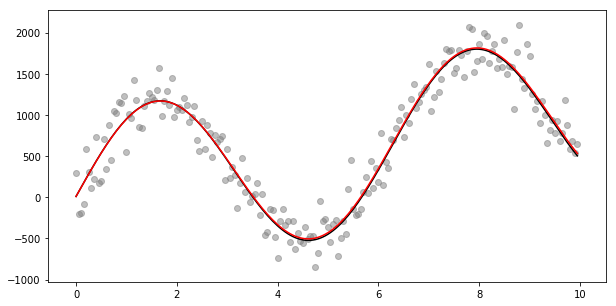

In [540]:
analyze_approximation(t, y_corr)

For method=0 [  313.38729311    36.65958887  1048.7498501 ]
For method=1 [   70.80526967    90.40731517  1019.17002931]
For method=2 [ 2068.97704057     0.          6853.22651138]


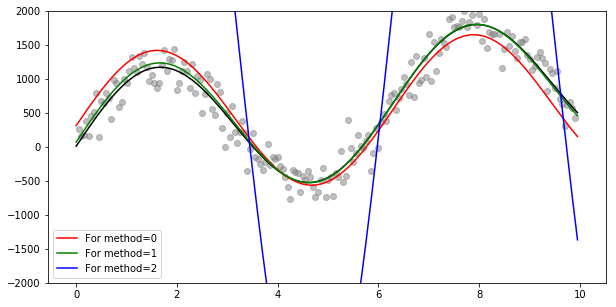

In [455]:
y_corr_with_outlier = y_corr.copy()
outlier = 10000
y_corr_with_outlier[0] += outlier
y_corr_with_outlier[-1] -= outlier

analyze_approximation(t, y_corr_with_outlier)

Хуже всего аппроксимирует method=2, он же совсем неустойчив к выбросам.
method=1 аппроксимирует слегка лучше МНК, но более устойчив к выбросам, чем method=0
method=0 — обычный МНК — довольно хорошо аппроксимирует и довольно устойчив к выбросам. К тому же, он не требует для своей работы симплекс-метода и поэтому работает быстрее. Кажется, что лучше использовать для практических нужд именно его и минимизировать именно в смысле наименьших квадратов, когда это возможно.

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [431]:
A = np.random.normal(size=(200, 80))
b = np.random.normal(size=(200))

x0 = solve_overdefined_system(A, b, method=0)
x1 = solve_overdefined_system(A, b, method=1)
x2 = solve_overdefined_system(A, b, method=2)

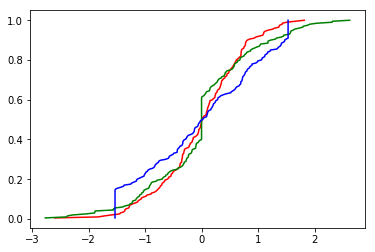

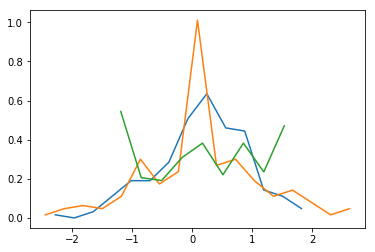

In [440]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

plt.figure()
plt.plot(*ecdf(b-A@x0), color='r', label='For method=0')
plt.plot(*ecdf(b-A@x1), color='g', label='For method=1')
plt.plot(*ecdf(b-A@x2), color='b', label='For method=2')
plt.show()

plt.figure()
counts, bin_edges = np.histogram(b-A@x0, bins='auto', density=True)
plt.plot(bin_edges[1:], counts)
counts, bin_edges = np.histogram(b-A@x1, bins='auto', density=True)
plt.plot(bin_edges[1:], counts)
counts, bin_edges = np.histogram(b-A@x2, bins='auto', density=True)
plt.plot(bin_edges[1:], counts)
plt.show()

## Бонус +1 Балл
Напишите программу которая для обоих методов из задачи 5 будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)

Лексикографический метод влияет только на выбор выходящей переменной. Выбор входящей же может осуществляться любым методом, в том числе методом наибольшего коэффициента. Для него известен простой пример, для которого время работы $2^n-1$ — деформированный гиперкуб Кли-Минти. Там будут обязательно обойдены все вершины.

Он строится так:


In [447]:
def generate_killer_sequence(n, method='blend'):
    if method=='blend':
        A1 = np.eye(n)
        for i in range(0, n-1):
            A1[i+1, i] = 1/3
        b1 = np.ones(n)
        A2 = -np.eye(n)
        for i in range(0, n-1):
            A2[i+1, i] = 1/3
        b2 = np.zeros(n)
        A = np.vstack([A1, A2])
        b = np.hstack([b1, b2])
        c = np.zeros(n)
        c[n-1] = 1
        print(c)
        print(A)
        print(b)
        return A, b, c
    elif method=='lexical':
        c = np.array([10**i for i in range(n, 0, -1)])
        b = np.array([100**i for i in range(0, n)])
        A = np.eye(n)
        for i in range(0, n):
            for j in range(0, i):
                A[i, j] = 2*10**(i-j)
        return A, b, c
    elif method=='blend2':
        a = 2
        c = np.array([a**i for i in range(n, 0, -1)])
        b = np.array([5*5**i for i in range(0, n)])
        A = np.eye(n)
        for i in range(0, n):
            for j in range(0, i):
                A[i, j] = 2*a**(i-j)
        return A, b, c

In [448]:
for i in range(2, 5):
    A, b, c = generate_killer_sequence(i, method='lexical')
    print(A, b, c)
    x, f, n_iter = solve_lin_prog(A, b, c, method='lexical')
    assert (2**i-1 == n_iter)

[[  1.   0.]
 [ 20.   1.]] [  1 100] [100  10]
SOLVING PROBLEM:
[[   1.    0.    1.]
 [  20.    1.  100.]
 [-100.  -10.    0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[   1.  100.]
>          ITERATION #1
>j=0
>ratios [1.0 5.0]
>i=0
>basis [2 1], nonbasis [0 3]
>[[   1.   -0.    1.]
 [ -20.    1.   80.]
 [ 100.  -10.  100.]]
n=2, m=2, basis=[2 1], nonbasis=[0 3] with c_old=None
>x=[ 1.  0.], w=[  0.  80.]
>          ITERATION #2
>j=1
>ratios [-- 80.0]
>i=1
>basis [2 3], nonbasis [0 1]
>[[   1.   -0.    1.]
 [ -20.    1.   80.]
 [-100.   10.  900.]]
n=2, m=2, basis=[2 3], nonbasis=[0 1] with c_old=None
>x=[  1.  80.], w=[ 0.  0.]
>          ITERATION #3
>j=0
>ratios [1.0 --]
>i=0
>basis [0 3], nonbasis [2 1]
>[[    1.    -0.     1.]
 [   20.     1.   100.]
 [  100.    10.  1000.]]
n=2, m=2, basis=[0 3], nonbasis=[2 1] with c_old=None
>x=[   0.  100.], w=[ 1.  0.]
>FINISHED in 3 iterations
>path [array([ 0.,  0.]), array([ 1.,  0.]), array([  1.,  80.]), ar

>          ITERATION #3
>j=0
>ratios [1.0 -- 41.0 491.0]
>i=0
>basis [0 5 2 3], nonbasis [4 1 6 7]
>[[  1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    1.00000000e+00]
 [  2.00000000e+01   1.00000000e+00  -0.00000000e+00  -0.00000000e+00
    1.00000000e+02]
 [ -2.00000000e+02  -2.00000000e+01   1.00000000e+00  -0.00000000e+00
    8.00000000e+03]
 [ -2.00000000e+03  -2.00000000e+02   2.00000000e+01   1.00000000e+00
    9.80000000e+05]
 [  1.00000000e+04   1.00000000e+03  -1.00000000e+02  -1.00000000e+01
    1.00000000e+05]]
n=4, m=4, basis=[0 5 2 3], nonbasis=[4 1 6 7] with c_old=None
>x=[   0.  100.    0.    0.], w=[  1.00000000e+00   0.00000000e+00   8.00000000e+03   9.80000000e+05]
>          ITERATION #4
>j=2
>ratios [-- -- 8000.0 49000.0]
>i=2
>basis [0 5 6 3], nonbasis [4 1 2 7]
>[[  1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    1.00000000e+00]
 [  2.00000000e+01   1.00000000e+00  -0.00000000e+00  -0.00000000e+00
    1.00000000e+02]
 [

>x=[  1.00000000e+00   0.00000000e+00   0.00000000e+00   9.98000000e+05], w=[    0.    80.  9800.     0.]
>          ITERATION #15
>j=0
>ratios [0.9999999999999999 -- -- --]
>i=0
>basis [0 1 2 7], nonbasis [4 5 6 3]
>[[  1.00000000e+00  -2.77555756e-20  -2.77555756e-21  -1.38777878e-22
    1.00000000e+00]
 [  2.00000000e+01   1.00000000e+00  -2.77555756e-19  -1.38777878e-20
    1.00000000e+02]
 [  2.00000000e+02   2.00000000e+01   1.00000000e+00  -1.38777878e-18
    1.00000000e+04]
 [  2.00000000e+03   2.00000000e+02   2.00000000e+01   1.00000000e+00
    1.00000000e+06]
 [  1.00000000e+04   1.00000000e+03   1.00000000e+02   1.00000000e+01
    1.00000000e+07]]
n=4, m=4, basis=[0 1 2 7], nonbasis=[4 5 6 3] with c_old=None
>x=[      0.       0.       0. 1000000.], w=[  1.00000000e+00   1.00000000e+02   1.00000000e+04   0.00000000e+00]
>FINISHED in 15 iterations
>path [array([ 0.,  0.,  0.,  0.]), array([ 1.,  0.,  0.,  0.]), array([  1.,  80.,   0.,   0.]), array([   0.,  100.,    0.,    

In [449]:
for i in range(2, 5):
    A, b, c = generate_killer_sequence(i, method='blend2')
    print(A, b, c)
    x, f, n_iter = solve_lin_prog(A, b, c, method='blend')
    assert (2**i-1 == n_iter)

[[ 1.  0.]
 [ 4.  1.]] [ 5 25] [4 2]
SOLVING PROBLEM:
[[  1.   0.   5.]
 [  4.   1.  25.]
 [ -4.  -2.   0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[  5.  25.]
>          ITERATION #1
>j=0
>ratios [5.0 6.25]
>i=0
>basis [2 1], nonbasis [0 3]
>[[  1.  -0.   5.]
 [ -4.   1.   5.]
 [  4.  -2.  20.]]
n=2, m=2, basis=[2 1], nonbasis=[0 3] with c_old=None
>x=[ 5.  0.], w=[ 0.  5.]
>          ITERATION #2
>j=1
>ratios [-- 5.0]
>i=1
>basis [2 3], nonbasis [0 1]
>[[  1.  -0.   5.]
 [ -4.   1.   5.]
 [ -4.   2.  30.]]
n=2, m=2, basis=[2 3], nonbasis=[0 1] with c_old=None
>x=[ 5.  5.], w=[ 0.  0.]
>          ITERATION #3
>j=0
>ratios [5.0 --]
>i=0
>basis [0 3], nonbasis [2 1]
>[[  1.  -0.   5.]
 [  4.   1.  25.]
 [  4.   2.  50.]]
n=2, m=2, basis=[0 3], nonbasis=[2 1] with c_old=None
>x=[  0.  25.], w=[ 5.  0.]
>FINISHED in 3 iterations
>path [array([ 0.,  0.]), array([ 5.,  0.]), array([ 5.,  5.]), array([  0.,  25.])]
>x=[  0.  25.], w=[ 5.  0.]
>SOLUTIONS [array(

>i=0
>basis [0 5 6 7], nonbasis [4 1 2 3]
>[[   1.   -0.   -0.   -0.    5.]
 [   4.    1.   -0.   -0.   25.]
 [  -8.   -4.    1.   -0.   25.]
 [  16.    8.   -4.    1.  325.]
 [  16.    8.   -4.    2.  950.]]
n=4, m=4, basis=[0 5 6 7], nonbasis=[4 1 2 3] with c_old=None
>x=[   0.   25.   25.  325.], w=[ 5.  0.  0.  0.]
>          ITERATION #12
>j=2
>ratios [-- -- 25.0 --]
>i=2
>basis [0 5 2 7], nonbasis [4 1 6 3]
>[[  1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
    5.00000000e+00]
 [  4.00000000e+00   1.00000000e+00  -0.00000000e+00  -0.00000000e+00
    2.50000000e+01]
 [ -8.00000000e+00  -4.00000000e+00   1.00000000e+00  -0.00000000e+00
    2.50000000e+01]
 [ -1.60000000e+01  -8.00000000e+00   4.00000000e+00   1.00000000e+00
    4.25000000e+02]
 [ -1.60000000e+01  -8.00000000e+00   4.00000000e+00   2.00000000e+00
    1.05000000e+03]]
n=4, m=4, basis=[0 5 2 7], nonbasis=[4 1 6 3] with c_old=None
>x=[   0.   25.    0.  425.], w=[  5.   0.  25.   0.]
>          ITER

In [450]:
from scipy.optimize import linprog

# Avis-Chvatal example
# https://link.springer.com/chapter/10.1007/BFb0121192
a = 2
c = np.array([a**2,a,1])  # maximize
A = np.array([[1, 0, 0],
            [2*a, 1, 0],
            [2*a**2,2*a, 1]])
b = np.array([5, 25, 125])

# a = 0.1
# c = np.array([a**2,a,1])  # maximize
# A = np.array([[1, 0, 0],
#             [2*a, 1, 0],
#             [2*a**2,2*a, 1]])
# b = np.array([1, 1, 1])

# c = np.array([a,1])  # maximize
# A = np.array([[1, 0],
#             [2*a, 1]])
# b = np.array([1, 1])

print(linprog(-c, A_ub=A, b_ub=b))
solve_lin_prog(A, b, c, method='blend')

     fun: -125.0
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([  5.,  25.,   0.])
  status: 0
 success: True
       x: array([   0.,    0.,  125.])
SOLVING PROBLEM:
[[   1.    0.    0.    5.]
 [   4.    1.    0.   25.]
 [   8.    4.    1.  125.]
 [  -4.   -2.   -1.    0.]]
n=3, m=3, basis=[0 1 2], nonbasis=[3 4 5] with c_old=None
>x=[ 0.  0.  0.], w=[   5.   25.  125.]
>          ITERATION #1
>j=0
>ratios [5.0 6.25 15.625]
>i=0
>basis [3 1 2], nonbasis [0 4 5]
>[[  1.  -0.  -0.   5.]
 [ -4.   1.  -0.   5.]
 [ -8.   4.   1.  85.]
 [  4.  -2.  -1.  20.]]
n=3, m=3, basis=[3 1 2], nonbasis=[0 4 5] with c_old=None
>x=[ 5.  0.  0.], w=[  0.   5.  85.]
>          ITERATION #2
>j=1
>ratios [-- 5.0 21.25]
>i=1
>basis [3 4 2], nonbasis [0 1 5]
>[[  1.  -0.  -0.   5.]
 [ -4.   1.  -0.   5.]
 [  8.  -4.   1.  65.]
 [ -4.   2.  -1.  30.]]
n=3, m=3, basis=[3 4 2], nonbasis=[0 1 5] with c_old=None
>x=[ 5.  5.  0.], w=[  0.   0.  65.]
>          ITERATION #3
>j=0
>rati

(array([   0.,    0.,  125.]), 125.0, 7)